In [1]:
### import collections
import json
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from mab import algs


class ONN(nn.Module):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, batch_size=1,
                 b=0.99, n=0.01, s=0.2, use_cuda=False):
        super(ONN, self).__init__()

        if torch.cuda.is_available() and use_cuda:
            print("Using CUDA :]")

        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

        self.features_size = features_size
        self.max_num_hidden_layers = max_num_hidden_layers
        self.qtd_neuron_per_hidden_layer = qtd_neuron_per_hidden_layer
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.b = Parameter(torch.tensor(
            b), requires_grad=False).to(self.device)
        self.n = Parameter(torch.tensor(
            n), requires_grad=False).to(self.device)
        self.s = Parameter(torch.tensor(
            s), requires_grad=False).to(self.device)

        self.hidden_layers = []
        self.output_layers = []

        self.hidden_layers.append(
            nn.Linear(features_size, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers - 1):
            self.hidden_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, qtd_neuron_per_hidden_layer))

        for i in range(max_num_hidden_layers):
            self.output_layers.append(
                nn.Linear(qtd_neuron_per_hidden_layer, n_classes))

        self.hidden_layers = nn.ModuleList(self.hidden_layers).to(self.device)
        self.output_layers = nn.ModuleList(self.output_layers).to(self.device)

        self.alpha = Parameter(torch.Tensor(self.max_num_hidden_layers).fill_(1 / (self.max_num_hidden_layers + 1)),
                               requires_grad=False).to(
            self.device)

        self.loss_array = []
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0

    def zero_grad(self):
        for i in range(self.max_num_hidden_layers):
            self.output_layers[i].weight.grad.data.fill_(0)
            self.output_layers[i].bias.grad.data.fill_(0)
            self.hidden_layers[i].weight.grad.data.fill_(0)
            self.hidden_layers[i].bias.grad.data.fill_(0)

    def update_weights(self, X, Y, weight, show_loss, test):
        Y = torch.from_numpy(Y).to(self.device)
        if test=='yes':
            prediction_1 = self.predict_1(X)
            self.update_eval_metrics(prediction_1,Y)
            self.update_stp_score(prediction_1,X)
            self.update_eqop_score(prediction_1,X,Y)
        
        predictions_per_layer = self.forward(X)
        losses_per_layer = []

        for out in predictions_per_layer:
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(out.view(self.batch_size, self.n_classes), Y.view(
                self.batch_size).long())
            losses_per_layer.append(loss*weight)

        w = [None] * len(losses_per_layer)
        b = [None] * len(losses_per_layer)
        
        with torch.no_grad():     #Context-manager that disabled gradient calculation
            self.weights_output_layers = list()
            self.biases_output_layers = list()
            for i in range(len(losses_per_layer)):
                losses_per_layer[i].backward(retain_graph=True)
                self.output_layers[i].weight.data -= self.n * \
                                                   self.alpha[i] * self.output_layers[i].weight.grad.data
                self.output_layers[i].bias.data -= self.n * \
                                                 self.alpha[i] * self.output_layers[i].bias.grad.data
                self.weights_output_layers.append(self.output_layers[i].weight.data) 
                self.biases_output_layers.append(self.output_layers[i].bias.data)
                
                for j in range(i + 1):
                    if w[j] is None:
                        w[j] = self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] = self.alpha[i] * self.hidden_layers[j].bias.grad.data
                    else:
                        w[j] += self.alpha[i] * self.hidden_layers[j].weight.grad.data
                        b[j] += self.alpha[i] * self.hidden_layers[j].bias.grad.data
                self.zero_grad()
            self.weights_hidden_layers= list()
            self.biases_hidden_layers = list()
            
            for i in range(len(losses_per_layer)):
                self.hidden_layers[i].weight.data -= self.n * w[i]
                self.hidden_layers[i].bias.data -= self.n * b[i]
                self.weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                self.biases_hidden_layers.append(self.hidden_layers[i].bias.data)
            for i in range(len(losses_per_layer)):
                self.alpha[i] *= torch.pow(self.b, losses_per_layer[i])
                self.alpha[i] = torch.max(
                  self.alpha[i], self.s / self.max_num_hidden_layers)

        z_t = torch.sum(self.alpha)

        self.alpha = Parameter(
            self.alpha / z_t, requires_grad=False).to(self.device)
        if show_loss:
            
            real_output = torch.sum(torch.mul(
                self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, self.batch_size).view(
                    self.max_num_hidden_layers, self.batch_size, 1), predictions_per_layer), 0)
            criterion = nn.CrossEntropyLoss().to(self.device)
            loss = criterion(real_output.view(self.batch_size, self.n_classes), Y.view(self.batch_size).long())
            self.loss_array.append(loss)
            if (len(self.loss_array) % 1000) == 0:
                #print("WARNING: Set 'show_loss' to 'False' when not debugging. "
                #      "It will deteriorate the fitting performance.")
                loss = torch.Tensor(self.loss_array).mean().cpu().numpy()
                #print("Alpha:" + str(self.alpha.data.cpu().numpy()))
                print("Training Loss: " + str(loss))
                print("Balanced accuracy: " + str(self.bal_acc))
                print("Sensitivity: " + str(self.sen))
                print("Specificity: " + str(self.spec))
                print("Stp score: " + str(self.stp_score))
                print("Eqop score: " + str(self.eqop_score))
                self.loss_array.clear()

    def get_weights(self,network_name):
        
        if network_name == 'global':
            weights_output_layers = list()
            biases_output_layers = list()
            weights_hidden_layers = list()
            biases_hidden_layers= list()
            for i in range(self.max_num_hidden_layers):
                weights_output_layers.append(self.output_layers[i].weight.data) 
                biases_output_layers.append(self.output_layers[i].bias.data)
                weights_hidden_layers.append(self.hidden_layers[i].weight.data)
                biases_hidden_layers.append(self.hidden_layers[i].bias.data)
               
            return self.alpha, weights_output_layers, biases_output_layers, weights_hidden_layers, biases_hidden_layers
        else:
            return self.alpha, self.weights_output_layers, self.biases_output_layers, self.weights_hidden_layers, self.biases_hidden_layers
    
    def set_weights(self, alpha, w_output_layer, b_output_layer, w_hidden_layer, b_hidden_layer):
        
        for i in range(self.max_num_hidden_layers):
            self.alpha[i] = alpha[i].clone().detach()
            self.output_layers[i].weight.data = w_output_layer[i].clone().detach()
            self.output_layers[i].bias.data = b_output_layer [i].clone().detach()
            self.hidden_layers[i].weight.data =  w_hidden_layer [i].clone().detach()
            self.hidden_layers[i].bias.data = b_hidden_layer [i].clone().detach()    
    def forward(self, X):
        hidden_connections = []

        X = torch.from_numpy(X).float().to(self.device)

        x = F.relu(self.hidden_layers[0](X))
        hidden_connections.append(x)

        for i in range(1, self.max_num_hidden_layers):
            hidden_connections.append(
                F.relu(self.hidden_layers[i](hidden_connections[i - 1])))

        output_class = []

        for i in range(self.max_num_hidden_layers):
            output_class.append(self.output_layers[i](hidden_connections[i]))

        pred_per_layer = torch.stack(output_class)

        return pred_per_layer

    def validate_input_X(self, data):
        
        if len(data.shape) != 2:
            raise Exception(
                "Wrong dimension for this X data. It should have only two dimensions.")

    def validate_input_Y(self, data):
        if len(data.shape) != 1:
            raise Exception(
                "Wrong dimension for this Y data. It should have only one dimensions.")

    def partial_fit_(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.validate_input_X(X_data)
        self.validate_input_Y(Y_data)
        self.update_weights(X_data, Y_data, weight, show_loss, test)

    def partial_fit(self, X_data, Y_data, weight, show_loss=True, test='yes'):
        
        self.partial_fit_(X_data, Y_data, weight, show_loss, test)

    def reset_eval_metrics(self):
        self.tp=0.1
        self.tn=0.1
        self.fp=0.1
        self.fn=0.1
        self.bal_acc = 0
        self.bal_acc_list = []
        self.sen = 0
        self.spec = 0
        
        self.protected_pos = 0.1
        self.protected_neg = 0.1
        self.non_protected_pos = 0.1
        self.non_protected_neg = 0.1
        self.stp_score=0
        
        self.tp_protected = 0.1
        self.fn_protected = 0.1
        self.tp_non_protected = 0.1
        self.fn_non_protected = 0.1
        self.eqop_score=0
    def update_eval_metrics(self,prediction_1,Y):
        if prediction_1==1 and Y==1:
            self.tp+=1
        elif prediction_1==1 and Y==0:
            self.fp+=1
        elif prediction_1==0 and Y==1:
            self.fn+=1
        else:
            self.tn+=1
        
        self.sen = self.tp/(self.tp + self.fn)
        self.spec= self.tn/(self.tn + self.fp)
        self.bal_acc = (self.sen + self.spec)/2
        self.bal_acc_list.append(self.bal_acc)
            
    def update_stp_score(self,prediction_1,X):
        if X[0][sa_index] == p_Group:
            if prediction_1 == 1:
                self.protected_pos += 1.
            else:
                self.protected_neg += 1.
        else:
            if prediction_1 == 1:
                self.non_protected_pos += 1.
            else:
                self.non_protected_neg += 1.
            
        C_prot = (self.protected_pos) / (self.protected_pos + self.protected_neg)
        C_non_prot = (self.non_protected_pos) / (self.non_protected_pos + self.non_protected_neg)

        self.stp_score = C_non_prot - C_prot
    
    def update_eqop_score(self,prediction_1,X,Y):
        if X[0][sa_index] == p_Group:
            if prediction_1==1 and Y==1:
                self.tp_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_protected += 1.
        else:
            if prediction_1==1 and Y==1:
                self.tp_non_protected += 1.
            elif prediction_1==0 and Y==1:
                self.fn_non_protected += 1.
            
        tpr_protected = self.tp_protected / (self.tp_protected + self.fn_protected)
        tpr_non_protected = self.tp_non_protected / (self.tp_non_protected + self.fn_non_protected)
        self.eqop_score = tpr_non_protected - tpr_protected
    
    def predict_1(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, 1).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()
    def predict_(self, X_data):
        self.validate_input_X(X_data)
        return torch.argmax(torch.sum(torch.mul(
            self.alpha.view(self.max_num_hidden_layers, 1).repeat(1, len(X_data)).view(
                self.max_num_hidden_layers, len(X_data), 1), self.forward(X_data)), 0), dim=1).cpu().numpy()

    def predict(self, X_data):
        pred = self.predict_(X_data)
        return pred

    def export_params_to_json(self):
        state_dict = self.state_dict()
        params_gp = {}
        for key, tensor in state_dict.items():
            params_gp[key] = tensor.cpu().numpy().tolist()

        return json.dumps(params_gp)

    def load_params_from_json(self, json_data):
        params = json.loads(json_data)
        o_dict = collections.OrderedDict()
        for key, tensor in params.items():
            o_dict[key] = torch.tensor(tensor).to(self.device)
        self.load_state_dict(o_dict)


class ONN_THS(ONN):
    def __init__(self, features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=0.99, n=0.01,
                 s=0.2, e=[0.5, 0.35, 0.2, 0.1, 0.05], use_cuda=False):
        super().__init__(features_size, max_num_hidden_layers, qtd_neuron_per_hidden_layer, n_classes, b=b, n=n, s=s,
                         use_cuda=use_cuda)
        self.e = Parameter(torch.tensor(e), requires_grad=False)
        self.arms_values = Parameter(
            torch.arange(n_classes), requires_grad=False)
        self.explorations_mab = []

        for i in range(n_classes):
            self.explorations_mab.append(algs.ThompsomSampling(len(e)))

    def partial_fit(self, X_data, Y_data, exp_factor, show_loss=True):
        self.partial_fit_(X_data, Y_data, show_loss)
        self.explorations_mab[Y_data[0]].reward(exp_factor)

    def predict(self, X_data):
        pred = self.predict_(X_data)[0]
        exp_factor = self.explorations_mab[pred].select()[0]
        if np.random.uniform() < self.e[exp_factor]:
            removed_arms = self.arms_values.clone().numpy().tolist()
            removed_arms.remove(pred)
            return random.choice(removed_arms), exp_factor

        return pred, exp_factor


In [2]:
from sklearn.datasets import make_classification, make_circles
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from imblearn.datasets import make_imbalance
import numpy as np

In [3]:
# import urllib2
import os, sys
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

# import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)


def load_bank():
    FEATURES_CLASSIFICATION = ["age", "job", "marital", "education", "default", "balance", "housing", "loan", "contact",
                               "day", "month", "duration", "campaign", "pdays", "previous",
                               "poutcome"]  # features to be used for classification
    CONT_VARIABLES = ["age", "balance", "day", "duration", "campaign", "pdays",
                      "previous"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "y"  # the decision variable
    SENSITIVE_ATTRS = ["marital"]
    CAT_VARIABLES = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "previous", "poutcome"]
    CAT_VARIABLES_INDICES = [1,2,3,4,6,7,8,10,14,15]
    # COMPAS_INPUT_FILE = "bank-full.csv"
    COMPAS_INPUT_FILE = "./datasets/bank-full.csv"

    df = pd.read_csv(COMPAS_INPUT_FILE)
    
    # convert to np array
    data = df.to_dict('list')
    
    for k in data.keys():
        data[k] = np.array(data[k])

    """ Feature normalization and one hot encoding """

    # convert class label 0 to -1
    y = data[CLASS_FEATURE]
    y[y == "yes"] = 1
    y[y == 'no'] = -1
    y = np.array([int(k) for k in y])

    X = np.array([]).reshape(len(y), 0)  # empty array with num rows same as num examples, will hstack the features to it
    
    x_control = defaultdict(list)
    i=0
    feature_names = []
    
    for attr in FEATURES_CLASSIFICATION:
        vals = data[attr]
        
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            vals = preprocessing.scale(vals)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            lb = preprocessing.LabelBinarizer()
            lb.fit(vals)
            vals = lb.transform(vals)
            #vals = np.reshape(vals, (len(y), -1))
           
            #if attr == 'job':
            #    print(lb.classes_)
            #    print(lb.transform(lb.classes_))
            
           
            
            
        # add to sensitive features dict
        if attr in SENSITIVE_ATTRS:
            x_control[attr] = vals
            

        # add to learnable features
        X = np.hstack((X, vals))
        
        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in lb.classes_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    # convert the sensitive feature to 1-d array
    
    x_control = dict(x_control)
    
    for k in x_control.keys():
        assert (x_control[k].shape[1] == 1)  # make sure that the sensitive feature is binary after one hot encoding
        x_control[k] = np.array(x_control[k]).flatten()
    
    feature_names.append('target')
    # '0' is the marital status = 'married'
   
    
    return X, y, feature_names.index(SENSITIVE_ATTRS[0]), 0, x_control

X,y, sa_index, p_Group, x_control= load_bank()
#print(X[0])
#print(X[0][1])
#print(sa_index)
np_Group = 1 #non-protected group's sa_value
Y_1 = []
for i in y:
    if (i == -1):
        Y_1.append(0)
    else:
        Y_1.append(1)
y = np.array(Y_1)


In [4]:
COMPAS_INPUT_FILE = "./datasets/bank-full.csv"

df = pd.read_csv(COMPAS_INPUT_FILE)
age_group_1 = []
age_group_2 = []
age_group_3 = []
for i in range(len(df)):
    if df['age'].iloc[i]>0 and df['age'].iloc[i]<30:
        age_group_1.append(i)
    elif df['age'].iloc[i]>29 and df['age'].iloc[i]<40:
        age_group_2.append(i)
    elif df['age'].iloc[i]>39:
        age_group_3.append(i)
   

In [5]:
Xtr1 = np.empty((0,0))
Ytr1 = np.empty(0)
for i in age_group_1:
    if np.size(Xtr1)==0:
        print("bismillah")
        Xtr1 = X[i]
        Ytr1 = y[i]
    else:
        Xtr1 = np.vstack((Xtr1,X[i]))
        Ytr1 = np.append(Ytr1,y[i])

Xtr2 = np.empty((0,0))
Ytr2 = np.empty(0)
for i in age_group_2:
    if np.size(Xtr2)==0:
        print("bismillah")
        Xtr2 = X[i]
        Ytr2 = y[i]
    else:
        Xtr2 = np.vstack((Xtr2,X[i]))
        Ytr2 = np.append(Ytr2,y[i])
        
Xtr3 = np.empty((0,0))
Ytr3 = np.empty(0)
for i in age_group_3:
    if np.size(Xtr3)==0:
        print("bismillah")
        Xtr3 = X[i]
        Ytr3 = y[i]
    else:
        Xtr3 = np.vstack((Xtr3,X[i]))
        Ytr3 = np.append(Ytr3,y[i])
print(len(Xtr3))
print(len(Ytr3))
print(Ytr3)

bismillah
bismillah
bismillah
18243
18243
[0 0 0 ... 1 1 0]


In [6]:
labels = Ytr2
unique, counts = np.unique(labels, return_counts=True)
count_ap_dict = dict(zip(unique, counts))
print(count_ap_dict)
minority_label=1
majority_label = 0        

{0: 14833, 1: 1755}


In [7]:
clients = {}
client_data_testx = []
client_data_testy = []
x_train, x_test, y_train, y_test = train_test_split(Xtr1,Ytr1,test_size=0.2)
Xtr1 = x_train
Xte1 = x_test
Ytr1 = y_train
Yte1 = y_test
Xtr = x_train
client_data_testx.append(Xte1)
client_data_testy.append(Yte1)
####
x_train, x_test, y_train, y_test = train_test_split(Xtr2,Ytr2,test_size=0.2)
Xtr2 = x_train
Xte2 = x_test
Ytr2 = y_train
Yte2 = y_test
client_data_testx.append(Xte2)
client_data_testy.append(Yte2)
####
x_train, x_test, y_train, y_test = train_test_split(Xtr3,Ytr3,test_size=0.2)
Xtr3 = x_train
Xte3 = x_test
Ytr3 = y_train
Yte3 = y_test
client_data_testx.append(Xte3)
client_data_testy.append(Yte3)
####

#client_data_testx.append(Xte4)
#client_data_testy.append(Yte4)


In [8]:
#concatnate teset data
x_test_new = np.concatenate((client_data_testx[0], client_data_testx[1]), axis=0)
x_test_new = np.concatenate((x_test_new, client_data_testx[2]), axis=0)
y_test_new = np.concatenate((client_data_testy[0], client_data_testy[1]), axis=0)
y_test_new = np.concatenate((y_test_new, client_data_testy[2]), axis=0)
#test_batched1 = tf.data.Dataset.from_tensor_slices((x_test_new, y_test_new)).batch(len(y_test_new))
x_test = x_test_new
y_test = y_test_new

In [9]:
def k_nearest_neighbors(data, predict, k):
    #k=8
    #if len(data) >= k:
    #    warnings.warn('K is set to a value less than total voting groups!')

    distances = []
    count = 0
    for sample in data:
        euclidean_distance = np.linalg.norm(np.array(sample)-np.array(predict))
        distances.append([euclidean_distance,count])
        count+=1
    
    votes = [i[1] for i in sorted(distances)[:k]] ##votes is returning indexes of k random samples

    #vote_result = Counter(votes).most_common(9)[0][0]
    return votes
def fair_kSMOTE_algo_2(dmajor,dminor,k,r):
    S = []
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    i = 0
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,k) #from minority-p
        
        #do linear interpolation
        Sxb = []
        
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        for s in range(Nkss):
            
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
                
            x_new = x_new / (len(N)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
    
    return S

def fair_kSMOTE(dmajor,dminor_wg,dminor,k,r):
    S = []
    #Ns =  int(r*(len(dmajor) - len(dminor)))
    Ns =  int(r*(len(dmajor)))
    #Ns = 12
    
    Nks = int(Ns / (k-1))
    difference = Ns-Nks*(k-1)
    #if r==-1:
    #    Nks = 1
    rb = []
    #pick a random k sample from dmin and save them in rb
    dmin_rand = random.sample(dminor, k-1)   
    #for debugging
    sens_attr_vals = []
    
    
    #do algorithem (choose the nearest neighbor and linear interpolation)
    i = 0
    
    for xb in dmin_rand:
        N= k_nearest_neighbors(dminor,xb,int(k/2)+1) #from minority-p
        N2= k_nearest_neighbors(dminor_wg,xb,int(k/2)) #from minority-np
    
        N3 = np.hstack((N, N2))
        if i==0:
            Nkss = Nks+difference
        else:
            Nkss = Nks
        
        i+=1
        #do linear interpolation
        Sxb = []
        
        for s in range(Nkss):
            
            j = 1  ##?? j?
            #randome k sample
            #j = random.randint(0, len(N))
            
            ##here nearst neghber insted of dminor
            #linear interpolation
            x_new = ((dminor[N[j]]-xb) * random.sample(range(0, 1), 1))
            j+=1
            
            while(j < len(N)):
                #here on random xb
                ind = N[j]
                
                x_new = x_new + ((dminor[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1
            j = 0
            while(j < len(N2)):
                #here on random xb
                ind = N2[j]
                
                x_new = x_new + ((dminor_wg[ind]-xb) * random.sample(range(0, 1), 1))
                j += 1    
            x_new = x_new / (len(N3)-1) ##??? why scaling with k here
            Synthesized_instance = xb + x_new ##?> why we need to sum xb and x_new
            
            
            #for algo 3 when finding nearest neighbors from min_np and assigning the 
            #'p' sensitive value to all synthesized instances
            Synthesized_instance[sa_index] = xb[sa_index] 
            Sxb.append(Synthesized_instance)
        
            
            
            
            
        S.append(Sxb)
    
    
   
    return S





def splitYtrain_sa_value(Xtr,Ytr,minority_lable,majority_label,pp_Group=p_Group,npp_Group=np_Group): #splite Ytrain based on sensitive attribute value
    #print(Ytr)
    dmaj_p_x = []
    dmaj_np_x = []
    dmin_p_x = []
    dmin_np_x = []
    
    
    for i in range(len(Ytr)):
        if((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==pp_Group): #select minority instances with "protected" value 
            dmin_p_x.append(Xtr[i])
        elif((Ytr[i]) == minority_lable and (Xtr[i][sa_index])==npp_Group): #select minority instances with "protected" value 
            dmin_np_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==pp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_p_x.append(Xtr[i])
        elif ((Ytr[i]) == majority_label and (Xtr[i][sa_index])==npp_Group): #select minority(positive class) instances with "non-protected" value
            dmaj_np_x.append(Xtr[i])
    
    return dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x



#create_synth_data(window, window_label, minority_label,majority_label,5,lambda_score, 'min_p')
def create_synth_data(x, y, minority_lable,majority_label,k,r,group,pp_group,npp_group):
    
    
    dmin_p_x, dmin_np_x, dmaj_p_x, dmaj_np_x = splitYtrain_sa_value(x,y,minority_lable,majority_label, pp_group,npp_group)
    '''
    print("length of dmin_p_x: " + str(len(dmin_p_x)))
    print("length of dmin_np_x: " + str(len(dmin_np_x)))
    print("length of dmaj_p_x: " + str(len(dmaj_p_x)))
    print("length of dmaj_np_x: " + str(len(dmaj_np_x)))
    '''
    if len(dmin_p_x)<4:
        return -1, -1
    group_names = ['dmin_p_x', 'dmin_np_x', 'dmaj_p_x', 'dmaj_np_x']
    
    Xtr_new = []
    Ytr_new = []  
    
    
    ##Algo 3:
    
    if group =='min_p':
        dmaj_x = dmaj_p_x
        dmin_x = dmin_p_x
        
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE(dmaj_x,dmin_np_x,dmin_x,k,r)
        #x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = minority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
        
    elif group =='maj_np':
        dmaj_x = dmin_np_x
        dmin_x = dmaj_np_x
        #dmin_np = dmin_np_x
        x_syn = fair_kSMOTE_algo_2(dmaj_x,dmin_x,k,r)
        
        
        # add the created synthatic data to the traning data
        # here merrge old traning data with the new synthatic data
        new_label = majority_label
        for j in x_syn:
            for s in j:
                Xtr_new.append(s)
                Ytr_new.append(new_label)
    
    
    
    return Xtr_new,Ytr_new

In [10]:
def online_update_classSize(train_data, label,classSize):
    theta = 0.9
    if (label not in classSize):
        up_dict = {train_data[-1]:0.5}
        classSize.update(up_dict)
    for classValue in classSize:
        if classValue == label:
            update = theta * classSize.get(classValue) + (1-theta)
            classSize[classValue] = update
        else:
            update = theta * classSize.get(classValue)
            classSize[classValue] = update

In [11]:
def create_clients(Xtr1, Ytr1,Xtr2,Ytr2,Xtr3,Ytr3,num_clients,initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''
    clients = {}
    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    
    data = list(zip(Xtr1, Ytr1))
    random.shuffle(data)
    
    clients.update({client_names[0] :data})
    data = list(zip(Xtr2, Ytr2))
    clients.update({client_names[1] :data})
    data = list(zip(Xtr3, Ytr3))
    clients.update({client_names[2] :data})
    #data = list(zip(Xtr4, Ytr4))
    #clients.update({client_names[3] :data})

    return clients
clients = create_clients(Xtr1,Ytr1,Xtr2,Ytr2,Xtr3,Ytr3, num_clients=3, initial='client')

In [12]:
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle

client_index = {}
client_window = {}
client_window_label = {}
client_eddm = {}

for (client_name, data) in clients.items():
    data, label = zip(*data)
    Y = np.asarray(label)
    X = np.asarray(data)
    client_index.update({client_name:0})
    client_window.update({client_name:[]})
    client_window_label.update({client_name:[]})
    length = len(data)
    print(len(data))
#client_eddm.update({'client_1':eddm1})
#client_eddm.update({'client_2':eddm2})
#client_eddm.update({'client_3':eddm3})
print(client_index)

4138
13270
14594
{'client_1': 0, 'client_2': 0, 'client_3': 0}


In [13]:
import warnings
import math
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.02
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0


bal_acc_global=[] 
stp_score_global=[]
gmean_global = []
eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
weight = 1
client_down =0 
for _ in range(length):
    if client_down==2:
        break
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []

    for (client_name, data) in clients.items():
        if client_name not in client_index:
            continue
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%200==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        
        if client_index[client_name]<len(Y):
            if Y[i]==minority_label:
                onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),10)
            
            else:
                onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
            if np.size(client_window[client_name])==0:
                client_window[client_name] = np.array(X[i])
                client_window_label[client_name] = np.array(Y[i])
            else:
                client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
                client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
            eddm.add_element(Y[i])
    

            if eddm.detected_change():
                print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
                change+=1
                client_window[client_name] = []
                client_window_label[client_name] = []
    
            
            pos_assigned = onn_network.tp+onn_network.fp-0.2
            pos_samples = onn_network.tp+onn_network.fn-0.2
            
            if np.size(client_window[client_name])!=0:
                if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                    if onn_network.stp_score > 0.005:
                        #print(onn_network.stp_score)
                        lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                        if pos_assigned <= pos_samples:
                            X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', p_Group,np_Group)
                        else:
                            X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', p_Group,np_Group)
                        if X_syn!=-1:
                            Y_syn = np.array(Y_syn)
                            X_syn = np.array(X_syn)
                            X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                            added_points = len(Y_syn)
                            for k in range(len(X_syn)):
                                onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1, test='no')
            
            client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
            i=i+1
            client_index.update({client_name:i})
            scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
            #scaling_factor = 1/5
            scaling_factor2 = 1/3
            if client_down==2:
                scaling_factor2 = 1/2
            print(client_index)
            p = 0
            if p==0:
                if sum_alpha==[]:
                    sum_alpha = torch.mul(client_alpha, scaling_factor2)
                    sum_w_output_layer = client_w_output_layer
                    sum_b_output_layer = client_b_output_layer
                    sum_w_hidden_layer = client_w_hidden_layer
                    sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                    for j in range(onn_network.max_num_hidden_layers):
                        sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                        sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                        sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                        sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

                else:
                    sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                    for j in range(onn_network.max_num_hidden_layers):
                        sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                        sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                        sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                        sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        if len(Y)==client_index[client_name]:
            client_down+=1
            del client_index[client_name]
    if i%200==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)

        x_test, y_test = shuffle(x_test, y_test, random_state=0)
        
        for m in range(len(x_test)-1):
            prediction_1 = global_network.predict_1(np.asarray([x_test[m, :]]))
            global_network.update_eval_metrics(prediction_1,np.asarray([y_test[m]]))
            global_network.update_stp_score(prediction_1,np.asarray([x_test[m, :]]))
            global_network.update_eqop_score(prediction_1,np.asarray([x_test[m, :]]),np.asarray([y_test[m]]))
        
        print("Balanced accuracy: " + str(global_network.bal_acc))
        print("Sensitivity: " + str(global_network.sen))
        print("Specificity: " + str(global_network.spec))
        print("Stp score: " + str(global_network.stp_score))
        print("Eqop score: " + str(global_network.eqop_score))
        
        bal_acc_global.append(global_network.bal_acc)
        gmean_global.append(math.sqrt(global_network.sen*global_network.spec))
        stp_score_global.append(global_network.stp_score)
        global_network.reset_eval_metrics()
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer) 
for n in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[n, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[n]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[n, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[n, :]]),np.asarray([y_test[n]]))

bal_acc_global.append(global_network.bal_acc)  
stp_score_global.append(global_network.stp_score)        #print("change" + str(change))
gmean_global.append(math.sqrt(global_network.sen*global_network.spec))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

{'client_1': 0, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 0, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 0}
{'client_1': 1, 'client_2': 1, 'client_3': 1}
{'client_1': 2, 'client_2': 1, 'client_3': 1}
{'client_1': 2, 'client_2': 2, 'client_3': 1}
{'client_1': 2, 'client_2': 2, 'client_3': 2}
{'client_1': 3, 'client_2': 2, 'client_3': 2}
{'client_1': 3, 'client_2': 3, 'client_3': 2}
{'client_1': 3, 'client_2': 3, 'client_3': 3}
{'client_1': 4, 'client_2': 3, 'client_3': 3}
{'client_1': 4, 'client_2': 4, 'client_3': 3}
{'client_1': 4, 'client_2': 4, 'client_3': 4}
{'client_1': 5, 'client_2': 4, 'client_3': 4}
{'client_1': 5, 'client_2': 5, 'client_3': 4}
{'client_1': 5, 'client_2': 5, 'client_3': 5}
{'client_1': 6, 'client_2': 5, 'client_3': 5}
{'client_1': 6, 'client_2': 6, 'client_3': 5}
{'client_1': 6, 'client_2': 6, 'client_3': 6}
{'client_1': 7, 'client_2': 6, 'cl

{'client_1': 57, 'client_2': 57, 'client_3': 56}
{'client_1': 57, 'client_2': 57, 'client_3': 57}
{'client_1': 58, 'client_2': 57, 'client_3': 57}
{'client_1': 58, 'client_2': 58, 'client_3': 57}
{'client_1': 58, 'client_2': 58, 'client_3': 58}
{'client_1': 59, 'client_2': 58, 'client_3': 58}
{'client_1': 59, 'client_2': 59, 'client_3': 58}
{'client_1': 59, 'client_2': 59, 'client_3': 59}
{'client_1': 60, 'client_2': 59, 'client_3': 59}
{'client_1': 60, 'client_2': 60, 'client_3': 59}
{'client_1': 60, 'client_2': 60, 'client_3': 60}
{'client_1': 61, 'client_2': 60, 'client_3': 60}
{'client_1': 61, 'client_2': 61, 'client_3': 60}
{'client_1': 61, 'client_2': 61, 'client_3': 61}
{'client_1': 62, 'client_2': 61, 'client_3': 61}
{'client_1': 62, 'client_2': 62, 'client_3': 61}
{'client_1': 62, 'client_2': 62, 'client_3': 62}
{'client_1': 63, 'client_2': 62, 'client_3': 62}
{'client_1': 63, 'client_2': 63, 'client_3': 62}
{'client_1': 63, 'client_2': 63, 'client_3': 63}
{'client_1': 64, 'cl

{'client_1': 113, 'client_2': 113, 'client_3': 112}
{'client_1': 113, 'client_2': 113, 'client_3': 113}
{'client_1': 114, 'client_2': 113, 'client_3': 113}
{'client_1': 114, 'client_2': 114, 'client_3': 113}
{'client_1': 114, 'client_2': 114, 'client_3': 114}
{'client_1': 115, 'client_2': 114, 'client_3': 114}
{'client_1': 115, 'client_2': 115, 'client_3': 114}
{'client_1': 115, 'client_2': 115, 'client_3': 115}
{'client_1': 116, 'client_2': 115, 'client_3': 115}
{'client_1': 116, 'client_2': 116, 'client_3': 115}
{'client_1': 116, 'client_2': 116, 'client_3': 116}
{'client_1': 117, 'client_2': 116, 'client_3': 116}
{'client_1': 117, 'client_2': 117, 'client_3': 116}
{'client_1': 117, 'client_2': 117, 'client_3': 117}
{'client_1': 118, 'client_2': 117, 'client_3': 117}
{'client_1': 118, 'client_2': 118, 'client_3': 117}
{'client_1': 118, 'client_2': 118, 'client_3': 118}
{'client_1': 119, 'client_2': 118, 'client_3': 118}
{'client_1': 119, 'client_2': 119, 'client_3': 118}
{'client_1':

{'client_1': 168, 'client_2': 168, 'client_3': 167}
{'client_1': 168, 'client_2': 168, 'client_3': 168}
{'client_1': 169, 'client_2': 168, 'client_3': 168}
{'client_1': 169, 'client_2': 169, 'client_3': 168}
{'client_1': 169, 'client_2': 169, 'client_3': 169}
{'client_1': 170, 'client_2': 169, 'client_3': 169}
{'client_1': 170, 'client_2': 170, 'client_3': 169}
{'client_1': 170, 'client_2': 170, 'client_3': 170}
{'client_1': 171, 'client_2': 170, 'client_3': 170}
{'client_1': 171, 'client_2': 171, 'client_3': 170}
{'client_1': 171, 'client_2': 171, 'client_3': 171}
{'client_1': 172, 'client_2': 171, 'client_3': 171}
{'client_1': 172, 'client_2': 172, 'client_3': 171}
{'client_1': 172, 'client_2': 172, 'client_3': 172}
{'client_1': 173, 'client_2': 172, 'client_3': 172}
{'client_1': 173, 'client_2': 173, 'client_3': 172}
{'client_1': 173, 'client_2': 173, 'client_3': 173}
{'client_1': 174, 'client_2': 173, 'client_3': 173}
{'client_1': 174, 'client_2': 174, 'client_3': 173}
{'client_1':

{'client_1': 221, 'client_2': 221, 'client_3': 220}
{'client_1': 221, 'client_2': 221, 'client_3': 221}
{'client_1': 222, 'client_2': 221, 'client_3': 221}
{'client_1': 222, 'client_2': 222, 'client_3': 221}
{'client_1': 222, 'client_2': 222, 'client_3': 222}
{'client_1': 223, 'client_2': 222, 'client_3': 222}
{'client_1': 223, 'client_2': 223, 'client_3': 222}
{'client_1': 223, 'client_2': 223, 'client_3': 223}
{'client_1': 224, 'client_2': 223, 'client_3': 223}
{'client_1': 224, 'client_2': 224, 'client_3': 223}
{'client_1': 224, 'client_2': 224, 'client_3': 224}
{'client_1': 225, 'client_2': 224, 'client_3': 224}
{'client_1': 225, 'client_2': 225, 'client_3': 224}
{'client_1': 225, 'client_2': 225, 'client_3': 225}
{'client_1': 226, 'client_2': 225, 'client_3': 225}
{'client_1': 226, 'client_2': 226, 'client_3': 225}
{'client_1': 226, 'client_2': 226, 'client_3': 226}
{'client_1': 227, 'client_2': 226, 'client_3': 226}
{'client_1': 227, 'client_2': 227, 'client_3': 226}
{'client_1':

{'client_1': 274, 'client_2': 273, 'client_3': 273}
{'client_1': 274, 'client_2': 274, 'client_3': 273}
{'client_1': 274, 'client_2': 274, 'client_3': 274}
{'client_1': 275, 'client_2': 274, 'client_3': 274}
{'client_1': 275, 'client_2': 275, 'client_3': 274}
{'client_1': 275, 'client_2': 275, 'client_3': 275}
{'client_1': 276, 'client_2': 275, 'client_3': 275}
{'client_1': 276, 'client_2': 276, 'client_3': 275}
{'client_1': 276, 'client_2': 276, 'client_3': 276}
{'client_1': 277, 'client_2': 276, 'client_3': 276}
{'client_1': 277, 'client_2': 277, 'client_3': 276}
{'client_1': 277, 'client_2': 277, 'client_3': 277}
{'client_1': 278, 'client_2': 277, 'client_3': 277}
{'client_1': 278, 'client_2': 278, 'client_3': 277}
{'client_1': 278, 'client_2': 278, 'client_3': 278}
{'client_1': 279, 'client_2': 278, 'client_3': 278}
{'client_1': 279, 'client_2': 279, 'client_3': 278}
{'client_1': 279, 'client_2': 279, 'client_3': 279}
{'client_1': 280, 'client_2': 279, 'client_3': 279}
{'client_1':

{'client_1': 326, 'client_2': 326, 'client_3': 326}
{'client_1': 327, 'client_2': 326, 'client_3': 326}
{'client_1': 327, 'client_2': 327, 'client_3': 326}
{'client_1': 327, 'client_2': 327, 'client_3': 327}
{'client_1': 328, 'client_2': 327, 'client_3': 327}
{'client_1': 328, 'client_2': 328, 'client_3': 327}
{'client_1': 328, 'client_2': 328, 'client_3': 328}
{'client_1': 329, 'client_2': 328, 'client_3': 328}
{'client_1': 329, 'client_2': 329, 'client_3': 328}
{'client_1': 329, 'client_2': 329, 'client_3': 329}
{'client_1': 330, 'client_2': 329, 'client_3': 329}
{'client_1': 330, 'client_2': 330, 'client_3': 329}
{'client_1': 330, 'client_2': 330, 'client_3': 330}
{'client_1': 331, 'client_2': 330, 'client_3': 330}
{'client_1': 331, 'client_2': 331, 'client_3': 330}
{'client_1': 331, 'client_2': 331, 'client_3': 331}
{'client_1': 332, 'client_2': 331, 'client_3': 331}
{'client_1': 332, 'client_2': 332, 'client_3': 331}
{'client_1': 332, 'client_2': 332, 'client_3': 332}
{'client_1':

{'client_1': 379, 'client_2': 379, 'client_3': 378}
{'client_1': 379, 'client_2': 379, 'client_3': 379}
{'client_1': 380, 'client_2': 379, 'client_3': 379}
{'client_1': 380, 'client_2': 380, 'client_3': 379}
{'client_1': 380, 'client_2': 380, 'client_3': 380}
{'client_1': 381, 'client_2': 380, 'client_3': 380}
{'client_1': 381, 'client_2': 381, 'client_3': 380}
{'client_1': 381, 'client_2': 381, 'client_3': 381}
{'client_1': 382, 'client_2': 381, 'client_3': 381}
{'client_1': 382, 'client_2': 382, 'client_3': 381}
{'client_1': 382, 'client_2': 382, 'client_3': 382}
{'client_1': 383, 'client_2': 382, 'client_3': 382}
{'client_1': 383, 'client_2': 383, 'client_3': 382}
{'client_1': 383, 'client_2': 383, 'client_3': 383}
Change has been detected in data: 1 - of index: 383
{'client_1': 384, 'client_2': 383, 'client_3': 383}
{'client_1': 384, 'client_2': 384, 'client_3': 383}
{'client_1': 384, 'client_2': 384, 'client_3': 384}
{'client_1': 385, 'client_2': 384, 'client_3': 384}
{'client_1':

{'client_1': 432, 'client_2': 431, 'client_3': 431}
{'client_1': 432, 'client_2': 432, 'client_3': 431}
{'client_1': 432, 'client_2': 432, 'client_3': 432}
{'client_1': 433, 'client_2': 432, 'client_3': 432}
{'client_1': 433, 'client_2': 433, 'client_3': 432}
{'client_1': 433, 'client_2': 433, 'client_3': 433}
{'client_1': 434, 'client_2': 433, 'client_3': 433}
{'client_1': 434, 'client_2': 434, 'client_3': 433}
{'client_1': 434, 'client_2': 434, 'client_3': 434}
{'client_1': 435, 'client_2': 434, 'client_3': 434}
{'client_1': 435, 'client_2': 435, 'client_3': 434}
{'client_1': 435, 'client_2': 435, 'client_3': 435}
{'client_1': 436, 'client_2': 435, 'client_3': 435}
{'client_1': 436, 'client_2': 436, 'client_3': 435}
{'client_1': 436, 'client_2': 436, 'client_3': 436}
{'client_1': 437, 'client_2': 436, 'client_3': 436}
{'client_1': 437, 'client_2': 437, 'client_3': 436}
{'client_1': 437, 'client_2': 437, 'client_3': 437}
{'client_1': 438, 'client_2': 437, 'client_3': 437}
{'client_1':

{'client_1': 484, 'client_2': 484, 'client_3': 484}
{'client_1': 485, 'client_2': 484, 'client_3': 484}
{'client_1': 485, 'client_2': 485, 'client_3': 484}
{'client_1': 485, 'client_2': 485, 'client_3': 485}
{'client_1': 486, 'client_2': 485, 'client_3': 485}
{'client_1': 486, 'client_2': 486, 'client_3': 485}
{'client_1': 486, 'client_2': 486, 'client_3': 486}
{'client_1': 487, 'client_2': 486, 'client_3': 486}
{'client_1': 487, 'client_2': 487, 'client_3': 486}
{'client_1': 487, 'client_2': 487, 'client_3': 487}
{'client_1': 488, 'client_2': 487, 'client_3': 487}
{'client_1': 488, 'client_2': 488, 'client_3': 487}
{'client_1': 488, 'client_2': 488, 'client_3': 488}
{'client_1': 489, 'client_2': 488, 'client_3': 488}
{'client_1': 489, 'client_2': 489, 'client_3': 488}
{'client_1': 489, 'client_2': 489, 'client_3': 489}
{'client_1': 490, 'client_2': 489, 'client_3': 489}
{'client_1': 490, 'client_2': 490, 'client_3': 489}
{'client_1': 490, 'client_2': 490, 'client_3': 490}
{'client_1':

{'client_1': 537, 'client_2': 537, 'client_3': 537}
{'client_1': 538, 'client_2': 537, 'client_3': 537}
{'client_1': 538, 'client_2': 538, 'client_3': 537}
{'client_1': 538, 'client_2': 538, 'client_3': 538}
{'client_1': 539, 'client_2': 538, 'client_3': 538}
{'client_1': 539, 'client_2': 539, 'client_3': 538}
{'client_1': 539, 'client_2': 539, 'client_3': 539}
{'client_1': 540, 'client_2': 539, 'client_3': 539}
{'client_1': 540, 'client_2': 540, 'client_3': 539}
{'client_1': 540, 'client_2': 540, 'client_3': 540}
{'client_1': 541, 'client_2': 540, 'client_3': 540}
{'client_1': 541, 'client_2': 541, 'client_3': 540}
{'client_1': 541, 'client_2': 541, 'client_3': 541}
{'client_1': 542, 'client_2': 541, 'client_3': 541}
{'client_1': 542, 'client_2': 542, 'client_3': 541}
{'client_1': 542, 'client_2': 542, 'client_3': 542}
{'client_1': 543, 'client_2': 542, 'client_3': 542}
{'client_1': 543, 'client_2': 543, 'client_3': 542}
{'client_1': 543, 'client_2': 543, 'client_3': 543}
{'client_1':

{'client_1': 590, 'client_2': 590, 'client_3': 589}
{'client_1': 590, 'client_2': 590, 'client_3': 590}
{'client_1': 591, 'client_2': 590, 'client_3': 590}
{'client_1': 591, 'client_2': 591, 'client_3': 590}
{'client_1': 591, 'client_2': 591, 'client_3': 591}
{'client_1': 592, 'client_2': 591, 'client_3': 591}
{'client_1': 592, 'client_2': 592, 'client_3': 591}
{'client_1': 592, 'client_2': 592, 'client_3': 592}
{'client_1': 593, 'client_2': 592, 'client_3': 592}
{'client_1': 593, 'client_2': 593, 'client_3': 592}
{'client_1': 593, 'client_2': 593, 'client_3': 593}
{'client_1': 594, 'client_2': 593, 'client_3': 593}
{'client_1': 594, 'client_2': 594, 'client_3': 593}
{'client_1': 594, 'client_2': 594, 'client_3': 594}
{'client_1': 595, 'client_2': 594, 'client_3': 594}
{'client_1': 595, 'client_2': 595, 'client_3': 594}
{'client_1': 595, 'client_2': 595, 'client_3': 595}
{'client_1': 596, 'client_2': 595, 'client_3': 595}
{'client_1': 596, 'client_2': 596, 'client_3': 595}
{'client_1':

{'client_1': 642, 'client_2': 642, 'client_3': 642}
{'client_1': 643, 'client_2': 642, 'client_3': 642}
{'client_1': 643, 'client_2': 643, 'client_3': 642}
{'client_1': 643, 'client_2': 643, 'client_3': 643}
{'client_1': 644, 'client_2': 643, 'client_3': 643}
{'client_1': 644, 'client_2': 644, 'client_3': 643}
{'client_1': 644, 'client_2': 644, 'client_3': 644}
{'client_1': 645, 'client_2': 644, 'client_3': 644}
{'client_1': 645, 'client_2': 645, 'client_3': 644}
{'client_1': 645, 'client_2': 645, 'client_3': 645}
{'client_1': 646, 'client_2': 645, 'client_3': 645}
{'client_1': 646, 'client_2': 646, 'client_3': 645}
{'client_1': 646, 'client_2': 646, 'client_3': 646}
{'client_1': 647, 'client_2': 646, 'client_3': 646}
{'client_1': 647, 'client_2': 647, 'client_3': 646}
{'client_1': 647, 'client_2': 647, 'client_3': 647}
{'client_1': 648, 'client_2': 647, 'client_3': 647}
{'client_1': 648, 'client_2': 648, 'client_3': 647}
{'client_1': 648, 'client_2': 648, 'client_3': 648}
{'client_1':

{'client_1': 695, 'client_2': 695, 'client_3': 695}
{'client_1': 696, 'client_2': 695, 'client_3': 695}
{'client_1': 696, 'client_2': 696, 'client_3': 695}
{'client_1': 696, 'client_2': 696, 'client_3': 696}
{'client_1': 697, 'client_2': 696, 'client_3': 696}
{'client_1': 697, 'client_2': 697, 'client_3': 696}
{'client_1': 697, 'client_2': 697, 'client_3': 697}
{'client_1': 698, 'client_2': 697, 'client_3': 697}
{'client_1': 698, 'client_2': 698, 'client_3': 697}
{'client_1': 698, 'client_2': 698, 'client_3': 698}
{'client_1': 699, 'client_2': 698, 'client_3': 698}
{'client_1': 699, 'client_2': 699, 'client_3': 698}
{'client_1': 699, 'client_2': 699, 'client_3': 699}
{'client_1': 700, 'client_2': 699, 'client_3': 699}
{'client_1': 700, 'client_2': 700, 'client_3': 699}
{'client_1': 700, 'client_2': 700, 'client_3': 700}
{'client_1': 701, 'client_2': 700, 'client_3': 700}
{'client_1': 701, 'client_2': 701, 'client_3': 700}
{'client_1': 701, 'client_2': 701, 'client_3': 701}
{'client_1':

{'client_1': 748, 'client_2': 748, 'client_3': 747}
{'client_1': 748, 'client_2': 748, 'client_3': 748}
{'client_1': 749, 'client_2': 748, 'client_3': 748}
{'client_1': 749, 'client_2': 749, 'client_3': 748}
{'client_1': 749, 'client_2': 749, 'client_3': 749}
{'client_1': 750, 'client_2': 749, 'client_3': 749}
{'client_1': 750, 'client_2': 750, 'client_3': 749}
{'client_1': 750, 'client_2': 750, 'client_3': 750}
{'client_1': 751, 'client_2': 750, 'client_3': 750}
{'client_1': 751, 'client_2': 751, 'client_3': 750}
{'client_1': 751, 'client_2': 751, 'client_3': 751}
{'client_1': 752, 'client_2': 751, 'client_3': 751}
{'client_1': 752, 'client_2': 752, 'client_3': 751}
{'client_1': 752, 'client_2': 752, 'client_3': 752}
{'client_1': 753, 'client_2': 752, 'client_3': 752}
{'client_1': 753, 'client_2': 753, 'client_3': 752}
{'client_1': 753, 'client_2': 753, 'client_3': 753}
{'client_1': 754, 'client_2': 753, 'client_3': 753}
{'client_1': 754, 'client_2': 754, 'client_3': 753}
{'client_1':

Balanced accuracy: 0.4999554125126444
Sensitivity: 0.9998966087675765
Specificity: 1.4216257712319808e-05
Stp score: -1.9690101741853816e-05
Eqop score: -6.523201759045527e-05
{'client_1': 801, 'client_2': 800, 'client_3': 800}
{'client_1': 801, 'client_2': 801, 'client_3': 800}
{'client_1': 801, 'client_2': 801, 'client_3': 801}
{'client_1': 802, 'client_2': 801, 'client_3': 801}
{'client_1': 802, 'client_2': 802, 'client_3': 801}
{'client_1': 802, 'client_2': 802, 'client_3': 802}
{'client_1': 803, 'client_2': 802, 'client_3': 802}
{'client_1': 803, 'client_2': 803, 'client_3': 802}
{'client_1': 803, 'client_2': 803, 'client_3': 803}
{'client_1': 804, 'client_2': 803, 'client_3': 803}
{'client_1': 804, 'client_2': 804, 'client_3': 803}
{'client_1': 804, 'client_2': 804, 'client_3': 804}
{'client_1': 805, 'client_2': 804, 'client_3': 804}
{'client_1': 805, 'client_2': 805, 'client_3': 804}
{'client_1': 805, 'client_2': 805, 'client_3': 805}
{'client_1': 806, 'client_2': 805, 'client_3

{'client_1': 854, 'client_2': 853, 'client_3': 853}
{'client_1': 854, 'client_2': 854, 'client_3': 853}
{'client_1': 854, 'client_2': 854, 'client_3': 854}
{'client_1': 855, 'client_2': 854, 'client_3': 854}
{'client_1': 855, 'client_2': 855, 'client_3': 854}
{'client_1': 855, 'client_2': 855, 'client_3': 855}
{'client_1': 856, 'client_2': 855, 'client_3': 855}
{'client_1': 856, 'client_2': 856, 'client_3': 855}
{'client_1': 856, 'client_2': 856, 'client_3': 856}
{'client_1': 857, 'client_2': 856, 'client_3': 856}
{'client_1': 857, 'client_2': 857, 'client_3': 856}
{'client_1': 857, 'client_2': 857, 'client_3': 857}
{'client_1': 858, 'client_2': 857, 'client_3': 857}
{'client_1': 858, 'client_2': 858, 'client_3': 857}
{'client_1': 858, 'client_2': 858, 'client_3': 858}
{'client_1': 859, 'client_2': 858, 'client_3': 858}
{'client_1': 859, 'client_2': 859, 'client_3': 858}
Change has been detected in data: 1 - of index: 858
{'client_1': 859, 'client_2': 859, 'client_3': 859}
{'client_1':

{'client_1': 906, 'client_2': 906, 'client_3': 906}
{'client_1': 907, 'client_2': 906, 'client_3': 906}
{'client_1': 907, 'client_2': 907, 'client_3': 906}
{'client_1': 907, 'client_2': 907, 'client_3': 907}
{'client_1': 908, 'client_2': 907, 'client_3': 907}
{'client_1': 908, 'client_2': 908, 'client_3': 907}
{'client_1': 908, 'client_2': 908, 'client_3': 908}
{'client_1': 909, 'client_2': 908, 'client_3': 908}
{'client_1': 909, 'client_2': 909, 'client_3': 908}
{'client_1': 909, 'client_2': 909, 'client_3': 909}
{'client_1': 910, 'client_2': 909, 'client_3': 909}
{'client_1': 910, 'client_2': 910, 'client_3': 909}
{'client_1': 910, 'client_2': 910, 'client_3': 910}
{'client_1': 911, 'client_2': 910, 'client_3': 910}
{'client_1': 911, 'client_2': 911, 'client_3': 910}
{'client_1': 911, 'client_2': 911, 'client_3': 911}
{'client_1': 912, 'client_2': 911, 'client_3': 911}
{'client_1': 912, 'client_2': 912, 'client_3': 911}
{'client_1': 912, 'client_2': 912, 'client_3': 912}
{'client_1':

{'client_1': 959, 'client_2': 959, 'client_3': 959}
{'client_1': 960, 'client_2': 959, 'client_3': 959}
{'client_1': 960, 'client_2': 960, 'client_3': 959}
{'client_1': 960, 'client_2': 960, 'client_3': 960}
{'client_1': 961, 'client_2': 960, 'client_3': 960}
{'client_1': 961, 'client_2': 961, 'client_3': 960}
{'client_1': 961, 'client_2': 961, 'client_3': 961}
{'client_1': 962, 'client_2': 961, 'client_3': 961}
{'client_1': 962, 'client_2': 962, 'client_3': 961}
{'client_1': 962, 'client_2': 962, 'client_3': 962}
{'client_1': 963, 'client_2': 962, 'client_3': 962}
{'client_1': 963, 'client_2': 963, 'client_3': 962}
{'client_1': 963, 'client_2': 963, 'client_3': 963}
{'client_1': 964, 'client_2': 963, 'client_3': 963}
{'client_1': 964, 'client_2': 964, 'client_3': 963}
{'client_1': 964, 'client_2': 964, 'client_3': 964}
{'client_1': 965, 'client_2': 964, 'client_3': 964}
{'client_1': 965, 'client_2': 965, 'client_3': 964}
{'client_1': 965, 'client_2': 965, 'client_3': 965}
{'client_1':

{'client_1': 1008, 'client_2': 1007, 'client_3': 1007}
{'client_1': 1008, 'client_2': 1008, 'client_3': 1007}
{'client_1': 1008, 'client_2': 1008, 'client_3': 1008}
{'client_1': 1009, 'client_2': 1008, 'client_3': 1008}
{'client_1': 1009, 'client_2': 1009, 'client_3': 1008}
{'client_1': 1009, 'client_2': 1009, 'client_3': 1009}
{'client_1': 1010, 'client_2': 1009, 'client_3': 1009}
{'client_1': 1010, 'client_2': 1010, 'client_3': 1009}
{'client_1': 1010, 'client_2': 1010, 'client_3': 1010}
{'client_1': 1011, 'client_2': 1010, 'client_3': 1010}
{'client_1': 1011, 'client_2': 1011, 'client_3': 1010}
{'client_1': 1011, 'client_2': 1011, 'client_3': 1011}
{'client_1': 1012, 'client_2': 1011, 'client_3': 1011}
{'client_1': 1012, 'client_2': 1012, 'client_3': 1011}
{'client_1': 1012, 'client_2': 1012, 'client_3': 1012}
{'client_1': 1013, 'client_2': 1012, 'client_3': 1012}
{'client_1': 1013, 'client_2': 1013, 'client_3': 1012}
{'client_1': 1013, 'client_2': 1013, 'client_3': 1013}
{'client_1

{'client_1': 1059, 'client_2': 1058, 'client_3': 1058}
Change has been detected in data: 1 - of index: 1058
{'client_1': 1059, 'client_2': 1059, 'client_3': 1058}
{'client_1': 1059, 'client_2': 1059, 'client_3': 1059}
{'client_1': 1060, 'client_2': 1059, 'client_3': 1059}
{'client_1': 1060, 'client_2': 1060, 'client_3': 1059}
{'client_1': 1060, 'client_2': 1060, 'client_3': 1060}
{'client_1': 1061, 'client_2': 1060, 'client_3': 1060}
{'client_1': 1061, 'client_2': 1061, 'client_3': 1060}
{'client_1': 1061, 'client_2': 1061, 'client_3': 1061}
{'client_1': 1062, 'client_2': 1061, 'client_3': 1061}
{'client_1': 1062, 'client_2': 1062, 'client_3': 1061}
{'client_1': 1062, 'client_2': 1062, 'client_3': 1062}
{'client_1': 1063, 'client_2': 1062, 'client_3': 1062}
{'client_1': 1063, 'client_2': 1063, 'client_3': 1062}
{'client_1': 1063, 'client_2': 1063, 'client_3': 1063}
{'client_1': 1064, 'client_2': 1063, 'client_3': 1063}
{'client_1': 1064, 'client_2': 1064, 'client_3': 1063}
{'client_1':

{'client_1': 1108, 'client_2': 1108, 'client_3': 1108}
{'client_1': 1109, 'client_2': 1108, 'client_3': 1108}
{'client_1': 1109, 'client_2': 1109, 'client_3': 1108}
{'client_1': 1109, 'client_2': 1109, 'client_3': 1109}
{'client_1': 1110, 'client_2': 1109, 'client_3': 1109}
{'client_1': 1110, 'client_2': 1110, 'client_3': 1109}
{'client_1': 1110, 'client_2': 1110, 'client_3': 1110}
{'client_1': 1111, 'client_2': 1110, 'client_3': 1110}
{'client_1': 1111, 'client_2': 1111, 'client_3': 1110}
{'client_1': 1111, 'client_2': 1111, 'client_3': 1111}
{'client_1': 1112, 'client_2': 1111, 'client_3': 1111}
{'client_1': 1112, 'client_2': 1112, 'client_3': 1111}
{'client_1': 1112, 'client_2': 1112, 'client_3': 1112}
{'client_1': 1113, 'client_2': 1112, 'client_3': 1112}
{'client_1': 1113, 'client_2': 1113, 'client_3': 1112}
{'client_1': 1113, 'client_2': 1113, 'client_3': 1113}
{'client_1': 1114, 'client_2': 1113, 'client_3': 1113}
{'client_1': 1114, 'client_2': 1114, 'client_3': 1113}
{'client_1

{'client_1': 1158, 'client_2': 1157, 'client_3': 1157}
{'client_1': 1158, 'client_2': 1158, 'client_3': 1157}
{'client_1': 1158, 'client_2': 1158, 'client_3': 1158}
{'client_1': 1159, 'client_2': 1158, 'client_3': 1158}
{'client_1': 1159, 'client_2': 1159, 'client_3': 1158}
{'client_1': 1159, 'client_2': 1159, 'client_3': 1159}
{'client_1': 1160, 'client_2': 1159, 'client_3': 1159}
{'client_1': 1160, 'client_2': 1160, 'client_3': 1159}
{'client_1': 1160, 'client_2': 1160, 'client_3': 1160}
{'client_1': 1161, 'client_2': 1160, 'client_3': 1160}
{'client_1': 1161, 'client_2': 1161, 'client_3': 1160}
{'client_1': 1161, 'client_2': 1161, 'client_3': 1161}
{'client_1': 1162, 'client_2': 1161, 'client_3': 1161}
{'client_1': 1162, 'client_2': 1162, 'client_3': 1161}
{'client_1': 1162, 'client_2': 1162, 'client_3': 1162}
{'client_1': 1163, 'client_2': 1162, 'client_3': 1162}
{'client_1': 1163, 'client_2': 1163, 'client_3': 1162}
{'client_1': 1163, 'client_2': 1163, 'client_3': 1163}
{'client_1

{'client_1': 1208, 'client_2': 1207, 'client_3': 1207}
{'client_1': 1208, 'client_2': 1208, 'client_3': 1207}
{'client_1': 1208, 'client_2': 1208, 'client_3': 1208}
{'client_1': 1209, 'client_2': 1208, 'client_3': 1208}
{'client_1': 1209, 'client_2': 1209, 'client_3': 1208}
{'client_1': 1209, 'client_2': 1209, 'client_3': 1209}
{'client_1': 1210, 'client_2': 1209, 'client_3': 1209}
{'client_1': 1210, 'client_2': 1210, 'client_3': 1209}
{'client_1': 1210, 'client_2': 1210, 'client_3': 1210}
{'client_1': 1211, 'client_2': 1210, 'client_3': 1210}
{'client_1': 1211, 'client_2': 1211, 'client_3': 1210}
{'client_1': 1211, 'client_2': 1211, 'client_3': 1211}
{'client_1': 1212, 'client_2': 1211, 'client_3': 1211}
{'client_1': 1212, 'client_2': 1212, 'client_3': 1211}
{'client_1': 1212, 'client_2': 1212, 'client_3': 1212}
{'client_1': 1213, 'client_2': 1212, 'client_3': 1212}
{'client_1': 1213, 'client_2': 1213, 'client_3': 1212}
{'client_1': 1213, 'client_2': 1213, 'client_3': 1213}
{'client_1

{'client_1': 1259, 'client_2': 1258, 'client_3': 1258}
{'client_1': 1259, 'client_2': 1259, 'client_3': 1258}
{'client_1': 1259, 'client_2': 1259, 'client_3': 1259}
{'client_1': 1260, 'client_2': 1259, 'client_3': 1259}
{'client_1': 1260, 'client_2': 1260, 'client_3': 1259}
{'client_1': 1260, 'client_2': 1260, 'client_3': 1260}
{'client_1': 1261, 'client_2': 1260, 'client_3': 1260}
{'client_1': 1261, 'client_2': 1261, 'client_3': 1260}
{'client_1': 1261, 'client_2': 1261, 'client_3': 1261}
{'client_1': 1262, 'client_2': 1261, 'client_3': 1261}
{'client_1': 1262, 'client_2': 1262, 'client_3': 1261}
{'client_1': 1262, 'client_2': 1262, 'client_3': 1262}
{'client_1': 1263, 'client_2': 1262, 'client_3': 1262}
{'client_1': 1263, 'client_2': 1263, 'client_3': 1262}
{'client_1': 1263, 'client_2': 1263, 'client_3': 1263}
{'client_1': 1264, 'client_2': 1263, 'client_3': 1263}
{'client_1': 1264, 'client_2': 1264, 'client_3': 1263}
{'client_1': 1264, 'client_2': 1264, 'client_3': 1264}
{'client_1

{'client_1': 1310, 'client_2': 1310, 'client_3': 1309}
{'client_1': 1310, 'client_2': 1310, 'client_3': 1310}
{'client_1': 1311, 'client_2': 1310, 'client_3': 1310}
{'client_1': 1311, 'client_2': 1311, 'client_3': 1310}
{'client_1': 1311, 'client_2': 1311, 'client_3': 1311}
{'client_1': 1312, 'client_2': 1311, 'client_3': 1311}
{'client_1': 1312, 'client_2': 1312, 'client_3': 1311}
{'client_1': 1312, 'client_2': 1312, 'client_3': 1312}
{'client_1': 1313, 'client_2': 1312, 'client_3': 1312}
{'client_1': 1313, 'client_2': 1313, 'client_3': 1312}
{'client_1': 1313, 'client_2': 1313, 'client_3': 1313}
{'client_1': 1314, 'client_2': 1313, 'client_3': 1313}
{'client_1': 1314, 'client_2': 1314, 'client_3': 1313}
{'client_1': 1314, 'client_2': 1314, 'client_3': 1314}
{'client_1': 1315, 'client_2': 1314, 'client_3': 1314}
{'client_1': 1315, 'client_2': 1315, 'client_3': 1314}
{'client_1': 1315, 'client_2': 1315, 'client_3': 1315}
{'client_1': 1316, 'client_2': 1315, 'client_3': 1315}
{'client_1

{'client_1': 1361, 'client_2': 1361, 'client_3': 1360}
{'client_1': 1361, 'client_2': 1361, 'client_3': 1361}
{'client_1': 1362, 'client_2': 1361, 'client_3': 1361}
{'client_1': 1362, 'client_2': 1362, 'client_3': 1361}
{'client_1': 1362, 'client_2': 1362, 'client_3': 1362}
{'client_1': 1363, 'client_2': 1362, 'client_3': 1362}
{'client_1': 1363, 'client_2': 1363, 'client_3': 1362}
{'client_1': 1363, 'client_2': 1363, 'client_3': 1363}
{'client_1': 1364, 'client_2': 1363, 'client_3': 1363}
{'client_1': 1364, 'client_2': 1364, 'client_3': 1363}
{'client_1': 1364, 'client_2': 1364, 'client_3': 1364}
{'client_1': 1365, 'client_2': 1364, 'client_3': 1364}
{'client_1': 1365, 'client_2': 1365, 'client_3': 1364}
{'client_1': 1365, 'client_2': 1365, 'client_3': 1365}
{'client_1': 1366, 'client_2': 1365, 'client_3': 1365}
{'client_1': 1366, 'client_2': 1366, 'client_3': 1365}
{'client_1': 1366, 'client_2': 1366, 'client_3': 1366}
{'client_1': 1367, 'client_2': 1366, 'client_3': 1366}
{'client_1

{'client_1': 1410, 'client_2': 1409, 'client_3': 1409}
{'client_1': 1410, 'client_2': 1410, 'client_3': 1409}
{'client_1': 1410, 'client_2': 1410, 'client_3': 1410}
{'client_1': 1411, 'client_2': 1410, 'client_3': 1410}
{'client_1': 1411, 'client_2': 1411, 'client_3': 1410}
{'client_1': 1411, 'client_2': 1411, 'client_3': 1411}
{'client_1': 1412, 'client_2': 1411, 'client_3': 1411}
{'client_1': 1412, 'client_2': 1412, 'client_3': 1411}
{'client_1': 1412, 'client_2': 1412, 'client_3': 1412}
{'client_1': 1413, 'client_2': 1412, 'client_3': 1412}
{'client_1': 1413, 'client_2': 1413, 'client_3': 1412}
{'client_1': 1413, 'client_2': 1413, 'client_3': 1413}
{'client_1': 1414, 'client_2': 1413, 'client_3': 1413}
{'client_1': 1414, 'client_2': 1414, 'client_3': 1413}
{'client_1': 1414, 'client_2': 1414, 'client_3': 1414}
{'client_1': 1415, 'client_2': 1414, 'client_3': 1414}
{'client_1': 1415, 'client_2': 1415, 'client_3': 1414}
{'client_1': 1415, 'client_2': 1415, 'client_3': 1415}
{'client_1

{'client_1': 1461, 'client_2': 1461, 'client_3': 1460}
{'client_1': 1461, 'client_2': 1461, 'client_3': 1461}
{'client_1': 1462, 'client_2': 1461, 'client_3': 1461}
{'client_1': 1462, 'client_2': 1462, 'client_3': 1461}
{'client_1': 1462, 'client_2': 1462, 'client_3': 1462}
{'client_1': 1463, 'client_2': 1462, 'client_3': 1462}
{'client_1': 1463, 'client_2': 1463, 'client_3': 1462}
{'client_1': 1463, 'client_2': 1463, 'client_3': 1463}
{'client_1': 1464, 'client_2': 1463, 'client_3': 1463}
{'client_1': 1464, 'client_2': 1464, 'client_3': 1463}
{'client_1': 1464, 'client_2': 1464, 'client_3': 1464}
{'client_1': 1465, 'client_2': 1464, 'client_3': 1464}
{'client_1': 1465, 'client_2': 1465, 'client_3': 1464}
{'client_1': 1465, 'client_2': 1465, 'client_3': 1465}
{'client_1': 1466, 'client_2': 1465, 'client_3': 1465}
{'client_1': 1466, 'client_2': 1466, 'client_3': 1465}
{'client_1': 1466, 'client_2': 1466, 'client_3': 1466}
{'client_1': 1467, 'client_2': 1466, 'client_3': 1466}
{'client_1

{'client_1': 1513, 'client_2': 1513, 'client_3': 1512}
{'client_1': 1513, 'client_2': 1513, 'client_3': 1513}
{'client_1': 1514, 'client_2': 1513, 'client_3': 1513}
{'client_1': 1514, 'client_2': 1514, 'client_3': 1513}
{'client_1': 1514, 'client_2': 1514, 'client_3': 1514}
{'client_1': 1515, 'client_2': 1514, 'client_3': 1514}
{'client_1': 1515, 'client_2': 1515, 'client_3': 1514}
{'client_1': 1515, 'client_2': 1515, 'client_3': 1515}
{'client_1': 1516, 'client_2': 1515, 'client_3': 1515}
{'client_1': 1516, 'client_2': 1516, 'client_3': 1515}
{'client_1': 1516, 'client_2': 1516, 'client_3': 1516}
{'client_1': 1517, 'client_2': 1516, 'client_3': 1516}
{'client_1': 1517, 'client_2': 1517, 'client_3': 1516}
Change has been detected in data: 1 - of index: 1516
{'client_1': 1517, 'client_2': 1517, 'client_3': 1517}
{'client_1': 1518, 'client_2': 1517, 'client_3': 1517}
{'client_1': 1518, 'client_2': 1518, 'client_3': 1517}
{'client_1': 1518, 'client_2': 1518, 'client_3': 1518}
{'client_1':

{'client_1': 1563, 'client_2': 1563, 'client_3': 1562}
{'client_1': 1563, 'client_2': 1563, 'client_3': 1563}
{'client_1': 1564, 'client_2': 1563, 'client_3': 1563}
{'client_1': 1564, 'client_2': 1564, 'client_3': 1563}
{'client_1': 1564, 'client_2': 1564, 'client_3': 1564}
{'client_1': 1565, 'client_2': 1564, 'client_3': 1564}
{'client_1': 1565, 'client_2': 1565, 'client_3': 1564}
{'client_1': 1565, 'client_2': 1565, 'client_3': 1565}
{'client_1': 1566, 'client_2': 1565, 'client_3': 1565}
{'client_1': 1566, 'client_2': 1566, 'client_3': 1565}
{'client_1': 1566, 'client_2': 1566, 'client_3': 1566}
{'client_1': 1567, 'client_2': 1566, 'client_3': 1566}
{'client_1': 1567, 'client_2': 1567, 'client_3': 1566}
{'client_1': 1567, 'client_2': 1567, 'client_3': 1567}
{'client_1': 1568, 'client_2': 1567, 'client_3': 1567}
{'client_1': 1568, 'client_2': 1568, 'client_3': 1567}
{'client_1': 1568, 'client_2': 1568, 'client_3': 1568}
{'client_1': 1569, 'client_2': 1568, 'client_3': 1568}
{'client_1

{'client_1': 1612, 'client_2': 1612, 'client_3': 1612}
{'client_1': 1613, 'client_2': 1612, 'client_3': 1612}
{'client_1': 1613, 'client_2': 1613, 'client_3': 1612}
{'client_1': 1613, 'client_2': 1613, 'client_3': 1613}
{'client_1': 1614, 'client_2': 1613, 'client_3': 1613}
{'client_1': 1614, 'client_2': 1614, 'client_3': 1613}
{'client_1': 1614, 'client_2': 1614, 'client_3': 1614}
{'client_1': 1615, 'client_2': 1614, 'client_3': 1614}
{'client_1': 1615, 'client_2': 1615, 'client_3': 1614}
{'client_1': 1615, 'client_2': 1615, 'client_3': 1615}
{'client_1': 1616, 'client_2': 1615, 'client_3': 1615}
{'client_1': 1616, 'client_2': 1616, 'client_3': 1615}
{'client_1': 1616, 'client_2': 1616, 'client_3': 1616}
{'client_1': 1617, 'client_2': 1616, 'client_3': 1616}
{'client_1': 1617, 'client_2': 1617, 'client_3': 1616}
{'client_1': 1617, 'client_2': 1617, 'client_3': 1617}
{'client_1': 1618, 'client_2': 1617, 'client_3': 1617}
{'client_1': 1618, 'client_2': 1618, 'client_3': 1617}
{'client_1

{'client_1': 1663, 'client_2': 1662, 'client_3': 1662}
{'client_1': 1663, 'client_2': 1663, 'client_3': 1662}
{'client_1': 1663, 'client_2': 1663, 'client_3': 1663}
{'client_1': 1664, 'client_2': 1663, 'client_3': 1663}
{'client_1': 1664, 'client_2': 1664, 'client_3': 1663}
{'client_1': 1664, 'client_2': 1664, 'client_3': 1664}
{'client_1': 1665, 'client_2': 1664, 'client_3': 1664}
{'client_1': 1665, 'client_2': 1665, 'client_3': 1664}
{'client_1': 1665, 'client_2': 1665, 'client_3': 1665}
{'client_1': 1666, 'client_2': 1665, 'client_3': 1665}
{'client_1': 1666, 'client_2': 1666, 'client_3': 1665}
{'client_1': 1666, 'client_2': 1666, 'client_3': 1666}
{'client_1': 1667, 'client_2': 1666, 'client_3': 1666}
{'client_1': 1667, 'client_2': 1667, 'client_3': 1666}
{'client_1': 1667, 'client_2': 1667, 'client_3': 1667}
{'client_1': 1668, 'client_2': 1667, 'client_3': 1667}
{'client_1': 1668, 'client_2': 1668, 'client_3': 1667}
{'client_1': 1668, 'client_2': 1668, 'client_3': 1668}
{'client_1

{'client_1': 1712, 'client_2': 1712, 'client_3': 1712}
{'client_1': 1713, 'client_2': 1712, 'client_3': 1712}
{'client_1': 1713, 'client_2': 1713, 'client_3': 1712}
{'client_1': 1713, 'client_2': 1713, 'client_3': 1713}
{'client_1': 1714, 'client_2': 1713, 'client_3': 1713}
{'client_1': 1714, 'client_2': 1714, 'client_3': 1713}
{'client_1': 1714, 'client_2': 1714, 'client_3': 1714}
{'client_1': 1715, 'client_2': 1714, 'client_3': 1714}
{'client_1': 1715, 'client_2': 1715, 'client_3': 1714}
{'client_1': 1715, 'client_2': 1715, 'client_3': 1715}
{'client_1': 1716, 'client_2': 1715, 'client_3': 1715}
{'client_1': 1716, 'client_2': 1716, 'client_3': 1715}
{'client_1': 1716, 'client_2': 1716, 'client_3': 1716}
{'client_1': 1717, 'client_2': 1716, 'client_3': 1716}
{'client_1': 1717, 'client_2': 1717, 'client_3': 1716}
{'client_1': 1717, 'client_2': 1717, 'client_3': 1717}
{'client_1': 1718, 'client_2': 1717, 'client_3': 1717}
{'client_1': 1718, 'client_2': 1718, 'client_3': 1717}
{'client_1

{'client_1': 1762, 'client_2': 1762, 'client_3': 1761}
{'client_1': 1762, 'client_2': 1762, 'client_3': 1762}
{'client_1': 1763, 'client_2': 1762, 'client_3': 1762}
{'client_1': 1763, 'client_2': 1763, 'client_3': 1762}
{'client_1': 1763, 'client_2': 1763, 'client_3': 1763}
{'client_1': 1764, 'client_2': 1763, 'client_3': 1763}
{'client_1': 1764, 'client_2': 1764, 'client_3': 1763}
{'client_1': 1764, 'client_2': 1764, 'client_3': 1764}
{'client_1': 1765, 'client_2': 1764, 'client_3': 1764}
{'client_1': 1765, 'client_2': 1765, 'client_3': 1764}
{'client_1': 1765, 'client_2': 1765, 'client_3': 1765}
{'client_1': 1766, 'client_2': 1765, 'client_3': 1765}
{'client_1': 1766, 'client_2': 1766, 'client_3': 1765}
{'client_1': 1766, 'client_2': 1766, 'client_3': 1766}
{'client_1': 1767, 'client_2': 1766, 'client_3': 1766}
{'client_1': 1767, 'client_2': 1767, 'client_3': 1766}
{'client_1': 1767, 'client_2': 1767, 'client_3': 1767}
{'client_1': 1768, 'client_2': 1767, 'client_3': 1767}
{'client_1

{'client_1': 1811, 'client_2': 1811, 'client_3': 1810}
{'client_1': 1811, 'client_2': 1811, 'client_3': 1811}
{'client_1': 1812, 'client_2': 1811, 'client_3': 1811}
{'client_1': 1812, 'client_2': 1812, 'client_3': 1811}
{'client_1': 1812, 'client_2': 1812, 'client_3': 1812}
Change has been detected in data: 1 - of index: 1812
{'client_1': 1813, 'client_2': 1812, 'client_3': 1812}
{'client_1': 1813, 'client_2': 1813, 'client_3': 1812}
{'client_1': 1813, 'client_2': 1813, 'client_3': 1813}
{'client_1': 1814, 'client_2': 1813, 'client_3': 1813}
{'client_1': 1814, 'client_2': 1814, 'client_3': 1813}
{'client_1': 1814, 'client_2': 1814, 'client_3': 1814}
{'client_1': 1815, 'client_2': 1814, 'client_3': 1814}
{'client_1': 1815, 'client_2': 1815, 'client_3': 1814}
{'client_1': 1815, 'client_2': 1815, 'client_3': 1815}
{'client_1': 1816, 'client_2': 1815, 'client_3': 1815}
{'client_1': 1816, 'client_2': 1816, 'client_3': 1815}
{'client_1': 1816, 'client_2': 1816, 'client_3': 1816}
{'client_1':

{'client_1': 1860, 'client_2': 1860, 'client_3': 1860}
{'client_1': 1861, 'client_2': 1860, 'client_3': 1860}
{'client_1': 1861, 'client_2': 1861, 'client_3': 1860}
{'client_1': 1861, 'client_2': 1861, 'client_3': 1861}
{'client_1': 1862, 'client_2': 1861, 'client_3': 1861}
{'client_1': 1862, 'client_2': 1862, 'client_3': 1861}
{'client_1': 1862, 'client_2': 1862, 'client_3': 1862}
{'client_1': 1863, 'client_2': 1862, 'client_3': 1862}
{'client_1': 1863, 'client_2': 1863, 'client_3': 1862}
{'client_1': 1863, 'client_2': 1863, 'client_3': 1863}
{'client_1': 1864, 'client_2': 1863, 'client_3': 1863}
{'client_1': 1864, 'client_2': 1864, 'client_3': 1863}
{'client_1': 1864, 'client_2': 1864, 'client_3': 1864}
{'client_1': 1865, 'client_2': 1864, 'client_3': 1864}
{'client_1': 1865, 'client_2': 1865, 'client_3': 1864}
{'client_1': 1865, 'client_2': 1865, 'client_3': 1865}
{'client_1': 1866, 'client_2': 1865, 'client_3': 1865}
{'client_1': 1866, 'client_2': 1866, 'client_3': 1865}
{'client_1

{'client_1': 1911, 'client_2': 1911, 'client_3': 1911}
{'client_1': 1912, 'client_2': 1911, 'client_3': 1911}
{'client_1': 1912, 'client_2': 1912, 'client_3': 1911}
{'client_1': 1912, 'client_2': 1912, 'client_3': 1912}
{'client_1': 1913, 'client_2': 1912, 'client_3': 1912}
{'client_1': 1913, 'client_2': 1913, 'client_3': 1912}
{'client_1': 1913, 'client_2': 1913, 'client_3': 1913}
{'client_1': 1914, 'client_2': 1913, 'client_3': 1913}
{'client_1': 1914, 'client_2': 1914, 'client_3': 1913}
{'client_1': 1914, 'client_2': 1914, 'client_3': 1914}
{'client_1': 1915, 'client_2': 1914, 'client_3': 1914}
{'client_1': 1915, 'client_2': 1915, 'client_3': 1914}
{'client_1': 1915, 'client_2': 1915, 'client_3': 1915}
{'client_1': 1916, 'client_2': 1915, 'client_3': 1915}
{'client_1': 1916, 'client_2': 1916, 'client_3': 1915}
{'client_1': 1916, 'client_2': 1916, 'client_3': 1916}
{'client_1': 1917, 'client_2': 1916, 'client_3': 1916}
{'client_1': 1917, 'client_2': 1917, 'client_3': 1916}
{'client_1

{'client_1': 1962, 'client_2': 1962, 'client_3': 1962}
{'client_1': 1963, 'client_2': 1962, 'client_3': 1962}
{'client_1': 1963, 'client_2': 1963, 'client_3': 1962}
{'client_1': 1963, 'client_2': 1963, 'client_3': 1963}
{'client_1': 1964, 'client_2': 1963, 'client_3': 1963}
{'client_1': 1964, 'client_2': 1964, 'client_3': 1963}
{'client_1': 1964, 'client_2': 1964, 'client_3': 1964}
{'client_1': 1965, 'client_2': 1964, 'client_3': 1964}
{'client_1': 1965, 'client_2': 1965, 'client_3': 1964}
{'client_1': 1965, 'client_2': 1965, 'client_3': 1965}
{'client_1': 1966, 'client_2': 1965, 'client_3': 1965}
{'client_1': 1966, 'client_2': 1966, 'client_3': 1965}
{'client_1': 1966, 'client_2': 1966, 'client_3': 1966}
{'client_1': 1967, 'client_2': 1966, 'client_3': 1966}
{'client_1': 1967, 'client_2': 1967, 'client_3': 1966}
{'client_1': 1967, 'client_2': 1967, 'client_3': 1967}
{'client_1': 1968, 'client_2': 1967, 'client_3': 1967}
{'client_1': 1968, 'client_2': 1968, 'client_3': 1967}
{'client_1

{'client_1': 2009, 'client_2': 2009, 'client_3': 2008}
{'client_1': 2009, 'client_2': 2009, 'client_3': 2009}
{'client_1': 2010, 'client_2': 2009, 'client_3': 2009}
{'client_1': 2010, 'client_2': 2010, 'client_3': 2009}
{'client_1': 2010, 'client_2': 2010, 'client_3': 2010}
{'client_1': 2011, 'client_2': 2010, 'client_3': 2010}
{'client_1': 2011, 'client_2': 2011, 'client_3': 2010}
{'client_1': 2011, 'client_2': 2011, 'client_3': 2011}
{'client_1': 2012, 'client_2': 2011, 'client_3': 2011}
{'client_1': 2012, 'client_2': 2012, 'client_3': 2011}
{'client_1': 2012, 'client_2': 2012, 'client_3': 2012}
{'client_1': 2013, 'client_2': 2012, 'client_3': 2012}
{'client_1': 2013, 'client_2': 2013, 'client_3': 2012}
{'client_1': 2013, 'client_2': 2013, 'client_3': 2013}
{'client_1': 2014, 'client_2': 2013, 'client_3': 2013}
{'client_1': 2014, 'client_2': 2014, 'client_3': 2013}
{'client_1': 2014, 'client_2': 2014, 'client_3': 2014}
{'client_1': 2015, 'client_2': 2014, 'client_3': 2014}
{'client_1

{'client_1': 2060, 'client_2': 2060, 'client_3': 2059}
{'client_1': 2060, 'client_2': 2060, 'client_3': 2060}
{'client_1': 2061, 'client_2': 2060, 'client_3': 2060}
{'client_1': 2061, 'client_2': 2061, 'client_3': 2060}
{'client_1': 2061, 'client_2': 2061, 'client_3': 2061}
{'client_1': 2062, 'client_2': 2061, 'client_3': 2061}
{'client_1': 2062, 'client_2': 2062, 'client_3': 2061}
{'client_1': 2062, 'client_2': 2062, 'client_3': 2062}
{'client_1': 2063, 'client_2': 2062, 'client_3': 2062}
{'client_1': 2063, 'client_2': 2063, 'client_3': 2062}
{'client_1': 2063, 'client_2': 2063, 'client_3': 2063}
{'client_1': 2064, 'client_2': 2063, 'client_3': 2063}
{'client_1': 2064, 'client_2': 2064, 'client_3': 2063}
{'client_1': 2064, 'client_2': 2064, 'client_3': 2064}
{'client_1': 2065, 'client_2': 2064, 'client_3': 2064}
{'client_1': 2065, 'client_2': 2065, 'client_3': 2064}
{'client_1': 2065, 'client_2': 2065, 'client_3': 2065}
{'client_1': 2066, 'client_2': 2065, 'client_3': 2065}
{'client_1

{'client_1': 2110, 'client_2': 2110, 'client_3': 2110}
{'client_1': 2111, 'client_2': 2110, 'client_3': 2110}
{'client_1': 2111, 'client_2': 2111, 'client_3': 2110}
{'client_1': 2111, 'client_2': 2111, 'client_3': 2111}
{'client_1': 2112, 'client_2': 2111, 'client_3': 2111}
{'client_1': 2112, 'client_2': 2112, 'client_3': 2111}
{'client_1': 2112, 'client_2': 2112, 'client_3': 2112}
{'client_1': 2113, 'client_2': 2112, 'client_3': 2112}
{'client_1': 2113, 'client_2': 2113, 'client_3': 2112}
{'client_1': 2113, 'client_2': 2113, 'client_3': 2113}
{'client_1': 2114, 'client_2': 2113, 'client_3': 2113}
{'client_1': 2114, 'client_2': 2114, 'client_3': 2113}
{'client_1': 2114, 'client_2': 2114, 'client_3': 2114}
{'client_1': 2115, 'client_2': 2114, 'client_3': 2114}
{'client_1': 2115, 'client_2': 2115, 'client_3': 2114}
{'client_1': 2115, 'client_2': 2115, 'client_3': 2115}
{'client_1': 2116, 'client_2': 2115, 'client_3': 2115}
{'client_1': 2116, 'client_2': 2116, 'client_3': 2115}
{'client_1

{'client_1': 2162, 'client_2': 2162, 'client_3': 2162}
{'client_1': 2163, 'client_2': 2162, 'client_3': 2162}
{'client_1': 2163, 'client_2': 2163, 'client_3': 2162}
{'client_1': 2163, 'client_2': 2163, 'client_3': 2163}
{'client_1': 2164, 'client_2': 2163, 'client_3': 2163}
{'client_1': 2164, 'client_2': 2164, 'client_3': 2163}
{'client_1': 2164, 'client_2': 2164, 'client_3': 2164}
{'client_1': 2165, 'client_2': 2164, 'client_3': 2164}
{'client_1': 2165, 'client_2': 2165, 'client_3': 2164}
{'client_1': 2165, 'client_2': 2165, 'client_3': 2165}
{'client_1': 2166, 'client_2': 2165, 'client_3': 2165}
{'client_1': 2166, 'client_2': 2166, 'client_3': 2165}
{'client_1': 2166, 'client_2': 2166, 'client_3': 2166}
{'client_1': 2167, 'client_2': 2166, 'client_3': 2166}
{'client_1': 2167, 'client_2': 2167, 'client_3': 2166}
{'client_1': 2167, 'client_2': 2167, 'client_3': 2167}
{'client_1': 2168, 'client_2': 2167, 'client_3': 2167}
{'client_1': 2168, 'client_2': 2168, 'client_3': 2167}
{'client_1

{'client_1': 2212, 'client_2': 2212, 'client_3': 2211}
{'client_1': 2212, 'client_2': 2212, 'client_3': 2212}
{'client_1': 2213, 'client_2': 2212, 'client_3': 2212}
{'client_1': 2213, 'client_2': 2213, 'client_3': 2212}
{'client_1': 2213, 'client_2': 2213, 'client_3': 2213}
{'client_1': 2214, 'client_2': 2213, 'client_3': 2213}
{'client_1': 2214, 'client_2': 2214, 'client_3': 2213}
{'client_1': 2214, 'client_2': 2214, 'client_3': 2214}
{'client_1': 2215, 'client_2': 2214, 'client_3': 2214}
{'client_1': 2215, 'client_2': 2215, 'client_3': 2214}
{'client_1': 2215, 'client_2': 2215, 'client_3': 2215}
{'client_1': 2216, 'client_2': 2215, 'client_3': 2215}
{'client_1': 2216, 'client_2': 2216, 'client_3': 2215}
{'client_1': 2216, 'client_2': 2216, 'client_3': 2216}
{'client_1': 2217, 'client_2': 2216, 'client_3': 2216}
{'client_1': 2217, 'client_2': 2217, 'client_3': 2216}
{'client_1': 2217, 'client_2': 2217, 'client_3': 2217}
{'client_1': 2218, 'client_2': 2217, 'client_3': 2217}
{'client_1

{'client_1': 2261, 'client_2': 2261, 'client_3': 2261}
{'client_1': 2262, 'client_2': 2261, 'client_3': 2261}
{'client_1': 2262, 'client_2': 2262, 'client_3': 2261}
{'client_1': 2262, 'client_2': 2262, 'client_3': 2262}
{'client_1': 2263, 'client_2': 2262, 'client_3': 2262}
{'client_1': 2263, 'client_2': 2263, 'client_3': 2262}
{'client_1': 2263, 'client_2': 2263, 'client_3': 2263}
{'client_1': 2264, 'client_2': 2263, 'client_3': 2263}
{'client_1': 2264, 'client_2': 2264, 'client_3': 2263}
{'client_1': 2264, 'client_2': 2264, 'client_3': 2264}
{'client_1': 2265, 'client_2': 2264, 'client_3': 2264}
{'client_1': 2265, 'client_2': 2265, 'client_3': 2264}
{'client_1': 2265, 'client_2': 2265, 'client_3': 2265}
{'client_1': 2266, 'client_2': 2265, 'client_3': 2265}
{'client_1': 2266, 'client_2': 2266, 'client_3': 2265}
{'client_1': 2266, 'client_2': 2266, 'client_3': 2266}
{'client_1': 2267, 'client_2': 2266, 'client_3': 2266}
{'client_1': 2267, 'client_2': 2267, 'client_3': 2266}
{'client_1

{'client_1': 2312, 'client_2': 2311, 'client_3': 2311}
{'client_1': 2312, 'client_2': 2312, 'client_3': 2311}
{'client_1': 2312, 'client_2': 2312, 'client_3': 2312}
{'client_1': 2313, 'client_2': 2312, 'client_3': 2312}
{'client_1': 2313, 'client_2': 2313, 'client_3': 2312}
{'client_1': 2313, 'client_2': 2313, 'client_3': 2313}
{'client_1': 2314, 'client_2': 2313, 'client_3': 2313}
{'client_1': 2314, 'client_2': 2314, 'client_3': 2313}
{'client_1': 2314, 'client_2': 2314, 'client_3': 2314}
{'client_1': 2315, 'client_2': 2314, 'client_3': 2314}
{'client_1': 2315, 'client_2': 2315, 'client_3': 2314}
{'client_1': 2315, 'client_2': 2315, 'client_3': 2315}
{'client_1': 2316, 'client_2': 2315, 'client_3': 2315}
{'client_1': 2316, 'client_2': 2316, 'client_3': 2315}
{'client_1': 2316, 'client_2': 2316, 'client_3': 2316}
{'client_1': 2317, 'client_2': 2316, 'client_3': 2316}
{'client_1': 2317, 'client_2': 2317, 'client_3': 2316}
{'client_1': 2317, 'client_2': 2317, 'client_3': 2317}
{'client_1

{'client_1': 2361, 'client_2': 2361, 'client_3': 2360}
{'client_1': 2361, 'client_2': 2361, 'client_3': 2361}
{'client_1': 2362, 'client_2': 2361, 'client_3': 2361}
{'client_1': 2362, 'client_2': 2362, 'client_3': 2361}
{'client_1': 2362, 'client_2': 2362, 'client_3': 2362}
{'client_1': 2363, 'client_2': 2362, 'client_3': 2362}
{'client_1': 2363, 'client_2': 2363, 'client_3': 2362}
{'client_1': 2363, 'client_2': 2363, 'client_3': 2363}
{'client_1': 2364, 'client_2': 2363, 'client_3': 2363}
{'client_1': 2364, 'client_2': 2364, 'client_3': 2363}
{'client_1': 2364, 'client_2': 2364, 'client_3': 2364}
{'client_1': 2365, 'client_2': 2364, 'client_3': 2364}
{'client_1': 2365, 'client_2': 2365, 'client_3': 2364}
{'client_1': 2365, 'client_2': 2365, 'client_3': 2365}
{'client_1': 2366, 'client_2': 2365, 'client_3': 2365}
{'client_1': 2366, 'client_2': 2366, 'client_3': 2365}
{'client_1': 2366, 'client_2': 2366, 'client_3': 2366}
{'client_1': 2367, 'client_2': 2366, 'client_3': 2366}
{'client_1

{'client_1': 2409, 'client_2': 2409, 'client_3': 2409}
{'client_1': 2410, 'client_2': 2409, 'client_3': 2409}
{'client_1': 2410, 'client_2': 2410, 'client_3': 2409}
{'client_1': 2410, 'client_2': 2410, 'client_3': 2410}
{'client_1': 2411, 'client_2': 2410, 'client_3': 2410}
{'client_1': 2411, 'client_2': 2411, 'client_3': 2410}
{'client_1': 2411, 'client_2': 2411, 'client_3': 2411}
{'client_1': 2412, 'client_2': 2411, 'client_3': 2411}
{'client_1': 2412, 'client_2': 2412, 'client_3': 2411}
{'client_1': 2412, 'client_2': 2412, 'client_3': 2412}
{'client_1': 2413, 'client_2': 2412, 'client_3': 2412}
{'client_1': 2413, 'client_2': 2413, 'client_3': 2412}
{'client_1': 2413, 'client_2': 2413, 'client_3': 2413}
{'client_1': 2414, 'client_2': 2413, 'client_3': 2413}
{'client_1': 2414, 'client_2': 2414, 'client_3': 2413}
{'client_1': 2414, 'client_2': 2414, 'client_3': 2414}
{'client_1': 2415, 'client_2': 2414, 'client_3': 2414}
{'client_1': 2415, 'client_2': 2415, 'client_3': 2414}
{'client_1

{'client_1': 2459, 'client_2': 2459, 'client_3': 2459}
{'client_1': 2460, 'client_2': 2459, 'client_3': 2459}
{'client_1': 2460, 'client_2': 2460, 'client_3': 2459}
{'client_1': 2460, 'client_2': 2460, 'client_3': 2460}
{'client_1': 2461, 'client_2': 2460, 'client_3': 2460}
{'client_1': 2461, 'client_2': 2461, 'client_3': 2460}
{'client_1': 2461, 'client_2': 2461, 'client_3': 2461}
{'client_1': 2462, 'client_2': 2461, 'client_3': 2461}
{'client_1': 2462, 'client_2': 2462, 'client_3': 2461}
{'client_1': 2462, 'client_2': 2462, 'client_3': 2462}
{'client_1': 2463, 'client_2': 2462, 'client_3': 2462}
{'client_1': 2463, 'client_2': 2463, 'client_3': 2462}
{'client_1': 2463, 'client_2': 2463, 'client_3': 2463}
{'client_1': 2464, 'client_2': 2463, 'client_3': 2463}
{'client_1': 2464, 'client_2': 2464, 'client_3': 2463}
{'client_1': 2464, 'client_2': 2464, 'client_3': 2464}
{'client_1': 2465, 'client_2': 2464, 'client_3': 2464}
{'client_1': 2465, 'client_2': 2465, 'client_3': 2464}
{'client_1

{'client_1': 2509, 'client_2': 2509, 'client_3': 2508}
{'client_1': 2509, 'client_2': 2509, 'client_3': 2509}
{'client_1': 2510, 'client_2': 2509, 'client_3': 2509}
{'client_1': 2510, 'client_2': 2510, 'client_3': 2509}
{'client_1': 2510, 'client_2': 2510, 'client_3': 2510}
{'client_1': 2511, 'client_2': 2510, 'client_3': 2510}
{'client_1': 2511, 'client_2': 2511, 'client_3': 2510}
{'client_1': 2511, 'client_2': 2511, 'client_3': 2511}
{'client_1': 2512, 'client_2': 2511, 'client_3': 2511}
{'client_1': 2512, 'client_2': 2512, 'client_3': 2511}
{'client_1': 2512, 'client_2': 2512, 'client_3': 2512}
{'client_1': 2513, 'client_2': 2512, 'client_3': 2512}
{'client_1': 2513, 'client_2': 2513, 'client_3': 2512}
{'client_1': 2513, 'client_2': 2513, 'client_3': 2513}
{'client_1': 2514, 'client_2': 2513, 'client_3': 2513}
{'client_1': 2514, 'client_2': 2514, 'client_3': 2513}
{'client_1': 2514, 'client_2': 2514, 'client_3': 2514}
{'client_1': 2515, 'client_2': 2514, 'client_3': 2514}
{'client_1

{'client_1': 2560, 'client_2': 2559, 'client_3': 2559}
{'client_1': 2560, 'client_2': 2560, 'client_3': 2559}
{'client_1': 2560, 'client_2': 2560, 'client_3': 2560}
{'client_1': 2561, 'client_2': 2560, 'client_3': 2560}
{'client_1': 2561, 'client_2': 2561, 'client_3': 2560}
{'client_1': 2561, 'client_2': 2561, 'client_3': 2561}
{'client_1': 2562, 'client_2': 2561, 'client_3': 2561}
{'client_1': 2562, 'client_2': 2562, 'client_3': 2561}
{'client_1': 2562, 'client_2': 2562, 'client_3': 2562}
{'client_1': 2563, 'client_2': 2562, 'client_3': 2562}
{'client_1': 2563, 'client_2': 2563, 'client_3': 2562}
{'client_1': 2563, 'client_2': 2563, 'client_3': 2563}
{'client_1': 2564, 'client_2': 2563, 'client_3': 2563}
{'client_1': 2564, 'client_2': 2564, 'client_3': 2563}
{'client_1': 2564, 'client_2': 2564, 'client_3': 2564}
{'client_1': 2565, 'client_2': 2564, 'client_3': 2564}
{'client_1': 2565, 'client_2': 2565, 'client_3': 2564}
{'client_1': 2565, 'client_2': 2565, 'client_3': 2565}
{'client_1

{'client_1': 2609, 'client_2': 2608, 'client_3': 2608}
{'client_1': 2609, 'client_2': 2609, 'client_3': 2608}
{'client_1': 2609, 'client_2': 2609, 'client_3': 2609}
{'client_1': 2610, 'client_2': 2609, 'client_3': 2609}
{'client_1': 2610, 'client_2': 2610, 'client_3': 2609}
{'client_1': 2610, 'client_2': 2610, 'client_3': 2610}
{'client_1': 2611, 'client_2': 2610, 'client_3': 2610}
{'client_1': 2611, 'client_2': 2611, 'client_3': 2610}
{'client_1': 2611, 'client_2': 2611, 'client_3': 2611}
{'client_1': 2612, 'client_2': 2611, 'client_3': 2611}
{'client_1': 2612, 'client_2': 2612, 'client_3': 2611}
{'client_1': 2612, 'client_2': 2612, 'client_3': 2612}
{'client_1': 2613, 'client_2': 2612, 'client_3': 2612}
{'client_1': 2613, 'client_2': 2613, 'client_3': 2612}
{'client_1': 2613, 'client_2': 2613, 'client_3': 2613}
{'client_1': 2614, 'client_2': 2613, 'client_3': 2613}
{'client_1': 2614, 'client_2': 2614, 'client_3': 2613}
{'client_1': 2614, 'client_2': 2614, 'client_3': 2614}
{'client_1

{'client_1': 2659, 'client_2': 2658, 'client_3': 2658}
{'client_1': 2659, 'client_2': 2659, 'client_3': 2658}
{'client_1': 2659, 'client_2': 2659, 'client_3': 2659}
{'client_1': 2660, 'client_2': 2659, 'client_3': 2659}
{'client_1': 2660, 'client_2': 2660, 'client_3': 2659}
{'client_1': 2660, 'client_2': 2660, 'client_3': 2660}
{'client_1': 2661, 'client_2': 2660, 'client_3': 2660}
{'client_1': 2661, 'client_2': 2661, 'client_3': 2660}
{'client_1': 2661, 'client_2': 2661, 'client_3': 2661}
{'client_1': 2662, 'client_2': 2661, 'client_3': 2661}
{'client_1': 2662, 'client_2': 2662, 'client_3': 2661}
{'client_1': 2662, 'client_2': 2662, 'client_3': 2662}
{'client_1': 2663, 'client_2': 2662, 'client_3': 2662}
{'client_1': 2663, 'client_2': 2663, 'client_3': 2662}
{'client_1': 2663, 'client_2': 2663, 'client_3': 2663}
{'client_1': 2664, 'client_2': 2663, 'client_3': 2663}
{'client_1': 2664, 'client_2': 2664, 'client_3': 2663}
{'client_1': 2664, 'client_2': 2664, 'client_3': 2664}
{'client_1

{'client_1': 2709, 'client_2': 2708, 'client_3': 2708}
{'client_1': 2709, 'client_2': 2709, 'client_3': 2708}
{'client_1': 2709, 'client_2': 2709, 'client_3': 2709}
{'client_1': 2710, 'client_2': 2709, 'client_3': 2709}
{'client_1': 2710, 'client_2': 2710, 'client_3': 2709}
{'client_1': 2710, 'client_2': 2710, 'client_3': 2710}
{'client_1': 2711, 'client_2': 2710, 'client_3': 2710}
{'client_1': 2711, 'client_2': 2711, 'client_3': 2710}
{'client_1': 2711, 'client_2': 2711, 'client_3': 2711}
{'client_1': 2712, 'client_2': 2711, 'client_3': 2711}
{'client_1': 2712, 'client_2': 2712, 'client_3': 2711}
{'client_1': 2712, 'client_2': 2712, 'client_3': 2712}
{'client_1': 2713, 'client_2': 2712, 'client_3': 2712}
{'client_1': 2713, 'client_2': 2713, 'client_3': 2712}
{'client_1': 2713, 'client_2': 2713, 'client_3': 2713}
{'client_1': 2714, 'client_2': 2713, 'client_3': 2713}
{'client_1': 2714, 'client_2': 2714, 'client_3': 2713}
{'client_1': 2714, 'client_2': 2714, 'client_3': 2714}
Training L

{'client_1': 2758, 'client_2': 2757, 'client_3': 2757}
{'client_1': 2758, 'client_2': 2758, 'client_3': 2757}
{'client_1': 2758, 'client_2': 2758, 'client_3': 2758}
{'client_1': 2759, 'client_2': 2758, 'client_3': 2758}
{'client_1': 2759, 'client_2': 2759, 'client_3': 2758}
{'client_1': 2759, 'client_2': 2759, 'client_3': 2759}
{'client_1': 2760, 'client_2': 2759, 'client_3': 2759}
{'client_1': 2760, 'client_2': 2760, 'client_3': 2759}
{'client_1': 2760, 'client_2': 2760, 'client_3': 2760}
{'client_1': 2761, 'client_2': 2760, 'client_3': 2760}
{'client_1': 2761, 'client_2': 2761, 'client_3': 2760}
{'client_1': 2761, 'client_2': 2761, 'client_3': 2761}
{'client_1': 2762, 'client_2': 2761, 'client_3': 2761}
{'client_1': 2762, 'client_2': 2762, 'client_3': 2761}
{'client_1': 2762, 'client_2': 2762, 'client_3': 2762}
{'client_1': 2763, 'client_2': 2762, 'client_3': 2762}
{'client_1': 2763, 'client_2': 2763, 'client_3': 2762}
{'client_1': 2763, 'client_2': 2763, 'client_3': 2763}
{'client_1

{'client_1': 2806, 'client_2': 2806, 'client_3': 2806}
{'client_1': 2807, 'client_2': 2806, 'client_3': 2806}
{'client_1': 2807, 'client_2': 2807, 'client_3': 2806}
{'client_1': 2807, 'client_2': 2807, 'client_3': 2807}
{'client_1': 2808, 'client_2': 2807, 'client_3': 2807}
{'client_1': 2808, 'client_2': 2808, 'client_3': 2807}
{'client_1': 2808, 'client_2': 2808, 'client_3': 2808}
{'client_1': 2809, 'client_2': 2808, 'client_3': 2808}
{'client_1': 2809, 'client_2': 2809, 'client_3': 2808}
{'client_1': 2809, 'client_2': 2809, 'client_3': 2809}
{'client_1': 2810, 'client_2': 2809, 'client_3': 2809}
{'client_1': 2810, 'client_2': 2810, 'client_3': 2809}
{'client_1': 2810, 'client_2': 2810, 'client_3': 2810}
{'client_1': 2811, 'client_2': 2810, 'client_3': 2810}
{'client_1': 2811, 'client_2': 2811, 'client_3': 2810}
{'client_1': 2811, 'client_2': 2811, 'client_3': 2811}
{'client_1': 2812, 'client_2': 2811, 'client_3': 2811}
{'client_1': 2812, 'client_2': 2812, 'client_3': 2811}
{'client_1

{'client_1': 2856, 'client_2': 2856, 'client_3': 2855}
{'client_1': 2856, 'client_2': 2856, 'client_3': 2856}
{'client_1': 2857, 'client_2': 2856, 'client_3': 2856}
{'client_1': 2857, 'client_2': 2857, 'client_3': 2856}
{'client_1': 2857, 'client_2': 2857, 'client_3': 2857}
{'client_1': 2858, 'client_2': 2857, 'client_3': 2857}
{'client_1': 2858, 'client_2': 2858, 'client_3': 2857}
{'client_1': 2858, 'client_2': 2858, 'client_3': 2858}
{'client_1': 2859, 'client_2': 2858, 'client_3': 2858}
{'client_1': 2859, 'client_2': 2859, 'client_3': 2858}
{'client_1': 2859, 'client_2': 2859, 'client_3': 2859}
{'client_1': 2860, 'client_2': 2859, 'client_3': 2859}
{'client_1': 2860, 'client_2': 2860, 'client_3': 2859}
{'client_1': 2860, 'client_2': 2860, 'client_3': 2860}
{'client_1': 2861, 'client_2': 2860, 'client_3': 2860}
{'client_1': 2861, 'client_2': 2861, 'client_3': 2860}
{'client_1': 2861, 'client_2': 2861, 'client_3': 2861}
{'client_1': 2862, 'client_2': 2861, 'client_3': 2861}
{'client_1

{'client_1': 2907, 'client_2': 2906, 'client_3': 2906}
{'client_1': 2907, 'client_2': 2907, 'client_3': 2906}
{'client_1': 2907, 'client_2': 2907, 'client_3': 2907}
{'client_1': 2908, 'client_2': 2907, 'client_3': 2907}
{'client_1': 2908, 'client_2': 2908, 'client_3': 2907}
{'client_1': 2908, 'client_2': 2908, 'client_3': 2908}
{'client_1': 2909, 'client_2': 2908, 'client_3': 2908}
{'client_1': 2909, 'client_2': 2909, 'client_3': 2908}
{'client_1': 2909, 'client_2': 2909, 'client_3': 2909}
{'client_1': 2910, 'client_2': 2909, 'client_3': 2909}
{'client_1': 2910, 'client_2': 2910, 'client_3': 2909}
{'client_1': 2910, 'client_2': 2910, 'client_3': 2910}
{'client_1': 2911, 'client_2': 2910, 'client_3': 2910}
{'client_1': 2911, 'client_2': 2911, 'client_3': 2910}
{'client_1': 2911, 'client_2': 2911, 'client_3': 2911}
{'client_1': 2912, 'client_2': 2911, 'client_3': 2911}
{'client_1': 2912, 'client_2': 2912, 'client_3': 2911}
{'client_1': 2912, 'client_2': 2912, 'client_3': 2912}
{'client_1

{'client_1': 2957, 'client_2': 2957, 'client_3': 2957}
{'client_1': 2958, 'client_2': 2957, 'client_3': 2957}
{'client_1': 2958, 'client_2': 2958, 'client_3': 2957}
{'client_1': 2958, 'client_2': 2958, 'client_3': 2958}
{'client_1': 2959, 'client_2': 2958, 'client_3': 2958}
{'client_1': 2959, 'client_2': 2959, 'client_3': 2958}
{'client_1': 2959, 'client_2': 2959, 'client_3': 2959}
{'client_1': 2960, 'client_2': 2959, 'client_3': 2959}
{'client_1': 2960, 'client_2': 2960, 'client_3': 2959}
{'client_1': 2960, 'client_2': 2960, 'client_3': 2960}
{'client_1': 2961, 'client_2': 2960, 'client_3': 2960}
{'client_1': 2961, 'client_2': 2961, 'client_3': 2960}
{'client_1': 2961, 'client_2': 2961, 'client_3': 2961}
{'client_1': 2962, 'client_2': 2961, 'client_3': 2961}
{'client_1': 2962, 'client_2': 2962, 'client_3': 2961}
{'client_1': 2962, 'client_2': 2962, 'client_3': 2962}
{'client_1': 2963, 'client_2': 2962, 'client_3': 2962}
{'client_1': 2963, 'client_2': 2963, 'client_3': 2962}
{'client_1

{'client_1': 3004, 'client_2': 3003, 'client_3': 3003}
{'client_1': 3004, 'client_2': 3004, 'client_3': 3003}
{'client_1': 3004, 'client_2': 3004, 'client_3': 3004}
{'client_1': 3005, 'client_2': 3004, 'client_3': 3004}
{'client_1': 3005, 'client_2': 3005, 'client_3': 3004}
{'client_1': 3005, 'client_2': 3005, 'client_3': 3005}
{'client_1': 3006, 'client_2': 3005, 'client_3': 3005}
{'client_1': 3006, 'client_2': 3006, 'client_3': 3005}
{'client_1': 3006, 'client_2': 3006, 'client_3': 3006}
{'client_1': 3007, 'client_2': 3006, 'client_3': 3006}
{'client_1': 3007, 'client_2': 3007, 'client_3': 3006}
{'client_1': 3007, 'client_2': 3007, 'client_3': 3007}
{'client_1': 3008, 'client_2': 3007, 'client_3': 3007}
{'client_1': 3008, 'client_2': 3008, 'client_3': 3007}
{'client_1': 3008, 'client_2': 3008, 'client_3': 3008}
{'client_1': 3009, 'client_2': 3008, 'client_3': 3008}
{'client_1': 3009, 'client_2': 3009, 'client_3': 3008}
{'client_1': 3009, 'client_2': 3009, 'client_3': 3009}
{'client_1

{'client_1': 3055, 'client_2': 3054, 'client_3': 3054}
{'client_1': 3055, 'client_2': 3055, 'client_3': 3054}
{'client_1': 3055, 'client_2': 3055, 'client_3': 3055}
{'client_1': 3056, 'client_2': 3055, 'client_3': 3055}
{'client_1': 3056, 'client_2': 3056, 'client_3': 3055}
{'client_1': 3056, 'client_2': 3056, 'client_3': 3056}
{'client_1': 3057, 'client_2': 3056, 'client_3': 3056}
{'client_1': 3057, 'client_2': 3057, 'client_3': 3056}
{'client_1': 3057, 'client_2': 3057, 'client_3': 3057}
{'client_1': 3058, 'client_2': 3057, 'client_3': 3057}
{'client_1': 3058, 'client_2': 3058, 'client_3': 3057}
{'client_1': 3058, 'client_2': 3058, 'client_3': 3058}
{'client_1': 3059, 'client_2': 3058, 'client_3': 3058}
{'client_1': 3059, 'client_2': 3059, 'client_3': 3058}
{'client_1': 3059, 'client_2': 3059, 'client_3': 3059}
{'client_1': 3060, 'client_2': 3059, 'client_3': 3059}
{'client_1': 3060, 'client_2': 3060, 'client_3': 3059}
{'client_1': 3060, 'client_2': 3060, 'client_3': 3060}
{'client_1

{'client_1': 3106, 'client_2': 3105, 'client_3': 3105}
{'client_1': 3106, 'client_2': 3106, 'client_3': 3105}
{'client_1': 3106, 'client_2': 3106, 'client_3': 3106}
{'client_1': 3107, 'client_2': 3106, 'client_3': 3106}
{'client_1': 3107, 'client_2': 3107, 'client_3': 3106}
{'client_1': 3107, 'client_2': 3107, 'client_3': 3107}
{'client_1': 3108, 'client_2': 3107, 'client_3': 3107}
{'client_1': 3108, 'client_2': 3108, 'client_3': 3107}
{'client_1': 3108, 'client_2': 3108, 'client_3': 3108}
{'client_1': 3109, 'client_2': 3108, 'client_3': 3108}
{'client_1': 3109, 'client_2': 3109, 'client_3': 3108}
{'client_1': 3109, 'client_2': 3109, 'client_3': 3109}
{'client_1': 3110, 'client_2': 3109, 'client_3': 3109}
{'client_1': 3110, 'client_2': 3110, 'client_3': 3109}
{'client_1': 3110, 'client_2': 3110, 'client_3': 3110}
{'client_1': 3111, 'client_2': 3110, 'client_3': 3110}
{'client_1': 3111, 'client_2': 3111, 'client_3': 3110}
{'client_1': 3111, 'client_2': 3111, 'client_3': 3111}
{'client_1

{'client_1': 3155, 'client_2': 3155, 'client_3': 3154}
{'client_1': 3155, 'client_2': 3155, 'client_3': 3155}
{'client_1': 3156, 'client_2': 3155, 'client_3': 3155}
{'client_1': 3156, 'client_2': 3156, 'client_3': 3155}
{'client_1': 3156, 'client_2': 3156, 'client_3': 3156}
Training Loss: 0.2748861
Balanced accuracy: 0.6523405210457097
Sensitivity: 0.841693929480189
Specificity: 0.46298711261123043
Stp score: 0.0886940979633607
Eqop score: 0.028162351797266005
{'client_1': 3157, 'client_2': 3156, 'client_3': 3156}
{'client_1': 3157, 'client_2': 3157, 'client_3': 3156}
{'client_1': 3157, 'client_2': 3157, 'client_3': 3157}
{'client_1': 3158, 'client_2': 3157, 'client_3': 3157}
{'client_1': 3158, 'client_2': 3158, 'client_3': 3157}
{'client_1': 3158, 'client_2': 3158, 'client_3': 3158}
{'client_1': 3159, 'client_2': 3158, 'client_3': 3158}
{'client_1': 3159, 'client_2': 3159, 'client_3': 3158}
{'client_1': 3159, 'client_2': 3159, 'client_3': 3159}
{'client_1': 3160, 'client_2': 3159, 'cl

{'client_1': 3204, 'client_2': 3203, 'client_3': 3203}
{'client_1': 3204, 'client_2': 3204, 'client_3': 3203}
{'client_1': 3204, 'client_2': 3204, 'client_3': 3204}
{'client_1': 3205, 'client_2': 3204, 'client_3': 3204}
{'client_1': 3205, 'client_2': 3205, 'client_3': 3204}
{'client_1': 3205, 'client_2': 3205, 'client_3': 3205}
{'client_1': 3206, 'client_2': 3205, 'client_3': 3205}
{'client_1': 3206, 'client_2': 3206, 'client_3': 3205}
{'client_1': 3206, 'client_2': 3206, 'client_3': 3206}
{'client_1': 3207, 'client_2': 3206, 'client_3': 3206}
{'client_1': 3207, 'client_2': 3207, 'client_3': 3206}
{'client_1': 3207, 'client_2': 3207, 'client_3': 3207}
{'client_1': 3208, 'client_2': 3207, 'client_3': 3207}
{'client_1': 3208, 'client_2': 3208, 'client_3': 3207}
{'client_1': 3208, 'client_2': 3208, 'client_3': 3208}
{'client_1': 3209, 'client_2': 3208, 'client_3': 3208}
{'client_1': 3209, 'client_2': 3209, 'client_3': 3208}
{'client_1': 3209, 'client_2': 3209, 'client_3': 3209}
{'client_1

{'client_1': 3254, 'client_2': 3254, 'client_3': 3253}
{'client_1': 3254, 'client_2': 3254, 'client_3': 3254}
{'client_1': 3255, 'client_2': 3254, 'client_3': 3254}
{'client_1': 3255, 'client_2': 3255, 'client_3': 3254}
{'client_1': 3255, 'client_2': 3255, 'client_3': 3255}
{'client_1': 3256, 'client_2': 3255, 'client_3': 3255}
{'client_1': 3256, 'client_2': 3256, 'client_3': 3255}
{'client_1': 3256, 'client_2': 3256, 'client_3': 3256}
{'client_1': 3257, 'client_2': 3256, 'client_3': 3256}
{'client_1': 3257, 'client_2': 3257, 'client_3': 3256}
{'client_1': 3257, 'client_2': 3257, 'client_3': 3257}
{'client_1': 3258, 'client_2': 3257, 'client_3': 3257}
{'client_1': 3258, 'client_2': 3258, 'client_3': 3257}
{'client_1': 3258, 'client_2': 3258, 'client_3': 3258}
{'client_1': 3259, 'client_2': 3258, 'client_3': 3258}
{'client_1': 3259, 'client_2': 3259, 'client_3': 3258}
{'client_1': 3259, 'client_2': 3259, 'client_3': 3259}
{'client_1': 3260, 'client_2': 3259, 'client_3': 3259}
{'client_1

{'client_1': 3304, 'client_2': 3303, 'client_3': 3303}
{'client_1': 3304, 'client_2': 3304, 'client_3': 3303}
{'client_1': 3304, 'client_2': 3304, 'client_3': 3304}
{'client_1': 3305, 'client_2': 3304, 'client_3': 3304}
{'client_1': 3305, 'client_2': 3305, 'client_3': 3304}
{'client_1': 3305, 'client_2': 3305, 'client_3': 3305}
{'client_1': 3306, 'client_2': 3305, 'client_3': 3305}
{'client_1': 3306, 'client_2': 3306, 'client_3': 3305}
{'client_1': 3306, 'client_2': 3306, 'client_3': 3306}
{'client_1': 3307, 'client_2': 3306, 'client_3': 3306}
{'client_1': 3307, 'client_2': 3307, 'client_3': 3306}
{'client_1': 3307, 'client_2': 3307, 'client_3': 3307}
{'client_1': 3308, 'client_2': 3307, 'client_3': 3307}
{'client_1': 3308, 'client_2': 3308, 'client_3': 3307}
{'client_1': 3308, 'client_2': 3308, 'client_3': 3308}
{'client_1': 3309, 'client_2': 3308, 'client_3': 3308}
{'client_1': 3309, 'client_2': 3309, 'client_3': 3308}
{'client_1': 3309, 'client_2': 3309, 'client_3': 3309}
{'client_1

{'client_1': 3352, 'client_2': 3352, 'client_3': 3352}
{'client_1': 3353, 'client_2': 3352, 'client_3': 3352}
{'client_1': 3353, 'client_2': 3353, 'client_3': 3352}
{'client_1': 3353, 'client_2': 3353, 'client_3': 3353}
{'client_1': 3354, 'client_2': 3353, 'client_3': 3353}
{'client_1': 3354, 'client_2': 3354, 'client_3': 3353}
{'client_1': 3354, 'client_2': 3354, 'client_3': 3354}
{'client_1': 3355, 'client_2': 3354, 'client_3': 3354}
{'client_1': 3355, 'client_2': 3355, 'client_3': 3354}
{'client_1': 3355, 'client_2': 3355, 'client_3': 3355}
{'client_1': 3356, 'client_2': 3355, 'client_3': 3355}
{'client_1': 3356, 'client_2': 3356, 'client_3': 3355}
{'client_1': 3356, 'client_2': 3356, 'client_3': 3356}
{'client_1': 3357, 'client_2': 3356, 'client_3': 3356}
{'client_1': 3357, 'client_2': 3357, 'client_3': 3356}
{'client_1': 3357, 'client_2': 3357, 'client_3': 3357}
{'client_1': 3358, 'client_2': 3357, 'client_3': 3357}
{'client_1': 3358, 'client_2': 3358, 'client_3': 3357}
{'client_1

{'client_1': 3402, 'client_2': 3401, 'client_3': 3401}
{'client_1': 3402, 'client_2': 3402, 'client_3': 3401}
{'client_1': 3402, 'client_2': 3402, 'client_3': 3402}
{'client_1': 3403, 'client_2': 3402, 'client_3': 3402}
{'client_1': 3403, 'client_2': 3403, 'client_3': 3402}
{'client_1': 3403, 'client_2': 3403, 'client_3': 3403}
{'client_1': 3404, 'client_2': 3403, 'client_3': 3403}
{'client_1': 3404, 'client_2': 3404, 'client_3': 3403}
{'client_1': 3404, 'client_2': 3404, 'client_3': 3404}
{'client_1': 3405, 'client_2': 3404, 'client_3': 3404}
{'client_1': 3405, 'client_2': 3405, 'client_3': 3404}
Change has been detected in data: 1 - of index: 3404
{'client_1': 3405, 'client_2': 3405, 'client_3': 3405}
{'client_1': 3406, 'client_2': 3405, 'client_3': 3405}
{'client_1': 3406, 'client_2': 3406, 'client_3': 3405}
{'client_1': 3406, 'client_2': 3406, 'client_3': 3406}
{'client_1': 3407, 'client_2': 3406, 'client_3': 3406}
{'client_1': 3407, 'client_2': 3407, 'client_3': 3406}
{'client_1':

{'client_1': 3451, 'client_2': 3451, 'client_3': 3450}
{'client_1': 3451, 'client_2': 3451, 'client_3': 3451}
{'client_1': 3452, 'client_2': 3451, 'client_3': 3451}
{'client_1': 3452, 'client_2': 3452, 'client_3': 3451}
{'client_1': 3452, 'client_2': 3452, 'client_3': 3452}
{'client_1': 3453, 'client_2': 3452, 'client_3': 3452}
{'client_1': 3453, 'client_2': 3453, 'client_3': 3452}
{'client_1': 3453, 'client_2': 3453, 'client_3': 3453}
{'client_1': 3454, 'client_2': 3453, 'client_3': 3453}
{'client_1': 3454, 'client_2': 3454, 'client_3': 3453}
{'client_1': 3454, 'client_2': 3454, 'client_3': 3454}
{'client_1': 3455, 'client_2': 3454, 'client_3': 3454}
{'client_1': 3455, 'client_2': 3455, 'client_3': 3454}
{'client_1': 3455, 'client_2': 3455, 'client_3': 3455}
{'client_1': 3456, 'client_2': 3455, 'client_3': 3455}
{'client_1': 3456, 'client_2': 3456, 'client_3': 3455}
{'client_1': 3456, 'client_2': 3456, 'client_3': 3456}
{'client_1': 3457, 'client_2': 3456, 'client_3': 3456}
{'client_1

{'client_1': 3500, 'client_2': 3499, 'client_3': 3499}
{'client_1': 3500, 'client_2': 3500, 'client_3': 3499}
{'client_1': 3500, 'client_2': 3500, 'client_3': 3500}
{'client_1': 3501, 'client_2': 3500, 'client_3': 3500}
{'client_1': 3501, 'client_2': 3501, 'client_3': 3500}
{'client_1': 3501, 'client_2': 3501, 'client_3': 3501}
{'client_1': 3502, 'client_2': 3501, 'client_3': 3501}
{'client_1': 3502, 'client_2': 3502, 'client_3': 3501}
{'client_1': 3502, 'client_2': 3502, 'client_3': 3502}
{'client_1': 3503, 'client_2': 3502, 'client_3': 3502}
{'client_1': 3503, 'client_2': 3503, 'client_3': 3502}
{'client_1': 3503, 'client_2': 3503, 'client_3': 3503}
{'client_1': 3504, 'client_2': 3503, 'client_3': 3503}
{'client_1': 3504, 'client_2': 3504, 'client_3': 3503}
{'client_1': 3504, 'client_2': 3504, 'client_3': 3504}
{'client_1': 3505, 'client_2': 3504, 'client_3': 3504}
{'client_1': 3505, 'client_2': 3505, 'client_3': 3504}
{'client_1': 3505, 'client_2': 3505, 'client_3': 3505}
{'client_1

{'client_1': 3549, 'client_2': 3549, 'client_3': 3549}
{'client_1': 3550, 'client_2': 3549, 'client_3': 3549}
{'client_1': 3550, 'client_2': 3550, 'client_3': 3549}
{'client_1': 3550, 'client_2': 3550, 'client_3': 3550}
{'client_1': 3551, 'client_2': 3550, 'client_3': 3550}
{'client_1': 3551, 'client_2': 3551, 'client_3': 3550}
{'client_1': 3551, 'client_2': 3551, 'client_3': 3551}
{'client_1': 3552, 'client_2': 3551, 'client_3': 3551}
{'client_1': 3552, 'client_2': 3552, 'client_3': 3551}
{'client_1': 3552, 'client_2': 3552, 'client_3': 3552}
{'client_1': 3553, 'client_2': 3552, 'client_3': 3552}
{'client_1': 3553, 'client_2': 3553, 'client_3': 3552}
{'client_1': 3553, 'client_2': 3553, 'client_3': 3553}
{'client_1': 3554, 'client_2': 3553, 'client_3': 3553}
{'client_1': 3554, 'client_2': 3554, 'client_3': 3553}
{'client_1': 3554, 'client_2': 3554, 'client_3': 3554}
{'client_1': 3555, 'client_2': 3554, 'client_3': 3554}
{'client_1': 3555, 'client_2': 3555, 'client_3': 3554}
{'client_1

{'client_1': 3599, 'client_2': 3599, 'client_3': 3599}
{'client_1': 3600, 'client_2': 3599, 'client_3': 3599}
{'client_1': 3600, 'client_2': 3600, 'client_3': 3599}
{'client_1': 3600, 'client_2': 3600, 'client_3': 3600}
Balanced accuracy: 0.8125318513549034
Sensitivity: 0.7703680727874276
Specificity: 0.8546956299223792
Stp score: 0.03122329753993619
Eqop score: -0.059766975472411166
{'client_1': 3601, 'client_2': 3600, 'client_3': 3600}
{'client_1': 3601, 'client_2': 3601, 'client_3': 3600}
{'client_1': 3601, 'client_2': 3601, 'client_3': 3601}
{'client_1': 3602, 'client_2': 3601, 'client_3': 3601}
{'client_1': 3602, 'client_2': 3602, 'client_3': 3601}
{'client_1': 3602, 'client_2': 3602, 'client_3': 3602}
{'client_1': 3603, 'client_2': 3602, 'client_3': 3602}
{'client_1': 3603, 'client_2': 3603, 'client_3': 3602}
{'client_1': 3603, 'client_2': 3603, 'client_3': 3603}
{'client_1': 3604, 'client_2': 3603, 'client_3': 3603}
{'client_1': 3604, 'client_2': 3604, 'client_3': 3603}
{'client

{'client_1': 3647, 'client_2': 3646, 'client_3': 3646}
{'client_1': 3647, 'client_2': 3647, 'client_3': 3646}
{'client_1': 3647, 'client_2': 3647, 'client_3': 3647}
{'client_1': 3648, 'client_2': 3647, 'client_3': 3647}
{'client_1': 3648, 'client_2': 3648, 'client_3': 3647}
{'client_1': 3648, 'client_2': 3648, 'client_3': 3648}
{'client_1': 3649, 'client_2': 3648, 'client_3': 3648}
{'client_1': 3649, 'client_2': 3649, 'client_3': 3648}
{'client_1': 3649, 'client_2': 3649, 'client_3': 3649}
{'client_1': 3650, 'client_2': 3649, 'client_3': 3649}
{'client_1': 3650, 'client_2': 3650, 'client_3': 3649}
{'client_1': 3650, 'client_2': 3650, 'client_3': 3650}
{'client_1': 3651, 'client_2': 3650, 'client_3': 3650}
{'client_1': 3651, 'client_2': 3651, 'client_3': 3650}
{'client_1': 3651, 'client_2': 3651, 'client_3': 3651}
{'client_1': 3652, 'client_2': 3651, 'client_3': 3651}
{'client_1': 3652, 'client_2': 3652, 'client_3': 3651}
{'client_1': 3652, 'client_2': 3652, 'client_3': 3652}
{'client_1

{'client_1': 3697, 'client_2': 3697, 'client_3': 3696}
{'client_1': 3697, 'client_2': 3697, 'client_3': 3697}
{'client_1': 3698, 'client_2': 3697, 'client_3': 3697}
{'client_1': 3698, 'client_2': 3698, 'client_3': 3697}
{'client_1': 3698, 'client_2': 3698, 'client_3': 3698}
{'client_1': 3699, 'client_2': 3698, 'client_3': 3698}
{'client_1': 3699, 'client_2': 3699, 'client_3': 3698}
{'client_1': 3699, 'client_2': 3699, 'client_3': 3699}
{'client_1': 3700, 'client_2': 3699, 'client_3': 3699}
{'client_1': 3700, 'client_2': 3700, 'client_3': 3699}
{'client_1': 3700, 'client_2': 3700, 'client_3': 3700}
{'client_1': 3701, 'client_2': 3700, 'client_3': 3700}
{'client_1': 3701, 'client_2': 3701, 'client_3': 3700}
{'client_1': 3701, 'client_2': 3701, 'client_3': 3701}
{'client_1': 3702, 'client_2': 3701, 'client_3': 3701}
{'client_1': 3702, 'client_2': 3702, 'client_3': 3701}
{'client_1': 3702, 'client_2': 3702, 'client_3': 3702}
{'client_1': 3703, 'client_2': 3702, 'client_3': 3702}
{'client_1

{'client_1': 3746, 'client_2': 3746, 'client_3': 3746}
{'client_1': 3747, 'client_2': 3746, 'client_3': 3746}
{'client_1': 3747, 'client_2': 3747, 'client_3': 3746}
{'client_1': 3747, 'client_2': 3747, 'client_3': 3747}
{'client_1': 3748, 'client_2': 3747, 'client_3': 3747}
{'client_1': 3748, 'client_2': 3748, 'client_3': 3747}
{'client_1': 3748, 'client_2': 3748, 'client_3': 3748}
{'client_1': 3749, 'client_2': 3748, 'client_3': 3748}
{'client_1': 3749, 'client_2': 3749, 'client_3': 3748}
{'client_1': 3749, 'client_2': 3749, 'client_3': 3749}
{'client_1': 3750, 'client_2': 3749, 'client_3': 3749}
{'client_1': 3750, 'client_2': 3750, 'client_3': 3749}
{'client_1': 3750, 'client_2': 3750, 'client_3': 3750}
{'client_1': 3751, 'client_2': 3750, 'client_3': 3750}
{'client_1': 3751, 'client_2': 3751, 'client_3': 3750}
{'client_1': 3751, 'client_2': 3751, 'client_3': 3751}
{'client_1': 3752, 'client_2': 3751, 'client_3': 3751}
{'client_1': 3752, 'client_2': 3752, 'client_3': 3751}
{'client_1

{'client_1': 3796, 'client_2': 3796, 'client_3': 3795}
{'client_1': 3796, 'client_2': 3796, 'client_3': 3796}
{'client_1': 3797, 'client_2': 3796, 'client_3': 3796}
{'client_1': 3797, 'client_2': 3797, 'client_3': 3796}
{'client_1': 3797, 'client_2': 3797, 'client_3': 3797}
{'client_1': 3798, 'client_2': 3797, 'client_3': 3797}
{'client_1': 3798, 'client_2': 3798, 'client_3': 3797}
{'client_1': 3798, 'client_2': 3798, 'client_3': 3798}
{'client_1': 3799, 'client_2': 3798, 'client_3': 3798}
{'client_1': 3799, 'client_2': 3799, 'client_3': 3798}
{'client_1': 3799, 'client_2': 3799, 'client_3': 3799}
{'client_1': 3800, 'client_2': 3799, 'client_3': 3799}
{'client_1': 3800, 'client_2': 3800, 'client_3': 3799}
{'client_1': 3800, 'client_2': 3800, 'client_3': 3800}
Balanced accuracy: 0.8268192932443332
Sensitivity: 0.8499793217535153
Specificity: 0.803659264735151
Stp score: 0.05583524210159513
Eqop score: -0.02406448530799854
{'client_1': 3801, 'client_2': 3800, 'client_3': 3800}
{'client_1

{'client_1': 3846, 'client_2': 3846, 'client_3': 3846}
{'client_1': 3847, 'client_2': 3846, 'client_3': 3846}
{'client_1': 3847, 'client_2': 3847, 'client_3': 3846}
{'client_1': 3847, 'client_2': 3847, 'client_3': 3847}
{'client_1': 3848, 'client_2': 3847, 'client_3': 3847}
{'client_1': 3848, 'client_2': 3848, 'client_3': 3847}
{'client_1': 3848, 'client_2': 3848, 'client_3': 3848}
{'client_1': 3849, 'client_2': 3848, 'client_3': 3848}
{'client_1': 3849, 'client_2': 3849, 'client_3': 3848}
{'client_1': 3849, 'client_2': 3849, 'client_3': 3849}
{'client_1': 3850, 'client_2': 3849, 'client_3': 3849}
{'client_1': 3850, 'client_2': 3850, 'client_3': 3849}
{'client_1': 3850, 'client_2': 3850, 'client_3': 3850}
{'client_1': 3851, 'client_2': 3850, 'client_3': 3850}
{'client_1': 3851, 'client_2': 3851, 'client_3': 3850}
{'client_1': 3851, 'client_2': 3851, 'client_3': 3851}
{'client_1': 3852, 'client_2': 3851, 'client_3': 3851}
{'client_1': 3852, 'client_2': 3852, 'client_3': 3851}
{'client_1

{'client_1': 3896, 'client_2': 3896, 'client_3': 3896}
{'client_1': 3897, 'client_2': 3896, 'client_3': 3896}
{'client_1': 3897, 'client_2': 3897, 'client_3': 3896}
{'client_1': 3897, 'client_2': 3897, 'client_3': 3897}
{'client_1': 3898, 'client_2': 3897, 'client_3': 3897}
{'client_1': 3898, 'client_2': 3898, 'client_3': 3897}
{'client_1': 3898, 'client_2': 3898, 'client_3': 3898}
{'client_1': 3899, 'client_2': 3898, 'client_3': 3898}
{'client_1': 3899, 'client_2': 3899, 'client_3': 3898}
{'client_1': 3899, 'client_2': 3899, 'client_3': 3899}
{'client_1': 3900, 'client_2': 3899, 'client_3': 3899}
{'client_1': 3900, 'client_2': 3900, 'client_3': 3899}
{'client_1': 3900, 'client_2': 3900, 'client_3': 3900}
{'client_1': 3901, 'client_2': 3900, 'client_3': 3900}
{'client_1': 3901, 'client_2': 3901, 'client_3': 3900}
{'client_1': 3901, 'client_2': 3901, 'client_3': 3901}
{'client_1': 3902, 'client_2': 3901, 'client_3': 3901}
{'client_1': 3902, 'client_2': 3902, 'client_3': 3901}
{'client_1

{'client_1': 3947, 'client_2': 3947, 'client_3': 3947}
{'client_1': 3948, 'client_2': 3947, 'client_3': 3947}
{'client_1': 3948, 'client_2': 3948, 'client_3': 3947}
{'client_1': 3948, 'client_2': 3948, 'client_3': 3948}
{'client_1': 3949, 'client_2': 3948, 'client_3': 3948}
{'client_1': 3949, 'client_2': 3949, 'client_3': 3948}
{'client_1': 3949, 'client_2': 3949, 'client_3': 3949}
{'client_1': 3950, 'client_2': 3949, 'client_3': 3949}
{'client_1': 3950, 'client_2': 3950, 'client_3': 3949}
{'client_1': 3950, 'client_2': 3950, 'client_3': 3950}
{'client_1': 3951, 'client_2': 3950, 'client_3': 3950}
{'client_1': 3951, 'client_2': 3951, 'client_3': 3950}
{'client_1': 3951, 'client_2': 3951, 'client_3': 3951}
{'client_1': 3952, 'client_2': 3951, 'client_3': 3951}
{'client_1': 3952, 'client_2': 3952, 'client_3': 3951}
{'client_1': 3952, 'client_2': 3952, 'client_3': 3952}
{'client_1': 3953, 'client_2': 3952, 'client_3': 3952}
{'client_1': 3953, 'client_2': 3953, 'client_3': 3952}
{'client_1

{'client_1': 3998, 'client_2': 3998, 'client_3': 3997}
{'client_1': 3998, 'client_2': 3998, 'client_3': 3998}
{'client_1': 3999, 'client_2': 3998, 'client_3': 3998}
{'client_1': 3999, 'client_2': 3999, 'client_3': 3998}
{'client_1': 3999, 'client_2': 3999, 'client_3': 3999}
{'client_1': 4000, 'client_2': 3999, 'client_3': 3999}
{'client_1': 4000, 'client_2': 4000, 'client_3': 3999}
{'client_1': 4000, 'client_2': 4000, 'client_3': 4000}
Balanced accuracy: 0.8044996363507146
Sensitivity: 0.7476220016542597
Specificity: 0.8613772710471695
Stp score: 0.011638048999510903
Eqop score: -0.0923540895484124
{'client_1': 4001, 'client_2': 4000, 'client_3': 4000}
{'client_1': 4001, 'client_2': 4001, 'client_3': 4000}
{'client_1': 4001, 'client_2': 4001, 'client_3': 4001}
{'client_1': 4002, 'client_2': 4001, 'client_3': 4001}
{'client_1': 4002, 'client_2': 4002, 'client_3': 4001}
{'client_1': 4002, 'client_2': 4002, 'client_3': 4002}
{'client_1': 4003, 'client_2': 4002, 'client_3': 4002}
{'client_

{'client_1': 4047, 'client_2': 4047, 'client_3': 4046}
{'client_1': 4047, 'client_2': 4047, 'client_3': 4047}
{'client_1': 4048, 'client_2': 4047, 'client_3': 4047}
{'client_1': 4048, 'client_2': 4048, 'client_3': 4047}
{'client_1': 4048, 'client_2': 4048, 'client_3': 4048}
{'client_1': 4049, 'client_2': 4048, 'client_3': 4048}
{'client_1': 4049, 'client_2': 4049, 'client_3': 4048}
{'client_1': 4049, 'client_2': 4049, 'client_3': 4049}
{'client_1': 4050, 'client_2': 4049, 'client_3': 4049}
{'client_1': 4050, 'client_2': 4050, 'client_3': 4049}
{'client_1': 4050, 'client_2': 4050, 'client_3': 4050}
{'client_1': 4051, 'client_2': 4050, 'client_3': 4050}
{'client_1': 4051, 'client_2': 4051, 'client_3': 4050}
{'client_1': 4051, 'client_2': 4051, 'client_3': 4051}
{'client_1': 4052, 'client_2': 4051, 'client_3': 4051}
{'client_1': 4052, 'client_2': 4052, 'client_3': 4051}
{'client_1': 4052, 'client_2': 4052, 'client_3': 4052}
{'client_1': 4053, 'client_2': 4052, 'client_3': 4052}
{'client_1

{'client_1': 4096, 'client_2': 4096, 'client_3': 4096}
{'client_1': 4097, 'client_2': 4096, 'client_3': 4096}
{'client_1': 4097, 'client_2': 4097, 'client_3': 4096}
{'client_1': 4097, 'client_2': 4097, 'client_3': 4097}
{'client_1': 4098, 'client_2': 4097, 'client_3': 4097}
{'client_1': 4098, 'client_2': 4098, 'client_3': 4097}
{'client_1': 4098, 'client_2': 4098, 'client_3': 4098}
{'client_1': 4099, 'client_2': 4098, 'client_3': 4098}
{'client_1': 4099, 'client_2': 4099, 'client_3': 4098}
{'client_1': 4099, 'client_2': 4099, 'client_3': 4099}
{'client_1': 4100, 'client_2': 4099, 'client_3': 4099}
{'client_1': 4100, 'client_2': 4100, 'client_3': 4099}
{'client_1': 4100, 'client_2': 4100, 'client_3': 4100}
{'client_1': 4101, 'client_2': 4100, 'client_3': 4100}
{'client_1': 4101, 'client_2': 4101, 'client_3': 4100}
{'client_1': 4101, 'client_2': 4101, 'client_3': 4101}
{'client_1': 4102, 'client_2': 4101, 'client_3': 4101}
{'client_1': 4102, 'client_2': 4102, 'client_3': 4101}
{'client_1

{'client_2': 4157, 'client_3': 4157}
{'client_2': 4158, 'client_3': 4157}
{'client_2': 4158, 'client_3': 4158}
{'client_2': 4159, 'client_3': 4158}
{'client_2': 4159, 'client_3': 4159}
{'client_2': 4160, 'client_3': 4159}
{'client_2': 4160, 'client_3': 4160}
{'client_2': 4161, 'client_3': 4160}
{'client_2': 4161, 'client_3': 4161}
{'client_2': 4162, 'client_3': 4161}
{'client_2': 4162, 'client_3': 4162}
{'client_2': 4163, 'client_3': 4162}
{'client_2': 4163, 'client_3': 4163}
{'client_2': 4164, 'client_3': 4163}
{'client_2': 4164, 'client_3': 4164}
{'client_2': 4165, 'client_3': 4164}
{'client_2': 4165, 'client_3': 4165}
{'client_2': 4166, 'client_3': 4165}
{'client_2': 4166, 'client_3': 4166}
{'client_2': 4167, 'client_3': 4166}
{'client_2': 4167, 'client_3': 4167}
{'client_2': 4168, 'client_3': 4167}
{'client_2': 4168, 'client_3': 4168}
{'client_2': 4169, 'client_3': 4168}
{'client_2': 4169, 'client_3': 4169}
{'client_2': 4170, 'client_3': 4169}
{'client_2': 4170, 'client_3': 4170}
{

{'client_2': 4265, 'client_3': 4264}
{'client_2': 4265, 'client_3': 4265}
{'client_2': 4266, 'client_3': 4265}
{'client_2': 4266, 'client_3': 4266}
{'client_2': 4267, 'client_3': 4266}
{'client_2': 4267, 'client_3': 4267}
{'client_2': 4268, 'client_3': 4267}
{'client_2': 4268, 'client_3': 4268}
{'client_2': 4269, 'client_3': 4268}
{'client_2': 4269, 'client_3': 4269}
{'client_2': 4270, 'client_3': 4269}
{'client_2': 4270, 'client_3': 4270}
{'client_2': 4271, 'client_3': 4270}
{'client_2': 4271, 'client_3': 4271}
{'client_2': 4272, 'client_3': 4271}
{'client_2': 4272, 'client_3': 4272}
{'client_2': 4273, 'client_3': 4272}
{'client_2': 4273, 'client_3': 4273}
{'client_2': 4274, 'client_3': 4273}
{'client_2': 4274, 'client_3': 4274}
{'client_2': 4275, 'client_3': 4274}
{'client_2': 4275, 'client_3': 4275}
{'client_2': 4276, 'client_3': 4275}
{'client_2': 4276, 'client_3': 4276}
{'client_2': 4277, 'client_3': 4276}
{'client_2': 4277, 'client_3': 4277}
{'client_2': 4278, 'client_3': 4277}
{

{'client_2': 4378, 'client_3': 4377}
{'client_2': 4378, 'client_3': 4378}
{'client_2': 4379, 'client_3': 4378}
{'client_2': 4379, 'client_3': 4379}
{'client_2': 4380, 'client_3': 4379}
{'client_2': 4380, 'client_3': 4380}
{'client_2': 4381, 'client_3': 4380}
{'client_2': 4381, 'client_3': 4381}
{'client_2': 4382, 'client_3': 4381}
{'client_2': 4382, 'client_3': 4382}
{'client_2': 4383, 'client_3': 4382}
{'client_2': 4383, 'client_3': 4383}
{'client_2': 4384, 'client_3': 4383}
{'client_2': 4384, 'client_3': 4384}
{'client_2': 4385, 'client_3': 4384}
{'client_2': 4385, 'client_3': 4385}
{'client_2': 4386, 'client_3': 4385}
{'client_2': 4386, 'client_3': 4386}
{'client_2': 4387, 'client_3': 4386}
{'client_2': 4387, 'client_3': 4387}
{'client_2': 4388, 'client_3': 4387}
{'client_2': 4388, 'client_3': 4388}
{'client_2': 4389, 'client_3': 4388}
{'client_2': 4389, 'client_3': 4389}
{'client_2': 4390, 'client_3': 4389}
{'client_2': 4390, 'client_3': 4390}
{'client_2': 4391, 'client_3': 4390}
{

{'client_2': 4487, 'client_3': 4486}
{'client_2': 4487, 'client_3': 4487}
{'client_2': 4488, 'client_3': 4487}
{'client_2': 4488, 'client_3': 4488}
{'client_2': 4489, 'client_3': 4488}
{'client_2': 4489, 'client_3': 4489}
{'client_2': 4490, 'client_3': 4489}
{'client_2': 4490, 'client_3': 4490}
{'client_2': 4491, 'client_3': 4490}
{'client_2': 4491, 'client_3': 4491}
{'client_2': 4492, 'client_3': 4491}
{'client_2': 4492, 'client_3': 4492}
{'client_2': 4493, 'client_3': 4492}
{'client_2': 4493, 'client_3': 4493}
{'client_2': 4494, 'client_3': 4493}
{'client_2': 4494, 'client_3': 4494}
{'client_2': 4495, 'client_3': 4494}
{'client_2': 4495, 'client_3': 4495}
{'client_2': 4496, 'client_3': 4495}
{'client_2': 4496, 'client_3': 4496}
{'client_2': 4497, 'client_3': 4496}
{'client_2': 4497, 'client_3': 4497}
{'client_2': 4498, 'client_3': 4497}
{'client_2': 4498, 'client_3': 4498}
{'client_2': 4499, 'client_3': 4498}
{'client_2': 4499, 'client_3': 4499}
{'client_2': 4500, 'client_3': 4499}
{

{'client_2': 4598, 'client_3': 4597}
{'client_2': 4598, 'client_3': 4598}
{'client_2': 4599, 'client_3': 4598}
{'client_2': 4599, 'client_3': 4599}
{'client_2': 4600, 'client_3': 4599}
{'client_2': 4600, 'client_3': 4600}
Balanced accuracy: 0.812182956287371
Sensitivity: 0.8086228287841191
Specificity: 0.8157430837906229
Stp score: -0.03175113048592504
Eqop score: -0.16416884953136268
{'client_2': 4601, 'client_3': 4600}
{'client_2': 4601, 'client_3': 4601}
{'client_2': 4602, 'client_3': 4601}
{'client_2': 4602, 'client_3': 4602}
{'client_2': 4603, 'client_3': 4602}
{'client_2': 4603, 'client_3': 4603}
{'client_2': 4604, 'client_3': 4603}
{'client_2': 4604, 'client_3': 4604}
{'client_2': 4605, 'client_3': 4604}
{'client_2': 4605, 'client_3': 4605}
{'client_2': 4606, 'client_3': 4605}
{'client_2': 4606, 'client_3': 4606}
{'client_2': 4607, 'client_3': 4606}
{'client_2': 4607, 'client_3': 4607}
{'client_2': 4608, 'client_3': 4607}
{'client_2': 4608, 'client_3': 4608}
{'client_2': 4609, '

{'client_2': 4705, 'client_3': 4704}
{'client_2': 4705, 'client_3': 4705}
{'client_2': 4706, 'client_3': 4705}
{'client_2': 4706, 'client_3': 4706}
{'client_2': 4707, 'client_3': 4706}
{'client_2': 4707, 'client_3': 4707}
{'client_2': 4708, 'client_3': 4707}
{'client_2': 4708, 'client_3': 4708}
{'client_2': 4709, 'client_3': 4708}
{'client_2': 4709, 'client_3': 4709}
{'client_2': 4710, 'client_3': 4709}
{'client_2': 4710, 'client_3': 4710}
{'client_2': 4711, 'client_3': 4710}
{'client_2': 4711, 'client_3': 4711}
{'client_2': 4712, 'client_3': 4711}
{'client_2': 4712, 'client_3': 4712}
{'client_2': 4713, 'client_3': 4712}
{'client_2': 4713, 'client_3': 4713}
{'client_2': 4714, 'client_3': 4713}
{'client_2': 4714, 'client_3': 4714}
{'client_2': 4715, 'client_3': 4714}
{'client_2': 4715, 'client_3': 4715}
{'client_2': 4716, 'client_3': 4715}
{'client_2': 4716, 'client_3': 4716}
{'client_2': 4717, 'client_3': 4716}
{'client_2': 4717, 'client_3': 4717}
{'client_2': 4718, 'client_3': 4717}
{

{'client_2': 4813, 'client_3': 4813}
{'client_2': 4814, 'client_3': 4813}
{'client_2': 4814, 'client_3': 4814}
{'client_2': 4815, 'client_3': 4814}
{'client_2': 4815, 'client_3': 4815}
{'client_2': 4816, 'client_3': 4815}
{'client_2': 4816, 'client_3': 4816}
{'client_2': 4817, 'client_3': 4816}
{'client_2': 4817, 'client_3': 4817}
{'client_2': 4818, 'client_3': 4817}
{'client_2': 4818, 'client_3': 4818}
{'client_2': 4819, 'client_3': 4818}
{'client_2': 4819, 'client_3': 4819}
{'client_2': 4820, 'client_3': 4819}
{'client_2': 4820, 'client_3': 4820}
{'client_2': 4821, 'client_3': 4820}
{'client_2': 4821, 'client_3': 4821}
{'client_2': 4822, 'client_3': 4821}
{'client_2': 4822, 'client_3': 4822}
{'client_2': 4823, 'client_3': 4822}
{'client_2': 4823, 'client_3': 4823}
{'client_2': 4824, 'client_3': 4823}
{'client_2': 4824, 'client_3': 4824}
{'client_2': 4825, 'client_3': 4824}
{'client_2': 4825, 'client_3': 4825}
{'client_2': 4826, 'client_3': 4825}
{'client_2': 4826, 'client_3': 4826}
{

{'client_2': 4926, 'client_3': 4925}
{'client_2': 4926, 'client_3': 4926}
{'client_2': 4927, 'client_3': 4926}
{'client_2': 4927, 'client_3': 4927}
{'client_2': 4928, 'client_3': 4927}
{'client_2': 4928, 'client_3': 4928}
{'client_2': 4929, 'client_3': 4928}
{'client_2': 4929, 'client_3': 4929}
{'client_2': 4930, 'client_3': 4929}
{'client_2': 4930, 'client_3': 4930}
{'client_2': 4931, 'client_3': 4930}
{'client_2': 4931, 'client_3': 4931}
{'client_2': 4932, 'client_3': 4931}
{'client_2': 4932, 'client_3': 4932}
{'client_2': 4933, 'client_3': 4932}
{'client_2': 4933, 'client_3': 4933}
{'client_2': 4934, 'client_3': 4933}
{'client_2': 4934, 'client_3': 4934}
{'client_2': 4935, 'client_3': 4934}
{'client_2': 4935, 'client_3': 4935}
{'client_2': 4936, 'client_3': 4935}
{'client_2': 4936, 'client_3': 4936}
{'client_2': 4937, 'client_3': 4936}
{'client_2': 4937, 'client_3': 4937}
{'client_2': 4938, 'client_3': 4937}
{'client_2': 4938, 'client_3': 4938}
{'client_2': 4939, 'client_3': 4938}
{

{'client_2': 5030, 'client_3': 5029}
{'client_2': 5030, 'client_3': 5030}
{'client_2': 5031, 'client_3': 5030}
{'client_2': 5031, 'client_3': 5031}
{'client_2': 5032, 'client_3': 5031}
{'client_2': 5032, 'client_3': 5032}
{'client_2': 5033, 'client_3': 5032}
{'client_2': 5033, 'client_3': 5033}
{'client_2': 5034, 'client_3': 5033}
{'client_2': 5034, 'client_3': 5034}
{'client_2': 5035, 'client_3': 5034}
{'client_2': 5035, 'client_3': 5035}
{'client_2': 5036, 'client_3': 5035}
{'client_2': 5036, 'client_3': 5036}
{'client_2': 5037, 'client_3': 5036}
{'client_2': 5037, 'client_3': 5037}
{'client_2': 5038, 'client_3': 5037}
{'client_2': 5038, 'client_3': 5038}
{'client_2': 5039, 'client_3': 5038}
{'client_2': 5039, 'client_3': 5039}
{'client_2': 5040, 'client_3': 5039}
{'client_2': 5040, 'client_3': 5040}
{'client_2': 5041, 'client_3': 5040}
{'client_2': 5041, 'client_3': 5041}
{'client_2': 5042, 'client_3': 5041}
{'client_2': 5042, 'client_3': 5042}
{'client_2': 5043, 'client_3': 5042}
{

{'client_2': 5141, 'client_3': 5141}
{'client_2': 5142, 'client_3': 5141}
{'client_2': 5142, 'client_3': 5142}
{'client_2': 5143, 'client_3': 5142}
{'client_2': 5143, 'client_3': 5143}
{'client_2': 5144, 'client_3': 5143}
{'client_2': 5144, 'client_3': 5144}
{'client_2': 5145, 'client_3': 5144}
{'client_2': 5145, 'client_3': 5145}
{'client_2': 5146, 'client_3': 5145}
{'client_2': 5146, 'client_3': 5146}
{'client_2': 5147, 'client_3': 5146}
{'client_2': 5147, 'client_3': 5147}
{'client_2': 5148, 'client_3': 5147}
{'client_2': 5148, 'client_3': 5148}
{'client_2': 5149, 'client_3': 5148}
{'client_2': 5149, 'client_3': 5149}
{'client_2': 5150, 'client_3': 5149}
{'client_2': 5150, 'client_3': 5150}
{'client_2': 5151, 'client_3': 5150}
{'client_2': 5151, 'client_3': 5151}
{'client_2': 5152, 'client_3': 5151}
{'client_2': 5152, 'client_3': 5152}
{'client_2': 5153, 'client_3': 5152}
{'client_2': 5153, 'client_3': 5153}
{'client_2': 5154, 'client_3': 5153}
{'client_2': 5154, 'client_3': 5154}
{

{'client_2': 5251, 'client_3': 5250}
{'client_2': 5251, 'client_3': 5251}
{'client_2': 5252, 'client_3': 5251}
{'client_2': 5252, 'client_3': 5252}
{'client_2': 5253, 'client_3': 5252}
{'client_2': 5253, 'client_3': 5253}
{'client_2': 5254, 'client_3': 5253}
{'client_2': 5254, 'client_3': 5254}
{'client_2': 5255, 'client_3': 5254}
{'client_2': 5255, 'client_3': 5255}
{'client_2': 5256, 'client_3': 5255}
{'client_2': 5256, 'client_3': 5256}
{'client_2': 5257, 'client_3': 5256}
{'client_2': 5257, 'client_3': 5257}
{'client_2': 5258, 'client_3': 5257}
{'client_2': 5258, 'client_3': 5258}
{'client_2': 5259, 'client_3': 5258}
{'client_2': 5259, 'client_3': 5259}
{'client_2': 5260, 'client_3': 5259}
{'client_2': 5260, 'client_3': 5260}
{'client_2': 5261, 'client_3': 5260}
{'client_2': 5261, 'client_3': 5261}
{'client_2': 5262, 'client_3': 5261}
{'client_2': 5262, 'client_3': 5262}
{'client_2': 5263, 'client_3': 5262}
{'client_2': 5263, 'client_3': 5263}
{'client_2': 5264, 'client_3': 5263}
{

{'client_2': 5360, 'client_3': 5360}
{'client_2': 5361, 'client_3': 5360}
{'client_2': 5361, 'client_3': 5361}
{'client_2': 5362, 'client_3': 5361}
{'client_2': 5362, 'client_3': 5362}
{'client_2': 5363, 'client_3': 5362}
{'client_2': 5363, 'client_3': 5363}
{'client_2': 5364, 'client_3': 5363}
{'client_2': 5364, 'client_3': 5364}
{'client_2': 5365, 'client_3': 5364}
{'client_2': 5365, 'client_3': 5365}
{'client_2': 5366, 'client_3': 5365}
{'client_2': 5366, 'client_3': 5366}
{'client_2': 5367, 'client_3': 5366}
{'client_2': 5367, 'client_3': 5367}
{'client_2': 5368, 'client_3': 5367}
{'client_2': 5368, 'client_3': 5368}
{'client_2': 5369, 'client_3': 5368}
{'client_2': 5369, 'client_3': 5369}
{'client_2': 5370, 'client_3': 5369}
{'client_2': 5370, 'client_3': 5370}
{'client_2': 5371, 'client_3': 5370}
{'client_2': 5371, 'client_3': 5371}
{'client_2': 5372, 'client_3': 5371}
{'client_2': 5372, 'client_3': 5372}
{'client_2': 5373, 'client_3': 5372}
{'client_2': 5373, 'client_3': 5373}
{

{'client_2': 5471, 'client_3': 5470}
{'client_2': 5471, 'client_3': 5471}
{'client_2': 5472, 'client_3': 5471}
{'client_2': 5472, 'client_3': 5472}
{'client_2': 5473, 'client_3': 5472}
{'client_2': 5473, 'client_3': 5473}
{'client_2': 5474, 'client_3': 5473}
{'client_2': 5474, 'client_3': 5474}
{'client_2': 5475, 'client_3': 5474}
{'client_2': 5475, 'client_3': 5475}
{'client_2': 5476, 'client_3': 5475}
{'client_2': 5476, 'client_3': 5476}
{'client_2': 5477, 'client_3': 5476}
{'client_2': 5477, 'client_3': 5477}
{'client_2': 5478, 'client_3': 5477}
{'client_2': 5478, 'client_3': 5478}
{'client_2': 5479, 'client_3': 5478}
{'client_2': 5479, 'client_3': 5479}
{'client_2': 5480, 'client_3': 5479}
{'client_2': 5480, 'client_3': 5480}
{'client_2': 5481, 'client_3': 5480}
{'client_2': 5481, 'client_3': 5481}
{'client_2': 5482, 'client_3': 5481}
{'client_2': 5482, 'client_3': 5482}
{'client_2': 5483, 'client_3': 5482}
{'client_2': 5483, 'client_3': 5483}
{'client_2': 5484, 'client_3': 5483}
{

{'client_2': 5583, 'client_3': 5582}
{'client_2': 5583, 'client_3': 5583}
{'client_2': 5584, 'client_3': 5583}
{'client_2': 5584, 'client_3': 5584}
{'client_2': 5585, 'client_3': 5584}
{'client_2': 5585, 'client_3': 5585}
{'client_2': 5586, 'client_3': 5585}
{'client_2': 5586, 'client_3': 5586}
{'client_2': 5587, 'client_3': 5586}
{'client_2': 5587, 'client_3': 5587}
{'client_2': 5588, 'client_3': 5587}
{'client_2': 5588, 'client_3': 5588}
{'client_2': 5589, 'client_3': 5588}
{'client_2': 5589, 'client_3': 5589}
{'client_2': 5590, 'client_3': 5589}
{'client_2': 5590, 'client_3': 5590}
{'client_2': 5591, 'client_3': 5590}
{'client_2': 5591, 'client_3': 5591}
{'client_2': 5592, 'client_3': 5591}
{'client_2': 5592, 'client_3': 5592}
{'client_2': 5593, 'client_3': 5592}
{'client_2': 5593, 'client_3': 5593}
{'client_2': 5594, 'client_3': 5593}
{'client_2': 5594, 'client_3': 5594}
{'client_2': 5595, 'client_3': 5594}
{'client_2': 5595, 'client_3': 5595}
{'client_2': 5596, 'client_3': 5595}
{

{'client_2': 5690, 'client_3': 5689}
{'client_2': 5690, 'client_3': 5690}
{'client_2': 5691, 'client_3': 5690}
{'client_2': 5691, 'client_3': 5691}
{'client_2': 5692, 'client_3': 5691}
{'client_2': 5692, 'client_3': 5692}
{'client_2': 5693, 'client_3': 5692}
{'client_2': 5693, 'client_3': 5693}
{'client_2': 5694, 'client_3': 5693}
{'client_2': 5694, 'client_3': 5694}
{'client_2': 5695, 'client_3': 5694}
{'client_2': 5695, 'client_3': 5695}
{'client_2': 5696, 'client_3': 5695}
{'client_2': 5696, 'client_3': 5696}
{'client_2': 5697, 'client_3': 5696}
{'client_2': 5697, 'client_3': 5697}
{'client_2': 5698, 'client_3': 5697}
{'client_2': 5698, 'client_3': 5698}
{'client_2': 5699, 'client_3': 5698}
{'client_2': 5699, 'client_3': 5699}
{'client_2': 5700, 'client_3': 5699}
{'client_2': 5700, 'client_3': 5700}
{'client_2': 5701, 'client_3': 5700}
{'client_2': 5701, 'client_3': 5701}
{'client_2': 5702, 'client_3': 5701}
{'client_2': 5702, 'client_3': 5702}
{'client_2': 5703, 'client_3': 5702}
{

Balanced accuracy: 0.7913366634064518
Sensitivity: 0.7393507030603804
Specificity: 0.8433226237525233
Stp score: -0.08545800682777319
Eqop score: -0.2728445152394251
{'client_2': 5801, 'client_3': 5800}
{'client_2': 5801, 'client_3': 5801}
{'client_2': 5802, 'client_3': 5801}
{'client_2': 5802, 'client_3': 5802}
{'client_2': 5803, 'client_3': 5802}
{'client_2': 5803, 'client_3': 5803}
{'client_2': 5804, 'client_3': 5803}
{'client_2': 5804, 'client_3': 5804}
{'client_2': 5805, 'client_3': 5804}
{'client_2': 5805, 'client_3': 5805}
{'client_2': 5806, 'client_3': 5805}
{'client_2': 5806, 'client_3': 5806}
{'client_2': 5807, 'client_3': 5806}
{'client_2': 5807, 'client_3': 5807}
{'client_2': 5808, 'client_3': 5807}
{'client_2': 5808, 'client_3': 5808}
{'client_2': 5809, 'client_3': 5808}
{'client_2': 5809, 'client_3': 5809}
{'client_2': 5810, 'client_3': 5809}
{'client_2': 5810, 'client_3': 5810}
{'client_2': 5811, 'client_3': 5810}
{'client_2': 5811, 'client_3': 5811}
{'client_2': 5812, '

{'client_2': 5907, 'client_3': 5907}
{'client_2': 5908, 'client_3': 5907}
{'client_2': 5908, 'client_3': 5908}
{'client_2': 5909, 'client_3': 5908}
{'client_2': 5909, 'client_3': 5909}
{'client_2': 5910, 'client_3': 5909}
{'client_2': 5910, 'client_3': 5910}
{'client_2': 5911, 'client_3': 5910}
{'client_2': 5911, 'client_3': 5911}
{'client_2': 5912, 'client_3': 5911}
{'client_2': 5912, 'client_3': 5912}
{'client_2': 5913, 'client_3': 5912}
{'client_2': 5913, 'client_3': 5913}
{'client_2': 5914, 'client_3': 5913}
{'client_2': 5914, 'client_3': 5914}
{'client_2': 5915, 'client_3': 5914}
{'client_2': 5915, 'client_3': 5915}
{'client_2': 5916, 'client_3': 5915}
{'client_2': 5916, 'client_3': 5916}
{'client_2': 5917, 'client_3': 5916}
{'client_2': 5917, 'client_3': 5917}
{'client_2': 5918, 'client_3': 5917}
{'client_2': 5918, 'client_3': 5918}
{'client_2': 5919, 'client_3': 5918}
{'client_2': 5919, 'client_3': 5919}
{'client_2': 5920, 'client_3': 5919}
{'client_2': 5920, 'client_3': 5920}
{

{'client_2': 6013, 'client_3': 6013}
{'client_2': 6014, 'client_3': 6013}
{'client_2': 6014, 'client_3': 6014}
{'client_2': 6015, 'client_3': 6014}
{'client_2': 6015, 'client_3': 6015}
{'client_2': 6016, 'client_3': 6015}
{'client_2': 6016, 'client_3': 6016}
{'client_2': 6017, 'client_3': 6016}
{'client_2': 6017, 'client_3': 6017}
{'client_2': 6018, 'client_3': 6017}
{'client_2': 6018, 'client_3': 6018}
{'client_2': 6019, 'client_3': 6018}
{'client_2': 6019, 'client_3': 6019}
{'client_2': 6020, 'client_3': 6019}
{'client_2': 6020, 'client_3': 6020}
{'client_2': 6021, 'client_3': 6020}
{'client_2': 6021, 'client_3': 6021}
{'client_2': 6022, 'client_3': 6021}
{'client_2': 6022, 'client_3': 6022}
{'client_2': 6023, 'client_3': 6022}
{'client_2': 6023, 'client_3': 6023}
{'client_2': 6024, 'client_3': 6023}
{'client_2': 6024, 'client_3': 6024}
{'client_2': 6025, 'client_3': 6024}
{'client_2': 6025, 'client_3': 6025}
{'client_2': 6026, 'client_3': 6025}
{'client_2': 6026, 'client_3': 6026}
{

{'client_2': 6122, 'client_3': 6121}
{'client_2': 6122, 'client_3': 6122}
{'client_2': 6123, 'client_3': 6122}
{'client_2': 6123, 'client_3': 6123}
{'client_2': 6124, 'client_3': 6123}
{'client_2': 6124, 'client_3': 6124}
{'client_2': 6125, 'client_3': 6124}
{'client_2': 6125, 'client_3': 6125}
{'client_2': 6126, 'client_3': 6125}
{'client_2': 6126, 'client_3': 6126}
{'client_2': 6127, 'client_3': 6126}
{'client_2': 6127, 'client_3': 6127}
{'client_2': 6128, 'client_3': 6127}
{'client_2': 6128, 'client_3': 6128}
{'client_2': 6129, 'client_3': 6128}
{'client_2': 6129, 'client_3': 6129}
{'client_2': 6130, 'client_3': 6129}
{'client_2': 6130, 'client_3': 6130}
{'client_2': 6131, 'client_3': 6130}
{'client_2': 6131, 'client_3': 6131}
{'client_2': 6132, 'client_3': 6131}
{'client_2': 6132, 'client_3': 6132}
{'client_2': 6133, 'client_3': 6132}
{'client_2': 6133, 'client_3': 6133}
{'client_2': 6134, 'client_3': 6133}
{'client_2': 6134, 'client_3': 6134}
{'client_2': 6135, 'client_3': 6134}
{

{'client_2': 6231, 'client_3': 6231}
{'client_2': 6232, 'client_3': 6231}
{'client_2': 6232, 'client_3': 6232}
{'client_2': 6233, 'client_3': 6232}
{'client_2': 6233, 'client_3': 6233}
{'client_2': 6234, 'client_3': 6233}
{'client_2': 6234, 'client_3': 6234}
{'client_2': 6235, 'client_3': 6234}
{'client_2': 6235, 'client_3': 6235}
{'client_2': 6236, 'client_3': 6235}
{'client_2': 6236, 'client_3': 6236}
{'client_2': 6237, 'client_3': 6236}
{'client_2': 6237, 'client_3': 6237}
{'client_2': 6238, 'client_3': 6237}
{'client_2': 6238, 'client_3': 6238}
{'client_2': 6239, 'client_3': 6238}
{'client_2': 6239, 'client_3': 6239}
{'client_2': 6240, 'client_3': 6239}
{'client_2': 6240, 'client_3': 6240}
{'client_2': 6241, 'client_3': 6240}
{'client_2': 6241, 'client_3': 6241}
{'client_2': 6242, 'client_3': 6241}
{'client_2': 6242, 'client_3': 6242}
{'client_2': 6243, 'client_3': 6242}
{'client_2': 6243, 'client_3': 6243}
{'client_2': 6244, 'client_3': 6243}
{'client_2': 6244, 'client_3': 6244}
{

{'client_2': 6343, 'client_3': 6342}
{'client_2': 6343, 'client_3': 6343}
{'client_2': 6344, 'client_3': 6343}
{'client_2': 6344, 'client_3': 6344}
{'client_2': 6345, 'client_3': 6344}
{'client_2': 6345, 'client_3': 6345}
{'client_2': 6346, 'client_3': 6345}
{'client_2': 6346, 'client_3': 6346}
{'client_2': 6347, 'client_3': 6346}
{'client_2': 6347, 'client_3': 6347}
{'client_2': 6348, 'client_3': 6347}
{'client_2': 6348, 'client_3': 6348}
{'client_2': 6349, 'client_3': 6348}
{'client_2': 6349, 'client_3': 6349}
{'client_2': 6350, 'client_3': 6349}
{'client_2': 6350, 'client_3': 6350}
{'client_2': 6351, 'client_3': 6350}
{'client_2': 6351, 'client_3': 6351}
{'client_2': 6352, 'client_3': 6351}
{'client_2': 6352, 'client_3': 6352}
{'client_2': 6353, 'client_3': 6352}
{'client_2': 6353, 'client_3': 6353}
{'client_2': 6354, 'client_3': 6353}
{'client_2': 6354, 'client_3': 6354}
{'client_2': 6355, 'client_3': 6354}
{'client_2': 6355, 'client_3': 6355}
{'client_2': 6356, 'client_3': 6355}
{

{'client_2': 6449, 'client_3': 6449}
{'client_2': 6450, 'client_3': 6449}
{'client_2': 6450, 'client_3': 6450}
{'client_2': 6451, 'client_3': 6450}
{'client_2': 6451, 'client_3': 6451}
{'client_2': 6452, 'client_3': 6451}
{'client_2': 6452, 'client_3': 6452}
{'client_2': 6453, 'client_3': 6452}
{'client_2': 6453, 'client_3': 6453}
{'client_2': 6454, 'client_3': 6453}
{'client_2': 6454, 'client_3': 6454}
{'client_2': 6455, 'client_3': 6454}
{'client_2': 6455, 'client_3': 6455}
{'client_2': 6456, 'client_3': 6455}
{'client_2': 6456, 'client_3': 6456}
{'client_2': 6457, 'client_3': 6456}
{'client_2': 6457, 'client_3': 6457}
{'client_2': 6458, 'client_3': 6457}
{'client_2': 6458, 'client_3': 6458}
{'client_2': 6459, 'client_3': 6458}
{'client_2': 6459, 'client_3': 6459}
{'client_2': 6460, 'client_3': 6459}
{'client_2': 6460, 'client_3': 6460}
{'client_2': 6461, 'client_3': 6460}
{'client_2': 6461, 'client_3': 6461}
{'client_2': 6462, 'client_3': 6461}
{'client_2': 6462, 'client_3': 6462}
{

{'client_2': 6561, 'client_3': 6561}
{'client_2': 6562, 'client_3': 6561}
{'client_2': 6562, 'client_3': 6562}
{'client_2': 6563, 'client_3': 6562}
{'client_2': 6563, 'client_3': 6563}
{'client_2': 6564, 'client_3': 6563}
{'client_2': 6564, 'client_3': 6564}
{'client_2': 6565, 'client_3': 6564}
{'client_2': 6565, 'client_3': 6565}
{'client_2': 6566, 'client_3': 6565}
{'client_2': 6566, 'client_3': 6566}
{'client_2': 6567, 'client_3': 6566}
{'client_2': 6567, 'client_3': 6567}
{'client_2': 6568, 'client_3': 6567}
{'client_2': 6568, 'client_3': 6568}
{'client_2': 6569, 'client_3': 6568}
{'client_2': 6569, 'client_3': 6569}
{'client_2': 6570, 'client_3': 6569}
{'client_2': 6570, 'client_3': 6570}
{'client_2': 6571, 'client_3': 6570}
{'client_2': 6571, 'client_3': 6571}
{'client_2': 6572, 'client_3': 6571}
{'client_2': 6572, 'client_3': 6572}
{'client_2': 6573, 'client_3': 6572}
{'client_2': 6573, 'client_3': 6573}
{'client_2': 6574, 'client_3': 6573}
{'client_2': 6574, 'client_3': 6574}
{

{'client_2': 6668, 'client_3': 6667}
{'client_2': 6668, 'client_3': 6668}
{'client_2': 6669, 'client_3': 6668}
{'client_2': 6669, 'client_3': 6669}
{'client_2': 6670, 'client_3': 6669}
{'client_2': 6670, 'client_3': 6670}
{'client_2': 6671, 'client_3': 6670}
{'client_2': 6671, 'client_3': 6671}
{'client_2': 6672, 'client_3': 6671}
{'client_2': 6672, 'client_3': 6672}
{'client_2': 6673, 'client_3': 6672}
{'client_2': 6673, 'client_3': 6673}
{'client_2': 6674, 'client_3': 6673}
{'client_2': 6674, 'client_3': 6674}
{'client_2': 6675, 'client_3': 6674}
{'client_2': 6675, 'client_3': 6675}
{'client_2': 6676, 'client_3': 6675}
{'client_2': 6676, 'client_3': 6676}
{'client_2': 6677, 'client_3': 6676}
{'client_2': 6677, 'client_3': 6677}
{'client_2': 6678, 'client_3': 6677}
{'client_2': 6678, 'client_3': 6678}
{'client_2': 6679, 'client_3': 6678}
{'client_2': 6679, 'client_3': 6679}
{'client_2': 6680, 'client_3': 6679}
{'client_2': 6680, 'client_3': 6680}
{'client_2': 6681, 'client_3': 6680}
{

{'client_2': 6779, 'client_3': 6778}
{'client_2': 6779, 'client_3': 6779}
{'client_2': 6780, 'client_3': 6779}
{'client_2': 6780, 'client_3': 6780}
{'client_2': 6781, 'client_3': 6780}
{'client_2': 6781, 'client_3': 6781}
{'client_2': 6782, 'client_3': 6781}
{'client_2': 6782, 'client_3': 6782}
{'client_2': 6783, 'client_3': 6782}
{'client_2': 6783, 'client_3': 6783}
{'client_2': 6784, 'client_3': 6783}
{'client_2': 6784, 'client_3': 6784}
{'client_2': 6785, 'client_3': 6784}
{'client_2': 6785, 'client_3': 6785}
{'client_2': 6786, 'client_3': 6785}
{'client_2': 6786, 'client_3': 6786}
{'client_2': 6787, 'client_3': 6786}
{'client_2': 6787, 'client_3': 6787}
{'client_2': 6788, 'client_3': 6787}
{'client_2': 6788, 'client_3': 6788}
{'client_2': 6789, 'client_3': 6788}
{'client_2': 6789, 'client_3': 6789}
{'client_2': 6790, 'client_3': 6789}
{'client_2': 6790, 'client_3': 6790}
{'client_2': 6791, 'client_3': 6790}
{'client_2': 6791, 'client_3': 6791}
{'client_2': 6792, 'client_3': 6791}
{

{'client_2': 6885, 'client_3': 6884}
{'client_2': 6885, 'client_3': 6885}
{'client_2': 6886, 'client_3': 6885}
{'client_2': 6886, 'client_3': 6886}
{'client_2': 6887, 'client_3': 6886}
{'client_2': 6887, 'client_3': 6887}
{'client_2': 6888, 'client_3': 6887}
{'client_2': 6888, 'client_3': 6888}
{'client_2': 6889, 'client_3': 6888}
{'client_2': 6889, 'client_3': 6889}
{'client_2': 6890, 'client_3': 6889}
{'client_2': 6890, 'client_3': 6890}
{'client_2': 6891, 'client_3': 6890}
{'client_2': 6891, 'client_3': 6891}
{'client_2': 6892, 'client_3': 6891}
{'client_2': 6892, 'client_3': 6892}
{'client_2': 6893, 'client_3': 6892}
{'client_2': 6893, 'client_3': 6893}
{'client_2': 6894, 'client_3': 6893}
{'client_2': 6894, 'client_3': 6894}
{'client_2': 6895, 'client_3': 6894}
{'client_2': 6895, 'client_3': 6895}
{'client_2': 6896, 'client_3': 6895}
{'client_2': 6896, 'client_3': 6896}
{'client_2': 6897, 'client_3': 6896}
{'client_2': 6897, 'client_3': 6897}
{'client_2': 6898, 'client_3': 6897}
{

Training Loss: 0.40707284
Balanced accuracy: 0.7794034686227507
Sensitivity: 0.8849134590545079
Specificity: 0.6738934781909935
Stp score: -0.055559098672789464
Eqop score: -0.1002809203485705
{'client_2': 6996, 'client_3': 6996}
{'client_2': 6997, 'client_3': 6996}
{'client_2': 6997, 'client_3': 6997}
{'client_2': 6998, 'client_3': 6997}
{'client_2': 6998, 'client_3': 6998}
{'client_2': 6999, 'client_3': 6998}
{'client_2': 6999, 'client_3': 6999}
{'client_2': 7000, 'client_3': 6999}
{'client_2': 7000, 'client_3': 7000}
Balanced accuracy: 0.7817794196399164
Sensitivity: 0.7072994210090984
Specificity: 0.8562594182707344
Stp score: -0.09871747183831184
Eqop score: -0.3231904988559442
{'client_2': 7001, 'client_3': 7000}
{'client_2': 7001, 'client_3': 7001}
{'client_2': 7002, 'client_3': 7001}
{'client_2': 7002, 'client_3': 7002}
{'client_2': 7003, 'client_3': 7002}
{'client_2': 7003, 'client_3': 7003}
{'client_2': 7004, 'client_3': 7003}
{'client_2': 7004, 'client_3': 7004}
{'client_2':

{'client_2': 7101, 'client_3': 7100}
{'client_2': 7101, 'client_3': 7101}
{'client_2': 7102, 'client_3': 7101}
{'client_2': 7102, 'client_3': 7102}
{'client_2': 7103, 'client_3': 7102}
{'client_2': 7103, 'client_3': 7103}
{'client_2': 7104, 'client_3': 7103}
{'client_2': 7104, 'client_3': 7104}
{'client_2': 7105, 'client_3': 7104}
{'client_2': 7105, 'client_3': 7105}
{'client_2': 7106, 'client_3': 7105}
{'client_2': 7106, 'client_3': 7106}
{'client_2': 7107, 'client_3': 7106}
{'client_2': 7107, 'client_3': 7107}
{'client_2': 7108, 'client_3': 7107}
{'client_2': 7108, 'client_3': 7108}
{'client_2': 7109, 'client_3': 7108}
{'client_2': 7109, 'client_3': 7109}
{'client_2': 7110, 'client_3': 7109}
{'client_2': 7110, 'client_3': 7110}
{'client_2': 7111, 'client_3': 7110}
{'client_2': 7111, 'client_3': 7111}
{'client_2': 7112, 'client_3': 7111}
{'client_2': 7112, 'client_3': 7112}
{'client_2': 7113, 'client_3': 7112}
{'client_2': 7113, 'client_3': 7113}
{'client_2': 7114, 'client_3': 7113}
{

{'client_2': 7212, 'client_3': 7211}
{'client_2': 7212, 'client_3': 7212}
{'client_2': 7213, 'client_3': 7212}
{'client_2': 7213, 'client_3': 7213}
{'client_2': 7214, 'client_3': 7213}
{'client_2': 7214, 'client_3': 7214}
{'client_2': 7215, 'client_3': 7214}
{'client_2': 7215, 'client_3': 7215}
{'client_2': 7216, 'client_3': 7215}
{'client_2': 7216, 'client_3': 7216}
{'client_2': 7217, 'client_3': 7216}
{'client_2': 7217, 'client_3': 7217}
{'client_2': 7218, 'client_3': 7217}
{'client_2': 7218, 'client_3': 7218}
{'client_2': 7219, 'client_3': 7218}
{'client_2': 7219, 'client_3': 7219}
{'client_2': 7220, 'client_3': 7219}
{'client_2': 7220, 'client_3': 7220}
{'client_2': 7221, 'client_3': 7220}
{'client_2': 7221, 'client_3': 7221}
{'client_2': 7222, 'client_3': 7221}
{'client_2': 7222, 'client_3': 7222}
{'client_2': 7223, 'client_3': 7222}
{'client_2': 7223, 'client_3': 7223}
{'client_2': 7224, 'client_3': 7223}
{'client_2': 7224, 'client_3': 7224}
{'client_2': 7225, 'client_3': 7224}
{

{'client_2': 7324, 'client_3': 7323}
{'client_2': 7324, 'client_3': 7324}
{'client_2': 7325, 'client_3': 7324}
{'client_2': 7325, 'client_3': 7325}
{'client_2': 7326, 'client_3': 7325}
{'client_2': 7326, 'client_3': 7326}
{'client_2': 7327, 'client_3': 7326}
{'client_2': 7327, 'client_3': 7327}
{'client_2': 7328, 'client_3': 7327}
{'client_2': 7328, 'client_3': 7328}
{'client_2': 7329, 'client_3': 7328}
{'client_2': 7329, 'client_3': 7329}
{'client_2': 7330, 'client_3': 7329}
{'client_2': 7330, 'client_3': 7330}
{'client_2': 7331, 'client_3': 7330}
{'client_2': 7331, 'client_3': 7331}
{'client_2': 7332, 'client_3': 7331}
{'client_2': 7332, 'client_3': 7332}
{'client_2': 7333, 'client_3': 7332}
{'client_2': 7333, 'client_3': 7333}
{'client_2': 7334, 'client_3': 7333}
{'client_2': 7334, 'client_3': 7334}
{'client_2': 7335, 'client_3': 7334}
{'client_2': 7335, 'client_3': 7335}
{'client_2': 7336, 'client_3': 7335}
{'client_2': 7336, 'client_3': 7336}
{'client_2': 7337, 'client_3': 7336}
{

{'client_2': 7431, 'client_3': 7430}
{'client_2': 7431, 'client_3': 7431}
{'client_2': 7432, 'client_3': 7431}
{'client_2': 7432, 'client_3': 7432}
{'client_2': 7433, 'client_3': 7432}
{'client_2': 7433, 'client_3': 7433}
{'client_2': 7434, 'client_3': 7433}
{'client_2': 7434, 'client_3': 7434}
{'client_2': 7435, 'client_3': 7434}
{'client_2': 7435, 'client_3': 7435}
{'client_2': 7436, 'client_3': 7435}
{'client_2': 7436, 'client_3': 7436}
{'client_2': 7437, 'client_3': 7436}
{'client_2': 7437, 'client_3': 7437}
{'client_2': 7438, 'client_3': 7437}
{'client_2': 7438, 'client_3': 7438}
{'client_2': 7439, 'client_3': 7438}
{'client_2': 7439, 'client_3': 7439}
{'client_2': 7440, 'client_3': 7439}
{'client_2': 7440, 'client_3': 7440}
{'client_2': 7441, 'client_3': 7440}
{'client_2': 7441, 'client_3': 7441}
{'client_2': 7442, 'client_3': 7441}
{'client_2': 7442, 'client_3': 7442}
{'client_2': 7443, 'client_3': 7442}
{'client_2': 7443, 'client_3': 7443}
{'client_2': 7444, 'client_3': 7443}
{

{'client_2': 7544, 'client_3': 7544}
{'client_2': 7545, 'client_3': 7544}
{'client_2': 7545, 'client_3': 7545}
{'client_2': 7546, 'client_3': 7545}
{'client_2': 7546, 'client_3': 7546}
{'client_2': 7547, 'client_3': 7546}
{'client_2': 7547, 'client_3': 7547}
{'client_2': 7548, 'client_3': 7547}
{'client_2': 7548, 'client_3': 7548}
{'client_2': 7549, 'client_3': 7548}
{'client_2': 7549, 'client_3': 7549}
{'client_2': 7550, 'client_3': 7549}
{'client_2': 7550, 'client_3': 7550}
{'client_2': 7551, 'client_3': 7550}
{'client_2': 7551, 'client_3': 7551}
{'client_2': 7552, 'client_3': 7551}
{'client_2': 7552, 'client_3': 7552}
{'client_2': 7553, 'client_3': 7552}
{'client_2': 7553, 'client_3': 7553}
{'client_2': 7554, 'client_3': 7553}
{'client_2': 7554, 'client_3': 7554}
{'client_2': 7555, 'client_3': 7554}
{'client_2': 7555, 'client_3': 7555}
{'client_2': 7556, 'client_3': 7555}
{'client_2': 7556, 'client_3': 7556}
{'client_2': 7557, 'client_3': 7556}
{'client_2': 7557, 'client_3': 7557}
{

{'client_2': 7653, 'client_3': 7652}
{'client_2': 7653, 'client_3': 7653}
{'client_2': 7654, 'client_3': 7653}
{'client_2': 7654, 'client_3': 7654}
{'client_2': 7655, 'client_3': 7654}
{'client_2': 7655, 'client_3': 7655}
{'client_2': 7656, 'client_3': 7655}
{'client_2': 7656, 'client_3': 7656}
{'client_2': 7657, 'client_3': 7656}
{'client_2': 7657, 'client_3': 7657}
{'client_2': 7658, 'client_3': 7657}
{'client_2': 7658, 'client_3': 7658}
{'client_2': 7659, 'client_3': 7658}
{'client_2': 7659, 'client_3': 7659}
{'client_2': 7660, 'client_3': 7659}
{'client_2': 7660, 'client_3': 7660}
{'client_2': 7661, 'client_3': 7660}
{'client_2': 7661, 'client_3': 7661}
{'client_2': 7662, 'client_3': 7661}
{'client_2': 7662, 'client_3': 7662}
{'client_2': 7663, 'client_3': 7662}
{'client_2': 7663, 'client_3': 7663}
{'client_2': 7664, 'client_3': 7663}
{'client_2': 7664, 'client_3': 7664}
{'client_2': 7665, 'client_3': 7664}
{'client_2': 7665, 'client_3': 7665}
{'client_2': 7666, 'client_3': 7665}
{

{'client_2': 7765, 'client_3': 7764}
{'client_2': 7765, 'client_3': 7765}
{'client_2': 7766, 'client_3': 7765}
{'client_2': 7766, 'client_3': 7766}
{'client_2': 7767, 'client_3': 7766}
{'client_2': 7767, 'client_3': 7767}
{'client_2': 7768, 'client_3': 7767}
{'client_2': 7768, 'client_3': 7768}
{'client_2': 7769, 'client_3': 7768}
{'client_2': 7769, 'client_3': 7769}
{'client_2': 7770, 'client_3': 7769}
{'client_2': 7770, 'client_3': 7770}
{'client_2': 7771, 'client_3': 7770}
{'client_2': 7771, 'client_3': 7771}
{'client_2': 7772, 'client_3': 7771}
{'client_2': 7772, 'client_3': 7772}
{'client_2': 7773, 'client_3': 7772}
{'client_2': 7773, 'client_3': 7773}
{'client_2': 7774, 'client_3': 7773}
{'client_2': 7774, 'client_3': 7774}
{'client_2': 7775, 'client_3': 7774}
{'client_2': 7775, 'client_3': 7775}
{'client_2': 7776, 'client_3': 7775}
{'client_2': 7776, 'client_3': 7776}
{'client_2': 7777, 'client_3': 7776}
{'client_2': 7777, 'client_3': 7777}
{'client_2': 7778, 'client_3': 7777}
{

{'client_2': 7873, 'client_3': 7873}
{'client_2': 7874, 'client_3': 7873}
{'client_2': 7874, 'client_3': 7874}
{'client_2': 7875, 'client_3': 7874}
{'client_2': 7875, 'client_3': 7875}
{'client_2': 7876, 'client_3': 7875}
{'client_2': 7876, 'client_3': 7876}
{'client_2': 7877, 'client_3': 7876}
{'client_2': 7877, 'client_3': 7877}
{'client_2': 7878, 'client_3': 7877}
{'client_2': 7878, 'client_3': 7878}
{'client_2': 7879, 'client_3': 7878}
{'client_2': 7879, 'client_3': 7879}
{'client_2': 7880, 'client_3': 7879}
{'client_2': 7880, 'client_3': 7880}
{'client_2': 7881, 'client_3': 7880}
{'client_2': 7881, 'client_3': 7881}
{'client_2': 7882, 'client_3': 7881}
{'client_2': 7882, 'client_3': 7882}
{'client_2': 7883, 'client_3': 7882}
{'client_2': 7883, 'client_3': 7883}
{'client_2': 7884, 'client_3': 7883}
{'client_2': 7884, 'client_3': 7884}
{'client_2': 7885, 'client_3': 7884}
{'client_2': 7885, 'client_3': 7885}
{'client_2': 7886, 'client_3': 7885}
{'client_2': 7886, 'client_3': 7886}
{

{'client_2': 7985, 'client_3': 7984}
{'client_2': 7985, 'client_3': 7985}
{'client_2': 7986, 'client_3': 7985}
{'client_2': 7986, 'client_3': 7986}
{'client_2': 7987, 'client_3': 7986}
{'client_2': 7987, 'client_3': 7987}
{'client_2': 7988, 'client_3': 7987}
{'client_2': 7988, 'client_3': 7988}
{'client_2': 7989, 'client_3': 7988}
{'client_2': 7989, 'client_3': 7989}
{'client_2': 7990, 'client_3': 7989}
{'client_2': 7990, 'client_3': 7990}
{'client_2': 7991, 'client_3': 7990}
{'client_2': 7991, 'client_3': 7991}
{'client_2': 7992, 'client_3': 7991}
{'client_2': 7992, 'client_3': 7992}
{'client_2': 7993, 'client_3': 7992}
{'client_2': 7993, 'client_3': 7993}
{'client_2': 7994, 'client_3': 7993}
{'client_2': 7994, 'client_3': 7994}
{'client_2': 7995, 'client_3': 7994}
{'client_2': 7995, 'client_3': 7995}
{'client_2': 7996, 'client_3': 7995}
Training Loss: 0.4230891
Balanced accuracy: 0.7872465187948743
Sensitivity: 0.8861464968152866
Specificity: 0.6883465407744619
Stp score: -0.04960102

{'client_2': 8093, 'client_3': 8093}
{'client_2': 8094, 'client_3': 8093}
{'client_2': 8094, 'client_3': 8094}
{'client_2': 8095, 'client_3': 8094}
{'client_2': 8095, 'client_3': 8095}
{'client_2': 8096, 'client_3': 8095}
{'client_2': 8096, 'client_3': 8096}
{'client_2': 8097, 'client_3': 8096}
{'client_2': 8097, 'client_3': 8097}
{'client_2': 8098, 'client_3': 8097}
{'client_2': 8098, 'client_3': 8098}
{'client_2': 8099, 'client_3': 8098}
{'client_2': 8099, 'client_3': 8099}
{'client_2': 8100, 'client_3': 8099}
{'client_2': 8100, 'client_3': 8100}
{'client_2': 8101, 'client_3': 8100}
{'client_2': 8101, 'client_3': 8101}
{'client_2': 8102, 'client_3': 8101}
{'client_2': 8102, 'client_3': 8102}
{'client_2': 8103, 'client_3': 8102}
{'client_2': 8103, 'client_3': 8103}
{'client_2': 8104, 'client_3': 8103}
{'client_2': 8104, 'client_3': 8104}
{'client_2': 8105, 'client_3': 8104}
{'client_2': 8105, 'client_3': 8105}
{'client_2': 8106, 'client_3': 8105}
{'client_2': 8106, 'client_3': 8106}
{

{'client_2': 8203, 'client_3': 8202}
{'client_2': 8203, 'client_3': 8203}
{'client_2': 8204, 'client_3': 8203}
{'client_2': 8204, 'client_3': 8204}
{'client_2': 8205, 'client_3': 8204}
{'client_2': 8205, 'client_3': 8205}
{'client_2': 8206, 'client_3': 8205}
{'client_2': 8206, 'client_3': 8206}
{'client_2': 8207, 'client_3': 8206}
{'client_2': 8207, 'client_3': 8207}
{'client_2': 8208, 'client_3': 8207}
{'client_2': 8208, 'client_3': 8208}
{'client_2': 8209, 'client_3': 8208}
{'client_2': 8209, 'client_3': 8209}
{'client_2': 8210, 'client_3': 8209}
{'client_2': 8210, 'client_3': 8210}
{'client_2': 8211, 'client_3': 8210}
{'client_2': 8211, 'client_3': 8211}
{'client_2': 8212, 'client_3': 8211}
{'client_2': 8212, 'client_3': 8212}
{'client_2': 8213, 'client_3': 8212}
{'client_2': 8213, 'client_3': 8213}
{'client_2': 8214, 'client_3': 8213}
{'client_2': 8214, 'client_3': 8214}
{'client_2': 8215, 'client_3': 8214}
{'client_2': 8215, 'client_3': 8215}
{'client_2': 8216, 'client_3': 8215}
{

{'client_2': 8315, 'client_3': 8315}
{'client_2': 8316, 'client_3': 8315}
{'client_2': 8316, 'client_3': 8316}
{'client_2': 8317, 'client_3': 8316}
{'client_2': 8317, 'client_3': 8317}
{'client_2': 8318, 'client_3': 8317}
{'client_2': 8318, 'client_3': 8318}
{'client_2': 8319, 'client_3': 8318}
{'client_2': 8319, 'client_3': 8319}
{'client_2': 8320, 'client_3': 8319}
{'client_2': 8320, 'client_3': 8320}
{'client_2': 8321, 'client_3': 8320}
{'client_2': 8321, 'client_3': 8321}
{'client_2': 8322, 'client_3': 8321}
{'client_2': 8322, 'client_3': 8322}
{'client_2': 8323, 'client_3': 8322}
{'client_2': 8323, 'client_3': 8323}
{'client_2': 8324, 'client_3': 8323}
{'client_2': 8324, 'client_3': 8324}
{'client_2': 8325, 'client_3': 8324}
{'client_2': 8325, 'client_3': 8325}
{'client_2': 8326, 'client_3': 8325}
{'client_2': 8326, 'client_3': 8326}
{'client_2': 8327, 'client_3': 8326}
{'client_2': 8327, 'client_3': 8327}
{'client_2': 8328, 'client_3': 8327}
{'client_2': 8328, 'client_3': 8328}
{

{'client_2': 8421, 'client_3': 8421}
{'client_2': 8422, 'client_3': 8421}
{'client_2': 8422, 'client_3': 8422}
{'client_2': 8423, 'client_3': 8422}
{'client_2': 8423, 'client_3': 8423}
{'client_2': 8424, 'client_3': 8423}
{'client_2': 8424, 'client_3': 8424}
{'client_2': 8425, 'client_3': 8424}
{'client_2': 8425, 'client_3': 8425}
{'client_2': 8426, 'client_3': 8425}
{'client_2': 8426, 'client_3': 8426}
{'client_2': 8427, 'client_3': 8426}
{'client_2': 8427, 'client_3': 8427}
{'client_2': 8428, 'client_3': 8427}
{'client_2': 8428, 'client_3': 8428}
{'client_2': 8429, 'client_3': 8428}
{'client_2': 8429, 'client_3': 8429}
{'client_2': 8430, 'client_3': 8429}
{'client_2': 8430, 'client_3': 8430}
{'client_2': 8431, 'client_3': 8430}
{'client_2': 8431, 'client_3': 8431}
{'client_2': 8432, 'client_3': 8431}
{'client_2': 8432, 'client_3': 8432}
{'client_2': 8433, 'client_3': 8432}
{'client_2': 8433, 'client_3': 8433}
{'client_2': 8434, 'client_3': 8433}
{'client_2': 8434, 'client_3': 8434}
{

{'client_2': 8534, 'client_3': 8534}
{'client_2': 8535, 'client_3': 8534}
{'client_2': 8535, 'client_3': 8535}
{'client_2': 8536, 'client_3': 8535}
{'client_2': 8536, 'client_3': 8536}
{'client_2': 8537, 'client_3': 8536}
{'client_2': 8537, 'client_3': 8537}
{'client_2': 8538, 'client_3': 8537}
{'client_2': 8538, 'client_3': 8538}
{'client_2': 8539, 'client_3': 8538}
{'client_2': 8539, 'client_3': 8539}
{'client_2': 8540, 'client_3': 8539}
{'client_2': 8540, 'client_3': 8540}
{'client_2': 8541, 'client_3': 8540}
{'client_2': 8541, 'client_3': 8541}
{'client_2': 8542, 'client_3': 8541}
{'client_2': 8542, 'client_3': 8542}
{'client_2': 8543, 'client_3': 8542}
{'client_2': 8543, 'client_3': 8543}
{'client_2': 8544, 'client_3': 8543}
{'client_2': 8544, 'client_3': 8544}
{'client_2': 8545, 'client_3': 8544}
{'client_2': 8545, 'client_3': 8545}
{'client_2': 8546, 'client_3': 8545}
{'client_2': 8546, 'client_3': 8546}
{'client_2': 8547, 'client_3': 8546}
{'client_2': 8547, 'client_3': 8547}
{

{'client_2': 8645, 'client_3': 8644}
{'client_2': 8645, 'client_3': 8645}
{'client_2': 8646, 'client_3': 8645}
{'client_2': 8646, 'client_3': 8646}
{'client_2': 8647, 'client_3': 8646}
{'client_2': 8647, 'client_3': 8647}
{'client_2': 8648, 'client_3': 8647}
{'client_2': 8648, 'client_3': 8648}
{'client_2': 8649, 'client_3': 8648}
{'client_2': 8649, 'client_3': 8649}
{'client_2': 8650, 'client_3': 8649}
{'client_2': 8650, 'client_3': 8650}
{'client_2': 8651, 'client_3': 8650}
{'client_2': 8651, 'client_3': 8651}
{'client_2': 8652, 'client_3': 8651}
{'client_2': 8652, 'client_3': 8652}
{'client_2': 8653, 'client_3': 8652}
{'client_2': 8653, 'client_3': 8653}
{'client_2': 8654, 'client_3': 8653}
{'client_2': 8654, 'client_3': 8654}
{'client_2': 8655, 'client_3': 8654}
{'client_2': 8655, 'client_3': 8655}
{'client_2': 8656, 'client_3': 8655}
{'client_2': 8656, 'client_3': 8656}
{'client_2': 8657, 'client_3': 8656}
{'client_2': 8657, 'client_3': 8657}
{'client_2': 8658, 'client_3': 8657}
{

{'client_2': 8757, 'client_3': 8757}
{'client_2': 8758, 'client_3': 8757}
{'client_2': 8758, 'client_3': 8758}
{'client_2': 8759, 'client_3': 8758}
{'client_2': 8759, 'client_3': 8759}
{'client_2': 8760, 'client_3': 8759}
{'client_2': 8760, 'client_3': 8760}
{'client_2': 8761, 'client_3': 8760}
{'client_2': 8761, 'client_3': 8761}
{'client_2': 8762, 'client_3': 8761}
{'client_2': 8762, 'client_3': 8762}
{'client_2': 8763, 'client_3': 8762}
{'client_2': 8763, 'client_3': 8763}
{'client_2': 8764, 'client_3': 8763}
{'client_2': 8764, 'client_3': 8764}
{'client_2': 8765, 'client_3': 8764}
{'client_2': 8765, 'client_3': 8765}
{'client_2': 8766, 'client_3': 8765}
{'client_2': 8766, 'client_3': 8766}
{'client_2': 8767, 'client_3': 8766}
{'client_2': 8767, 'client_3': 8767}
{'client_2': 8768, 'client_3': 8767}
{'client_2': 8768, 'client_3': 8768}
{'client_2': 8769, 'client_3': 8768}
{'client_2': 8769, 'client_3': 8769}
{'client_2': 8770, 'client_3': 8769}
{'client_2': 8770, 'client_3': 8770}
{

{'client_2': 8867, 'client_3': 8867}
{'client_2': 8868, 'client_3': 8867}
{'client_2': 8868, 'client_3': 8868}
{'client_2': 8869, 'client_3': 8868}
{'client_2': 8869, 'client_3': 8869}
{'client_2': 8870, 'client_3': 8869}
{'client_2': 8870, 'client_3': 8870}
{'client_2': 8871, 'client_3': 8870}
{'client_2': 8871, 'client_3': 8871}
{'client_2': 8872, 'client_3': 8871}
{'client_2': 8872, 'client_3': 8872}
{'client_2': 8873, 'client_3': 8872}
{'client_2': 8873, 'client_3': 8873}
{'client_2': 8874, 'client_3': 8873}
{'client_2': 8874, 'client_3': 8874}
{'client_2': 8875, 'client_3': 8874}
{'client_2': 8875, 'client_3': 8875}
{'client_2': 8876, 'client_3': 8875}
{'client_2': 8876, 'client_3': 8876}
{'client_2': 8877, 'client_3': 8876}
{'client_2': 8877, 'client_3': 8877}
{'client_2': 8878, 'client_3': 8877}
{'client_2': 8878, 'client_3': 8878}
{'client_2': 8879, 'client_3': 8878}
{'client_2': 8879, 'client_3': 8879}
{'client_2': 8880, 'client_3': 8879}
{'client_2': 8880, 'client_3': 8880}
{

{'client_2': 8980, 'client_3': 8979}
{'client_2': 8980, 'client_3': 8980}
{'client_2': 8981, 'client_3': 8980}
{'client_2': 8981, 'client_3': 8981}
{'client_2': 8982, 'client_3': 8981}
{'client_2': 8982, 'client_3': 8982}
{'client_2': 8983, 'client_3': 8982}
{'client_2': 8983, 'client_3': 8983}
{'client_2': 8984, 'client_3': 8983}
{'client_2': 8984, 'client_3': 8984}
{'client_2': 8985, 'client_3': 8984}
{'client_2': 8985, 'client_3': 8985}
{'client_2': 8986, 'client_3': 8985}
{'client_2': 8986, 'client_3': 8986}
{'client_2': 8987, 'client_3': 8986}
{'client_2': 8987, 'client_3': 8987}
{'client_2': 8988, 'client_3': 8987}
{'client_2': 8988, 'client_3': 8988}
{'client_2': 8989, 'client_3': 8988}
{'client_2': 8989, 'client_3': 8989}
{'client_2': 8990, 'client_3': 8989}
{'client_2': 8990, 'client_3': 8990}
{'client_2': 8991, 'client_3': 8990}
{'client_2': 8991, 'client_3': 8991}
{'client_2': 8992, 'client_3': 8991}
{'client_2': 8992, 'client_3': 8992}
{'client_2': 8993, 'client_3': 8992}
{

{'client_2': 9086, 'client_3': 9085}
{'client_2': 9086, 'client_3': 9086}
{'client_2': 9087, 'client_3': 9086}
{'client_2': 9087, 'client_3': 9087}
{'client_2': 9088, 'client_3': 9087}
{'client_2': 9088, 'client_3': 9088}
{'client_2': 9089, 'client_3': 9088}
{'client_2': 9089, 'client_3': 9089}
{'client_2': 9090, 'client_3': 9089}
{'client_2': 9090, 'client_3': 9090}
{'client_2': 9091, 'client_3': 9090}
{'client_2': 9091, 'client_3': 9091}
{'client_2': 9092, 'client_3': 9091}
{'client_2': 9092, 'client_3': 9092}
{'client_2': 9093, 'client_3': 9092}
{'client_2': 9093, 'client_3': 9093}
{'client_2': 9094, 'client_3': 9093}
{'client_2': 9094, 'client_3': 9094}
{'client_2': 9095, 'client_3': 9094}
{'client_2': 9095, 'client_3': 9095}
{'client_2': 9096, 'client_3': 9095}
{'client_2': 9096, 'client_3': 9096}
{'client_2': 9097, 'client_3': 9096}
{'client_2': 9097, 'client_3': 9097}
{'client_2': 9098, 'client_3': 9097}
{'client_2': 9098, 'client_3': 9098}
{'client_2': 9099, 'client_3': 9098}
{

{'client_2': 9198, 'client_3': 9198}
{'client_2': 9199, 'client_3': 9198}
{'client_2': 9199, 'client_3': 9199}
{'client_2': 9200, 'client_3': 9199}
{'client_2': 9200, 'client_3': 9200}
Balanced accuracy: 0.8191957632970523
Sensitivity: 0.9367625750362244
Specificity: 0.7016289515578803
Stp score: 0.01247324992069998
Eqop score: -0.04771233075587156
{'client_2': 9201, 'client_3': 9200}
{'client_2': 9201, 'client_3': 9201}
{'client_2': 9202, 'client_3': 9201}
{'client_2': 9202, 'client_3': 9202}
{'client_2': 9203, 'client_3': 9202}
{'client_2': 9203, 'client_3': 9203}
{'client_2': 9204, 'client_3': 9203}
{'client_2': 9204, 'client_3': 9204}
{'client_2': 9205, 'client_3': 9204}
{'client_2': 9205, 'client_3': 9205}
{'client_2': 9206, 'client_3': 9205}
{'client_2': 9206, 'client_3': 9206}
{'client_2': 9207, 'client_3': 9206}
{'client_2': 9207, 'client_3': 9207}
{'client_2': 9208, 'client_3': 9207}
{'client_2': 9208, 'client_3': 9208}
{'client_2': 9209, 'client_3': 9208}
{'client_2': 9209, '

{'client_2': 9307, 'client_3': 9306}
{'client_2': 9307, 'client_3': 9307}
{'client_2': 9308, 'client_3': 9307}
{'client_2': 9308, 'client_3': 9308}
{'client_2': 9309, 'client_3': 9308}
{'client_2': 9309, 'client_3': 9309}
{'client_2': 9310, 'client_3': 9309}
{'client_2': 9310, 'client_3': 9310}
{'client_2': 9311, 'client_3': 9310}
{'client_2': 9311, 'client_3': 9311}
{'client_2': 9312, 'client_3': 9311}
{'client_2': 9312, 'client_3': 9312}
{'client_2': 9313, 'client_3': 9312}
{'client_2': 9313, 'client_3': 9313}
{'client_2': 9314, 'client_3': 9313}
{'client_2': 9314, 'client_3': 9314}
{'client_2': 9315, 'client_3': 9314}
{'client_2': 9315, 'client_3': 9315}
{'client_2': 9316, 'client_3': 9315}
{'client_2': 9316, 'client_3': 9316}
{'client_2': 9317, 'client_3': 9316}
{'client_2': 9317, 'client_3': 9317}
{'client_2': 9318, 'client_3': 9317}
{'client_2': 9318, 'client_3': 9318}
{'client_2': 9319, 'client_3': 9318}
{'client_2': 9319, 'client_3': 9319}
{'client_2': 9320, 'client_3': 9319}
{

{'client_2': 9414, 'client_3': 9413}
{'client_2': 9414, 'client_3': 9414}
{'client_2': 9415, 'client_3': 9414}
{'client_2': 9415, 'client_3': 9415}
{'client_2': 9416, 'client_3': 9415}
{'client_2': 9416, 'client_3': 9416}
{'client_2': 9417, 'client_3': 9416}
{'client_2': 9417, 'client_3': 9417}
{'client_2': 9418, 'client_3': 9417}
{'client_2': 9418, 'client_3': 9418}
{'client_2': 9419, 'client_3': 9418}
{'client_2': 9419, 'client_3': 9419}
{'client_2': 9420, 'client_3': 9419}
{'client_2': 9420, 'client_3': 9420}
{'client_2': 9421, 'client_3': 9420}
{'client_2': 9421, 'client_3': 9421}
{'client_2': 9422, 'client_3': 9421}
{'client_2': 9422, 'client_3': 9422}
{'client_2': 9423, 'client_3': 9422}
{'client_2': 9423, 'client_3': 9423}
{'client_2': 9424, 'client_3': 9423}
{'client_2': 9424, 'client_3': 9424}
{'client_2': 9425, 'client_3': 9424}
{'client_2': 9425, 'client_3': 9425}
{'client_2': 9426, 'client_3': 9425}
{'client_2': 9426, 'client_3': 9426}
{'client_2': 9427, 'client_3': 9426}
{

{'client_2': 9527, 'client_3': 9527}
{'client_2': 9528, 'client_3': 9527}
{'client_2': 9528, 'client_3': 9528}
{'client_2': 9529, 'client_3': 9528}
{'client_2': 9529, 'client_3': 9529}
{'client_2': 9530, 'client_3': 9529}
{'client_2': 9530, 'client_3': 9530}
{'client_2': 9531, 'client_3': 9530}
{'client_2': 9531, 'client_3': 9531}
{'client_2': 9532, 'client_3': 9531}
{'client_2': 9532, 'client_3': 9532}
{'client_2': 9533, 'client_3': 9532}
{'client_2': 9533, 'client_3': 9533}
{'client_2': 9534, 'client_3': 9533}
{'client_2': 9534, 'client_3': 9534}
{'client_2': 9535, 'client_3': 9534}
{'client_2': 9535, 'client_3': 9535}
{'client_2': 9536, 'client_3': 9535}
{'client_2': 9536, 'client_3': 9536}
{'client_2': 9537, 'client_3': 9536}
{'client_2': 9537, 'client_3': 9537}
{'client_2': 9538, 'client_3': 9537}
{'client_2': 9538, 'client_3': 9538}
{'client_2': 9539, 'client_3': 9538}
{'client_2': 9539, 'client_3': 9539}
{'client_2': 9540, 'client_3': 9539}
{'client_2': 9540, 'client_3': 9540}
{

{'client_2': 9636, 'client_3': 9635}
{'client_2': 9636, 'client_3': 9636}
{'client_2': 9637, 'client_3': 9636}
{'client_2': 9637, 'client_3': 9637}
{'client_2': 9638, 'client_3': 9637}
{'client_2': 9638, 'client_3': 9638}
{'client_2': 9639, 'client_3': 9638}
{'client_2': 9639, 'client_3': 9639}
{'client_2': 9640, 'client_3': 9639}
{'client_2': 9640, 'client_3': 9640}
{'client_2': 9641, 'client_3': 9640}
{'client_2': 9641, 'client_3': 9641}
{'client_2': 9642, 'client_3': 9641}
{'client_2': 9642, 'client_3': 9642}
{'client_2': 9643, 'client_3': 9642}
{'client_2': 9643, 'client_3': 9643}
{'client_2': 9644, 'client_3': 9643}
{'client_2': 9644, 'client_3': 9644}
{'client_2': 9645, 'client_3': 9644}
{'client_2': 9645, 'client_3': 9645}
{'client_2': 9646, 'client_3': 9645}
{'client_2': 9646, 'client_3': 9646}
{'client_2': 9647, 'client_3': 9646}
{'client_2': 9647, 'client_3': 9647}
{'client_2': 9648, 'client_3': 9647}
{'client_2': 9648, 'client_3': 9648}
{'client_2': 9649, 'client_3': 9648}
{

{'client_2': 9747, 'client_3': 9746}
{'client_2': 9747, 'client_3': 9747}
{'client_2': 9748, 'client_3': 9747}
{'client_2': 9748, 'client_3': 9748}
{'client_2': 9749, 'client_3': 9748}
{'client_2': 9749, 'client_3': 9749}
{'client_2': 9750, 'client_3': 9749}
{'client_2': 9750, 'client_3': 9750}
{'client_2': 9751, 'client_3': 9750}
{'client_2': 9751, 'client_3': 9751}
{'client_2': 9752, 'client_3': 9751}
{'client_2': 9752, 'client_3': 9752}
{'client_2': 9753, 'client_3': 9752}
{'client_2': 9753, 'client_3': 9753}
{'client_2': 9754, 'client_3': 9753}
{'client_2': 9754, 'client_3': 9754}
{'client_2': 9755, 'client_3': 9754}
{'client_2': 9755, 'client_3': 9755}
{'client_2': 9756, 'client_3': 9755}
{'client_2': 9756, 'client_3': 9756}
{'client_2': 9757, 'client_3': 9756}
{'client_2': 9757, 'client_3': 9757}
{'client_2': 9758, 'client_3': 9757}
{'client_2': 9758, 'client_3': 9758}
{'client_2': 9759, 'client_3': 9758}
{'client_2': 9759, 'client_3': 9759}
{'client_2': 9760, 'client_3': 9759}
{

{'client_2': 9856, 'client_3': 9855}
{'client_2': 9856, 'client_3': 9856}
{'client_2': 9857, 'client_3': 9856}
{'client_2': 9857, 'client_3': 9857}
{'client_2': 9858, 'client_3': 9857}
{'client_2': 9858, 'client_3': 9858}
{'client_2': 9859, 'client_3': 9858}
{'client_2': 9859, 'client_3': 9859}
{'client_2': 9860, 'client_3': 9859}
{'client_2': 9860, 'client_3': 9860}
{'client_2': 9861, 'client_3': 9860}
{'client_2': 9861, 'client_3': 9861}
{'client_2': 9862, 'client_3': 9861}
{'client_2': 9862, 'client_3': 9862}
{'client_2': 9863, 'client_3': 9862}
{'client_2': 9863, 'client_3': 9863}
{'client_2': 9864, 'client_3': 9863}
{'client_2': 9864, 'client_3': 9864}
{'client_2': 9865, 'client_3': 9864}
{'client_2': 9865, 'client_3': 9865}
{'client_2': 9866, 'client_3': 9865}
{'client_2': 9866, 'client_3': 9866}
{'client_2': 9867, 'client_3': 9866}
{'client_2': 9867, 'client_3': 9867}
{'client_2': 9868, 'client_3': 9867}
{'client_2': 9868, 'client_3': 9868}
{'client_2': 9869, 'client_3': 9868}
{

{'client_2': 9968, 'client_3': 9968}
{'client_2': 9969, 'client_3': 9968}
{'client_2': 9969, 'client_3': 9969}
{'client_2': 9970, 'client_3': 9969}
{'client_2': 9970, 'client_3': 9970}
{'client_2': 9971, 'client_3': 9970}
{'client_2': 9971, 'client_3': 9971}
{'client_2': 9972, 'client_3': 9971}
{'client_2': 9972, 'client_3': 9972}
{'client_2': 9973, 'client_3': 9972}
{'client_2': 9973, 'client_3': 9973}
{'client_2': 9974, 'client_3': 9973}
{'client_2': 9974, 'client_3': 9974}
{'client_2': 9975, 'client_3': 9974}
{'client_2': 9975, 'client_3': 9975}
{'client_2': 9976, 'client_3': 9975}
{'client_2': 9976, 'client_3': 9976}
{'client_2': 9977, 'client_3': 9976}
{'client_2': 9977, 'client_3': 9977}
{'client_2': 9978, 'client_3': 9977}
{'client_2': 9978, 'client_3': 9978}
{'client_2': 9979, 'client_3': 9978}
{'client_2': 9979, 'client_3': 9979}
{'client_2': 9980, 'client_3': 9979}
{'client_2': 9980, 'client_3': 9980}
{'client_2': 9981, 'client_3': 9980}
{'client_2': 9981, 'client_3': 9981}
{

{'client_2': 10071, 'client_3': 10070}
{'client_2': 10071, 'client_3': 10071}
{'client_2': 10072, 'client_3': 10071}
{'client_2': 10072, 'client_3': 10072}
{'client_2': 10073, 'client_3': 10072}
{'client_2': 10073, 'client_3': 10073}
{'client_2': 10074, 'client_3': 10073}
{'client_2': 10074, 'client_3': 10074}
{'client_2': 10075, 'client_3': 10074}
{'client_2': 10075, 'client_3': 10075}
{'client_2': 10076, 'client_3': 10075}
{'client_2': 10076, 'client_3': 10076}
{'client_2': 10077, 'client_3': 10076}
{'client_2': 10077, 'client_3': 10077}
{'client_2': 10078, 'client_3': 10077}
{'client_2': 10078, 'client_3': 10078}
{'client_2': 10079, 'client_3': 10078}
{'client_2': 10079, 'client_3': 10079}
{'client_2': 10080, 'client_3': 10079}
{'client_2': 10080, 'client_3': 10080}
{'client_2': 10081, 'client_3': 10080}
{'client_2': 10081, 'client_3': 10081}
{'client_2': 10082, 'client_3': 10081}
{'client_2': 10082, 'client_3': 10082}
{'client_2': 10083, 'client_3': 10082}
{'client_2': 10083, 'clie

{'client_2': 10178, 'client_3': 10177}
{'client_2': 10178, 'client_3': 10178}
{'client_2': 10179, 'client_3': 10178}
{'client_2': 10179, 'client_3': 10179}
{'client_2': 10180, 'client_3': 10179}
{'client_2': 10180, 'client_3': 10180}
{'client_2': 10181, 'client_3': 10180}
{'client_2': 10181, 'client_3': 10181}
{'client_2': 10182, 'client_3': 10181}
{'client_2': 10182, 'client_3': 10182}
{'client_2': 10183, 'client_3': 10182}
{'client_2': 10183, 'client_3': 10183}
{'client_2': 10184, 'client_3': 10183}
{'client_2': 10184, 'client_3': 10184}
{'client_2': 10185, 'client_3': 10184}
{'client_2': 10185, 'client_3': 10185}
{'client_2': 10186, 'client_3': 10185}
{'client_2': 10186, 'client_3': 10186}
{'client_2': 10187, 'client_3': 10186}
{'client_2': 10187, 'client_3': 10187}
{'client_2': 10188, 'client_3': 10187}
{'client_2': 10188, 'client_3': 10188}
{'client_2': 10189, 'client_3': 10188}
{'client_2': 10189, 'client_3': 10189}
{'client_2': 10190, 'client_3': 10189}
{'client_2': 10190, 'clie

{'client_2': 10282, 'client_3': 10281}
{'client_2': 10282, 'client_3': 10282}
{'client_2': 10283, 'client_3': 10282}
{'client_2': 10283, 'client_3': 10283}
{'client_2': 10284, 'client_3': 10283}
{'client_2': 10284, 'client_3': 10284}
{'client_2': 10285, 'client_3': 10284}
{'client_2': 10285, 'client_3': 10285}
{'client_2': 10286, 'client_3': 10285}
{'client_2': 10286, 'client_3': 10286}
{'client_2': 10287, 'client_3': 10286}
{'client_2': 10287, 'client_3': 10287}
{'client_2': 10288, 'client_3': 10287}
{'client_2': 10288, 'client_3': 10288}
{'client_2': 10289, 'client_3': 10288}
{'client_2': 10289, 'client_3': 10289}
{'client_2': 10290, 'client_3': 10289}
{'client_2': 10290, 'client_3': 10290}
{'client_2': 10291, 'client_3': 10290}
{'client_2': 10291, 'client_3': 10291}
{'client_2': 10292, 'client_3': 10291}
{'client_2': 10292, 'client_3': 10292}
{'client_2': 10293, 'client_3': 10292}
{'client_2': 10293, 'client_3': 10293}
{'client_2': 10294, 'client_3': 10293}
{'client_2': 10294, 'clie

{'client_2': 10388, 'client_3': 10387}
{'client_2': 10388, 'client_3': 10388}
{'client_2': 10389, 'client_3': 10388}
{'client_2': 10389, 'client_3': 10389}
{'client_2': 10390, 'client_3': 10389}
{'client_2': 10390, 'client_3': 10390}
{'client_2': 10391, 'client_3': 10390}
{'client_2': 10391, 'client_3': 10391}
{'client_2': 10392, 'client_3': 10391}
{'client_2': 10392, 'client_3': 10392}
{'client_2': 10393, 'client_3': 10392}
{'client_2': 10393, 'client_3': 10393}
{'client_2': 10394, 'client_3': 10393}
{'client_2': 10394, 'client_3': 10394}
{'client_2': 10395, 'client_3': 10394}
{'client_2': 10395, 'client_3': 10395}
{'client_2': 10396, 'client_3': 10395}
{'client_2': 10396, 'client_3': 10396}
{'client_2': 10397, 'client_3': 10396}
{'client_2': 10397, 'client_3': 10397}
{'client_2': 10398, 'client_3': 10397}
{'client_2': 10398, 'client_3': 10398}
{'client_2': 10399, 'client_3': 10398}
{'client_2': 10399, 'client_3': 10399}
{'client_2': 10400, 'client_3': 10399}
{'client_2': 10400, 'clie

{'client_2': 10489, 'client_3': 10489}
{'client_2': 10490, 'client_3': 10489}
{'client_2': 10490, 'client_3': 10490}
{'client_2': 10491, 'client_3': 10490}
{'client_2': 10491, 'client_3': 10491}
{'client_2': 10492, 'client_3': 10491}
{'client_2': 10492, 'client_3': 10492}
{'client_2': 10493, 'client_3': 10492}
{'client_2': 10493, 'client_3': 10493}
{'client_2': 10494, 'client_3': 10493}
{'client_2': 10494, 'client_3': 10494}
{'client_2': 10495, 'client_3': 10494}
{'client_2': 10495, 'client_3': 10495}
{'client_2': 10496, 'client_3': 10495}
{'client_2': 10496, 'client_3': 10496}
{'client_2': 10497, 'client_3': 10496}
{'client_2': 10497, 'client_3': 10497}
{'client_2': 10498, 'client_3': 10497}
{'client_2': 10498, 'client_3': 10498}
{'client_2': 10499, 'client_3': 10498}
{'client_2': 10499, 'client_3': 10499}
{'client_2': 10500, 'client_3': 10499}
{'client_2': 10500, 'client_3': 10500}
{'client_2': 10501, 'client_3': 10500}
{'client_2': 10501, 'client_3': 10501}
{'client_2': 10502, 'clie

{'client_2': 10595, 'client_3': 10594}
{'client_2': 10595, 'client_3': 10595}
{'client_2': 10596, 'client_3': 10595}
{'client_2': 10596, 'client_3': 10596}
{'client_2': 10597, 'client_3': 10596}
{'client_2': 10597, 'client_3': 10597}
{'client_2': 10598, 'client_3': 10597}
{'client_2': 10598, 'client_3': 10598}
{'client_2': 10599, 'client_3': 10598}
{'client_2': 10599, 'client_3': 10599}
{'client_2': 10600, 'client_3': 10599}
{'client_2': 10600, 'client_3': 10600}
Balanced accuracy: 0.8359952173522348
Sensitivity: 0.831368899917287
Specificity: 0.8406215347871826
Stp score: 0.02065265094221211
Eqop score: -0.10193487795746203
{'client_2': 10601, 'client_3': 10600}
{'client_2': 10601, 'client_3': 10601}
{'client_2': 10602, 'client_3': 10601}
{'client_2': 10602, 'client_3': 10602}
{'client_2': 10603, 'client_3': 10602}
{'client_2': 10603, 'client_3': 10603}
{'client_2': 10604, 'client_3': 10603}
{'client_2': 10604, 'client_3': 10604}
{'client_2': 10605, 'client_3': 10604}
{'client_2': 106

{'client_2': 10698, 'client_3': 10697}
{'client_2': 10698, 'client_3': 10698}
{'client_2': 10699, 'client_3': 10698}
{'client_2': 10699, 'client_3': 10699}
{'client_2': 10700, 'client_3': 10699}
{'client_2': 10700, 'client_3': 10700}
{'client_2': 10701, 'client_3': 10700}
{'client_2': 10701, 'client_3': 10701}
{'client_2': 10702, 'client_3': 10701}
{'client_2': 10702, 'client_3': 10702}
{'client_2': 10703, 'client_3': 10702}
{'client_2': 10703, 'client_3': 10703}
{'client_2': 10704, 'client_3': 10703}
{'client_2': 10704, 'client_3': 10704}
{'client_2': 10705, 'client_3': 10704}
{'client_2': 10705, 'client_3': 10705}
{'client_2': 10706, 'client_3': 10705}
{'client_2': 10706, 'client_3': 10706}
{'client_2': 10707, 'client_3': 10706}
{'client_2': 10707, 'client_3': 10707}
{'client_2': 10708, 'client_3': 10707}
{'client_2': 10708, 'client_3': 10708}
{'client_2': 10709, 'client_3': 10708}
{'client_2': 10709, 'client_3': 10709}
{'client_2': 10710, 'client_3': 10709}
{'client_2': 10710, 'clie

{'client_2': 10802, 'client_3': 10802}
{'client_2': 10803, 'client_3': 10802}
{'client_2': 10803, 'client_3': 10803}
{'client_2': 10804, 'client_3': 10803}
{'client_2': 10804, 'client_3': 10804}
{'client_2': 10805, 'client_3': 10804}
{'client_2': 10805, 'client_3': 10805}
{'client_2': 10806, 'client_3': 10805}
{'client_2': 10806, 'client_3': 10806}
{'client_2': 10807, 'client_3': 10806}
{'client_2': 10807, 'client_3': 10807}
{'client_2': 10808, 'client_3': 10807}
{'client_2': 10808, 'client_3': 10808}
{'client_2': 10809, 'client_3': 10808}
{'client_2': 10809, 'client_3': 10809}
{'client_2': 10810, 'client_3': 10809}
{'client_2': 10810, 'client_3': 10810}
{'client_2': 10811, 'client_3': 10810}
{'client_2': 10811, 'client_3': 10811}
{'client_2': 10812, 'client_3': 10811}
{'client_2': 10812, 'client_3': 10812}
{'client_2': 10813, 'client_3': 10812}
{'client_2': 10813, 'client_3': 10813}
{'client_2': 10814, 'client_3': 10813}
{'client_2': 10814, 'client_3': 10814}
{'client_2': 10815, 'clie

{'client_2': 10909, 'client_3': 10908}
{'client_2': 10909, 'client_3': 10909}
{'client_2': 10910, 'client_3': 10909}
{'client_2': 10910, 'client_3': 10910}
{'client_2': 10911, 'client_3': 10910}
{'client_2': 10911, 'client_3': 10911}
{'client_2': 10912, 'client_3': 10911}
{'client_2': 10912, 'client_3': 10912}
{'client_2': 10913, 'client_3': 10912}
{'client_2': 10913, 'client_3': 10913}
{'client_2': 10914, 'client_3': 10913}
{'client_2': 10914, 'client_3': 10914}
{'client_2': 10915, 'client_3': 10914}
{'client_2': 10915, 'client_3': 10915}
{'client_2': 10916, 'client_3': 10915}
{'client_2': 10916, 'client_3': 10916}
{'client_2': 10917, 'client_3': 10916}
{'client_2': 10917, 'client_3': 10917}
{'client_2': 10918, 'client_3': 10917}
{'client_2': 10918, 'client_3': 10918}
{'client_2': 10919, 'client_3': 10918}
{'client_2': 10919, 'client_3': 10919}
{'client_2': 10920, 'client_3': 10919}
{'client_2': 10920, 'client_3': 10920}
{'client_2': 10921, 'client_3': 10920}
{'client_2': 10921, 'clie

{'client_2': 11010, 'client_3': 11010}
{'client_2': 11011, 'client_3': 11010}
{'client_2': 11011, 'client_3': 11011}
{'client_2': 11012, 'client_3': 11011}
{'client_2': 11012, 'client_3': 11012}
{'client_2': 11013, 'client_3': 11012}
{'client_2': 11013, 'client_3': 11013}
{'client_2': 11014, 'client_3': 11013}
{'client_2': 11014, 'client_3': 11014}
{'client_2': 11015, 'client_3': 11014}
{'client_2': 11015, 'client_3': 11015}
{'client_2': 11016, 'client_3': 11015}
{'client_2': 11016, 'client_3': 11016}
{'client_2': 11017, 'client_3': 11016}
{'client_2': 11017, 'client_3': 11017}
{'client_2': 11018, 'client_3': 11017}
{'client_2': 11018, 'client_3': 11018}
{'client_2': 11019, 'client_3': 11018}
{'client_2': 11019, 'client_3': 11019}
{'client_2': 11020, 'client_3': 11019}
{'client_2': 11020, 'client_3': 11020}
{'client_2': 11021, 'client_3': 11020}
{'client_2': 11021, 'client_3': 11021}
{'client_2': 11022, 'client_3': 11021}
{'client_2': 11022, 'client_3': 11022}
{'client_2': 11023, 'clie

{'client_2': 11116, 'client_3': 11116}
{'client_2': 11117, 'client_3': 11116}
{'client_2': 11117, 'client_3': 11117}
{'client_2': 11118, 'client_3': 11117}
{'client_2': 11118, 'client_3': 11118}
{'client_2': 11119, 'client_3': 11118}
{'client_2': 11119, 'client_3': 11119}
{'client_2': 11120, 'client_3': 11119}
{'client_2': 11120, 'client_3': 11120}
{'client_2': 11121, 'client_3': 11120}
{'client_2': 11121, 'client_3': 11121}
{'client_2': 11122, 'client_3': 11121}
{'client_2': 11122, 'client_3': 11122}
{'client_2': 11123, 'client_3': 11122}
{'client_2': 11123, 'client_3': 11123}
{'client_2': 11124, 'client_3': 11123}
{'client_2': 11124, 'client_3': 11124}
{'client_2': 11125, 'client_3': 11124}
{'client_2': 11125, 'client_3': 11125}
{'client_2': 11126, 'client_3': 11125}
{'client_2': 11126, 'client_3': 11126}
{'client_2': 11127, 'client_3': 11126}
{'client_2': 11127, 'client_3': 11127}
{'client_2': 11128, 'client_3': 11127}
{'client_2': 11128, 'client_3': 11128}
{'client_2': 11129, 'clie

{'client_2': 11221, 'client_3': 11220}
{'client_2': 11221, 'client_3': 11221}
{'client_2': 11222, 'client_3': 11221}
{'client_2': 11222, 'client_3': 11222}
{'client_2': 11223, 'client_3': 11222}
{'client_2': 11223, 'client_3': 11223}
{'client_2': 11224, 'client_3': 11223}
{'client_2': 11224, 'client_3': 11224}
{'client_2': 11225, 'client_3': 11224}
{'client_2': 11225, 'client_3': 11225}
{'client_2': 11226, 'client_3': 11225}
{'client_2': 11226, 'client_3': 11226}
{'client_2': 11227, 'client_3': 11226}
{'client_2': 11227, 'client_3': 11227}
{'client_2': 11228, 'client_3': 11227}
{'client_2': 11228, 'client_3': 11228}
{'client_2': 11229, 'client_3': 11228}
{'client_2': 11229, 'client_3': 11229}
{'client_2': 11230, 'client_3': 11229}
{'client_2': 11230, 'client_3': 11230}
{'client_2': 11231, 'client_3': 11230}
{'client_2': 11231, 'client_3': 11231}
{'client_2': 11232, 'client_3': 11231}
{'client_2': 11232, 'client_3': 11232}
{'client_2': 11233, 'client_3': 11232}
{'client_2': 11233, 'clie

{'client_2': 11328, 'client_3': 11327}
{'client_2': 11328, 'client_3': 11328}
{'client_2': 11329, 'client_3': 11328}
{'client_2': 11329, 'client_3': 11329}
{'client_2': 11330, 'client_3': 11329}
{'client_2': 11330, 'client_3': 11330}
{'client_2': 11331, 'client_3': 11330}
{'client_2': 11331, 'client_3': 11331}
{'client_2': 11332, 'client_3': 11331}
{'client_2': 11332, 'client_3': 11332}
{'client_2': 11333, 'client_3': 11332}
{'client_2': 11333, 'client_3': 11333}
{'client_2': 11334, 'client_3': 11333}
{'client_2': 11334, 'client_3': 11334}
{'client_2': 11335, 'client_3': 11334}
{'client_2': 11335, 'client_3': 11335}
{'client_2': 11336, 'client_3': 11335}
{'client_2': 11336, 'client_3': 11336}
{'client_2': 11337, 'client_3': 11336}
{'client_2': 11337, 'client_3': 11337}
{'client_2': 11338, 'client_3': 11337}
{'client_2': 11338, 'client_3': 11338}
{'client_2': 11339, 'client_3': 11338}
{'client_2': 11339, 'client_3': 11339}
{'client_2': 11340, 'client_3': 11339}
{'client_2': 11340, 'clie

{'client_2': 11429, 'client_3': 11429}
{'client_2': 11430, 'client_3': 11429}
{'client_2': 11430, 'client_3': 11430}
{'client_2': 11431, 'client_3': 11430}
{'client_2': 11431, 'client_3': 11431}
{'client_2': 11432, 'client_3': 11431}
{'client_2': 11432, 'client_3': 11432}
{'client_2': 11433, 'client_3': 11432}
{'client_2': 11433, 'client_3': 11433}
{'client_2': 11434, 'client_3': 11433}
{'client_2': 11434, 'client_3': 11434}
{'client_2': 11435, 'client_3': 11434}
{'client_2': 11435, 'client_3': 11435}
{'client_2': 11436, 'client_3': 11435}
{'client_2': 11436, 'client_3': 11436}
{'client_2': 11437, 'client_3': 11436}
{'client_2': 11437, 'client_3': 11437}
{'client_2': 11438, 'client_3': 11437}
{'client_2': 11438, 'client_3': 11438}
{'client_2': 11439, 'client_3': 11438}
{'client_2': 11439, 'client_3': 11439}
{'client_2': 11440, 'client_3': 11439}
{'client_2': 11440, 'client_3': 11440}
{'client_2': 11441, 'client_3': 11440}
{'client_2': 11441, 'client_3': 11441}
{'client_2': 11442, 'clie

{'client_2': 11536, 'client_3': 11535}
{'client_2': 11536, 'client_3': 11536}
{'client_2': 11537, 'client_3': 11536}
{'client_2': 11537, 'client_3': 11537}
{'client_2': 11538, 'client_3': 11537}
{'client_2': 11538, 'client_3': 11538}
{'client_2': 11539, 'client_3': 11538}
{'client_2': 11539, 'client_3': 11539}
{'client_2': 11540, 'client_3': 11539}
{'client_2': 11540, 'client_3': 11540}
{'client_2': 11541, 'client_3': 11540}
{'client_2': 11541, 'client_3': 11541}
{'client_2': 11542, 'client_3': 11541}
{'client_2': 11542, 'client_3': 11542}
{'client_2': 11543, 'client_3': 11542}
{'client_2': 11543, 'client_3': 11543}
{'client_2': 11544, 'client_3': 11543}
{'client_2': 11544, 'client_3': 11544}
{'client_2': 11545, 'client_3': 11544}
{'client_2': 11545, 'client_3': 11545}
{'client_2': 11546, 'client_3': 11545}
{'client_2': 11546, 'client_3': 11546}
{'client_2': 11547, 'client_3': 11546}
{'client_2': 11547, 'client_3': 11547}
{'client_2': 11548, 'client_3': 11547}
{'client_2': 11548, 'clie

{'client_2': 11640, 'client_3': 11640}
{'client_2': 11641, 'client_3': 11640}
{'client_2': 11641, 'client_3': 11641}
{'client_2': 11642, 'client_3': 11641}
{'client_2': 11642, 'client_3': 11642}
{'client_2': 11643, 'client_3': 11642}
{'client_2': 11643, 'client_3': 11643}
{'client_2': 11644, 'client_3': 11643}
{'client_2': 11644, 'client_3': 11644}
{'client_2': 11645, 'client_3': 11644}
{'client_2': 11645, 'client_3': 11645}
{'client_2': 11646, 'client_3': 11645}
{'client_2': 11646, 'client_3': 11646}
{'client_2': 11647, 'client_3': 11646}
{'client_2': 11647, 'client_3': 11647}
{'client_2': 11648, 'client_3': 11647}
{'client_2': 11648, 'client_3': 11648}
{'client_2': 11649, 'client_3': 11648}
{'client_2': 11649, 'client_3': 11649}
{'client_2': 11650, 'client_3': 11649}
{'client_2': 11650, 'client_3': 11650}
{'client_2': 11651, 'client_3': 11650}
{'client_2': 11651, 'client_3': 11651}
{'client_2': 11652, 'client_3': 11651}
{'client_2': 11652, 'client_3': 11652}
{'client_2': 11653, 'clie

{'client_2': 11747, 'client_3': 11747}
{'client_2': 11748, 'client_3': 11747}
{'client_2': 11748, 'client_3': 11748}
{'client_2': 11749, 'client_3': 11748}
{'client_2': 11749, 'client_3': 11749}
{'client_2': 11750, 'client_3': 11749}
{'client_2': 11750, 'client_3': 11750}
{'client_2': 11751, 'client_3': 11750}
{'client_2': 11751, 'client_3': 11751}
{'client_2': 11752, 'client_3': 11751}
{'client_2': 11752, 'client_3': 11752}
{'client_2': 11753, 'client_3': 11752}
{'client_2': 11753, 'client_3': 11753}
{'client_2': 11754, 'client_3': 11753}
{'client_2': 11754, 'client_3': 11754}
{'client_2': 11755, 'client_3': 11754}
{'client_2': 11755, 'client_3': 11755}
{'client_2': 11756, 'client_3': 11755}
{'client_2': 11756, 'client_3': 11756}
{'client_2': 11757, 'client_3': 11756}
{'client_2': 11757, 'client_3': 11757}
{'client_2': 11758, 'client_3': 11757}
{'client_2': 11758, 'client_3': 11758}
{'client_2': 11759, 'client_3': 11758}
{'client_2': 11759, 'client_3': 11759}
{'client_2': 11760, 'clie

{'client_2': 11851, 'client_3': 11851}
{'client_2': 11852, 'client_3': 11851}
{'client_2': 11852, 'client_3': 11852}
{'client_2': 11853, 'client_3': 11852}
{'client_2': 11853, 'client_3': 11853}
{'client_2': 11854, 'client_3': 11853}
{'client_2': 11854, 'client_3': 11854}
{'client_2': 11855, 'client_3': 11854}
{'client_2': 11855, 'client_3': 11855}
{'client_2': 11856, 'client_3': 11855}
{'client_2': 11856, 'client_3': 11856}
{'client_2': 11857, 'client_3': 11856}
{'client_2': 11857, 'client_3': 11857}
{'client_2': 11858, 'client_3': 11857}
{'client_2': 11858, 'client_3': 11858}
{'client_2': 11859, 'client_3': 11858}
{'client_2': 11859, 'client_3': 11859}
{'client_2': 11860, 'client_3': 11859}
{'client_2': 11860, 'client_3': 11860}
{'client_2': 11861, 'client_3': 11860}
{'client_2': 11861, 'client_3': 11861}
{'client_2': 11862, 'client_3': 11861}
{'client_2': 11862, 'client_3': 11862}
{'client_2': 11863, 'client_3': 11862}
{'client_2': 11863, 'client_3': 11863}
{'client_2': 11864, 'clie

{'client_2': 11957, 'client_3': 11957}
{'client_2': 11958, 'client_3': 11957}
{'client_2': 11958, 'client_3': 11958}
{'client_2': 11959, 'client_3': 11958}
{'client_2': 11959, 'client_3': 11959}
{'client_2': 11960, 'client_3': 11959}
{'client_2': 11960, 'client_3': 11960}
{'client_2': 11961, 'client_3': 11960}
{'client_2': 11961, 'client_3': 11961}
{'client_2': 11962, 'client_3': 11961}
{'client_2': 11962, 'client_3': 11962}
{'client_2': 11963, 'client_3': 11962}
{'client_2': 11963, 'client_3': 11963}
{'client_2': 11964, 'client_3': 11963}
{'client_2': 11964, 'client_3': 11964}
{'client_2': 11965, 'client_3': 11964}
{'client_2': 11965, 'client_3': 11965}
{'client_2': 11966, 'client_3': 11965}
{'client_2': 11966, 'client_3': 11966}
{'client_2': 11967, 'client_3': 11966}
{'client_2': 11967, 'client_3': 11967}
{'client_2': 11968, 'client_3': 11967}
{'client_2': 11968, 'client_3': 11968}
{'client_2': 11969, 'client_3': 11968}
{'client_2': 11969, 'client_3': 11969}
{'client_2': 11970, 'clie

Training Loss: 0.31410372
Balanced accuracy: 0.770650698022153
Sensitivity: 0.8054637065029129
Specificity: 0.7358376895413933
Stp score: 0.0026237916964494956
Eqop score: -0.05529422623092217
{'client_2': 12059, 'client_3': 12058}
{'client_2': 12059, 'client_3': 12059}
{'client_2': 12060, 'client_3': 12059}
{'client_2': 12060, 'client_3': 12060}
{'client_2': 12061, 'client_3': 12060}
{'client_2': 12061, 'client_3': 12061}
{'client_2': 12062, 'client_3': 12061}
{'client_2': 12062, 'client_3': 12062}
{'client_2': 12063, 'client_3': 12062}
{'client_2': 12063, 'client_3': 12063}
{'client_2': 12064, 'client_3': 12063}
{'client_2': 12064, 'client_3': 12064}
{'client_2': 12065, 'client_3': 12064}
{'client_2': 12065, 'client_3': 12065}
{'client_2': 12066, 'client_3': 12065}
{'client_2': 12066, 'client_3': 12066}
{'client_2': 12067, 'client_3': 12066}
{'client_2': 12067, 'client_3': 12067}
{'client_2': 12068, 'client_3': 12067}
{'client_2': 12068, 'client_3': 12068}
{'client_2': 12069, 'client

{'client_2': 12162, 'client_3': 12161}
{'client_2': 12162, 'client_3': 12162}
{'client_2': 12163, 'client_3': 12162}
{'client_2': 12163, 'client_3': 12163}
{'client_2': 12164, 'client_3': 12163}
{'client_2': 12164, 'client_3': 12164}
{'client_2': 12165, 'client_3': 12164}
{'client_2': 12165, 'client_3': 12165}
{'client_2': 12166, 'client_3': 12165}
{'client_2': 12166, 'client_3': 12166}
{'client_2': 12167, 'client_3': 12166}
{'client_2': 12167, 'client_3': 12167}
{'client_2': 12168, 'client_3': 12167}
{'client_2': 12168, 'client_3': 12168}
{'client_2': 12169, 'client_3': 12168}
{'client_2': 12169, 'client_3': 12169}
{'client_2': 12170, 'client_3': 12169}
{'client_2': 12170, 'client_3': 12170}
{'client_2': 12171, 'client_3': 12170}
{'client_2': 12171, 'client_3': 12171}
{'client_2': 12172, 'client_3': 12171}
{'client_2': 12172, 'client_3': 12172}
{'client_2': 12173, 'client_3': 12172}
{'client_2': 12173, 'client_3': 12173}
{'client_2': 12174, 'client_3': 12173}
{'client_2': 12174, 'clie

{'client_2': 12263, 'client_3': 12262}
{'client_2': 12263, 'client_3': 12263}
{'client_2': 12264, 'client_3': 12263}
{'client_2': 12264, 'client_3': 12264}
{'client_2': 12265, 'client_3': 12264}
{'client_2': 12265, 'client_3': 12265}
{'client_2': 12266, 'client_3': 12265}
{'client_2': 12266, 'client_3': 12266}
{'client_2': 12267, 'client_3': 12266}
{'client_2': 12267, 'client_3': 12267}
{'client_2': 12268, 'client_3': 12267}
{'client_2': 12268, 'client_3': 12268}
{'client_2': 12269, 'client_3': 12268}
{'client_2': 12269, 'client_3': 12269}
{'client_2': 12270, 'client_3': 12269}
{'client_2': 12270, 'client_3': 12270}
{'client_2': 12271, 'client_3': 12270}
{'client_2': 12271, 'client_3': 12271}
{'client_2': 12272, 'client_3': 12271}
{'client_2': 12272, 'client_3': 12272}
{'client_2': 12273, 'client_3': 12272}
{'client_2': 12273, 'client_3': 12273}
{'client_2': 12274, 'client_3': 12273}
{'client_2': 12274, 'client_3': 12274}
{'client_2': 12275, 'client_3': 12274}
{'client_2': 12275, 'clie

{'client_2': 12369, 'client_3': 12368}
{'client_2': 12369, 'client_3': 12369}
{'client_2': 12370, 'client_3': 12369}
{'client_2': 12370, 'client_3': 12370}
{'client_2': 12371, 'client_3': 12370}
{'client_2': 12371, 'client_3': 12371}
{'client_2': 12372, 'client_3': 12371}
{'client_2': 12372, 'client_3': 12372}
Training Loss: 0.10365227
Balanced accuracy: 0.7724160998621297
Sensitivity: 0.805317192767392
Specificity: 0.7395150069568674
Stp score: 0.005869528316077455
Eqop score: -0.053230526732521155
{'client_2': 12373, 'client_3': 12372}
{'client_2': 12373, 'client_3': 12373}
{'client_2': 12374, 'client_3': 12373}
{'client_2': 12374, 'client_3': 12374}
{'client_2': 12375, 'client_3': 12374}
{'client_2': 12375, 'client_3': 12375}
{'client_2': 12376, 'client_3': 12375}
{'client_2': 12376, 'client_3': 12376}
{'client_2': 12377, 'client_3': 12376}
{'client_2': 12377, 'client_3': 12377}
{'client_2': 12378, 'client_3': 12377}
{'client_2': 12378, 'client_3': 12378}
{'client_2': 12379, 'client

{'client_2': 12470, 'client_3': 12469}
{'client_2': 12470, 'client_3': 12470}
{'client_2': 12471, 'client_3': 12470}
{'client_2': 12471, 'client_3': 12471}
{'client_2': 12472, 'client_3': 12471}
{'client_2': 12472, 'client_3': 12472}
Training Loss: 0.09070672
Balanced accuracy: 0.7721154127727186
Sensitivity: 0.8025453436976071
Specificity: 0.74168548184783
Stp score: 0.005274668390045589
Eqop score: -0.05505397040865967
{'client_2': 12473, 'client_3': 12472}
{'client_2': 12473, 'client_3': 12473}
{'client_2': 12474, 'client_3': 12473}
{'client_2': 12474, 'client_3': 12474}
{'client_2': 12475, 'client_3': 12474}
{'client_2': 12475, 'client_3': 12475}
{'client_2': 12476, 'client_3': 12475}
{'client_2': 12476, 'client_3': 12476}
{'client_2': 12477, 'client_3': 12476}
{'client_2': 12477, 'client_3': 12477}
{'client_2': 12478, 'client_3': 12477}
{'client_2': 12478, 'client_3': 12478}
{'client_2': 12479, 'client_3': 12478}
{'client_2': 12479, 'client_3': 12479}
{'client_2': 12480, 'client_3

{'client_2': 12573, 'client_3': 12572}
{'client_2': 12573, 'client_3': 12573}
{'client_2': 12574, 'client_3': 12573}
{'client_2': 12574, 'client_3': 12574}
{'client_2': 12575, 'client_3': 12574}
{'client_2': 12575, 'client_3': 12575}
{'client_2': 12576, 'client_3': 12575}
{'client_2': 12576, 'client_3': 12576}
{'client_2': 12577, 'client_3': 12576}
{'client_2': 12577, 'client_3': 12577}
{'client_2': 12578, 'client_3': 12577}
{'client_2': 12578, 'client_3': 12578}
{'client_2': 12579, 'client_3': 12578}
{'client_2': 12579, 'client_3': 12579}
{'client_2': 12580, 'client_3': 12579}
{'client_2': 12580, 'client_3': 12580}
{'client_2': 12581, 'client_3': 12580}
{'client_2': 12581, 'client_3': 12581}
{'client_2': 12582, 'client_3': 12581}
{'client_2': 12582, 'client_3': 12582}
{'client_2': 12583, 'client_3': 12582}
{'client_2': 12583, 'client_3': 12583}
{'client_2': 12584, 'client_3': 12583}
{'client_2': 12584, 'client_3': 12584}
{'client_2': 12585, 'client_3': 12584}
{'client_2': 12585, 'clie

{'client_2': 12675, 'client_3': 12674}
{'client_2': 12675, 'client_3': 12675}
{'client_2': 12676, 'client_3': 12675}
{'client_2': 12676, 'client_3': 12676}
{'client_2': 12677, 'client_3': 12676}
{'client_2': 12677, 'client_3': 12677}
{'client_2': 12678, 'client_3': 12677}
{'client_2': 12678, 'client_3': 12678}
{'client_2': 12679, 'client_3': 12678}
{'client_2': 12679, 'client_3': 12679}
{'client_2': 12680, 'client_3': 12679}
{'client_2': 12680, 'client_3': 12680}
{'client_2': 12681, 'client_3': 12680}
{'client_2': 12681, 'client_3': 12681}
{'client_2': 12682, 'client_3': 12681}
{'client_2': 12682, 'client_3': 12682}
{'client_2': 12683, 'client_3': 12682}
{'client_2': 12683, 'client_3': 12683}
{'client_2': 12684, 'client_3': 12683}
{'client_2': 12684, 'client_3': 12684}
{'client_2': 12685, 'client_3': 12684}
{'client_2': 12685, 'client_3': 12685}
{'client_2': 12686, 'client_3': 12685}
{'client_2': 12686, 'client_3': 12686}
{'client_2': 12687, 'client_3': 12686}
{'client_2': 12687, 'clie

{'client_2': 12781, 'client_3': 12781}
{'client_2': 12782, 'client_3': 12781}
{'client_2': 12782, 'client_3': 12782}
{'client_2': 12783, 'client_3': 12782}
{'client_2': 12783, 'client_3': 12783}
{'client_2': 12784, 'client_3': 12783}
{'client_2': 12784, 'client_3': 12784}
{'client_2': 12785, 'client_3': 12784}
{'client_2': 12785, 'client_3': 12785}
{'client_2': 12786, 'client_3': 12785}
{'client_2': 12786, 'client_3': 12786}
{'client_2': 12787, 'client_3': 12786}
{'client_2': 12787, 'client_3': 12787}
{'client_2': 12788, 'client_3': 12787}
{'client_2': 12788, 'client_3': 12788}
{'client_2': 12789, 'client_3': 12788}
{'client_2': 12789, 'client_3': 12789}
{'client_2': 12790, 'client_3': 12789}
{'client_2': 12790, 'client_3': 12790}
{'client_2': 12791, 'client_3': 12790}
{'client_2': 12791, 'client_3': 12791}
{'client_2': 12792, 'client_3': 12791}
{'client_2': 12792, 'client_3': 12792}
{'client_2': 12793, 'client_3': 12792}
{'client_2': 12793, 'client_3': 12793}
{'client_2': 12794, 'clie

{'client_2': 12882, 'client_3': 12881}
{'client_2': 12882, 'client_3': 12882}
{'client_2': 12883, 'client_3': 12882}
{'client_2': 12883, 'client_3': 12883}
{'client_2': 12884, 'client_3': 12883}
{'client_2': 12884, 'client_3': 12884}
{'client_2': 12885, 'client_3': 12884}
{'client_2': 12885, 'client_3': 12885}
{'client_2': 12886, 'client_3': 12885}
{'client_2': 12886, 'client_3': 12886}
{'client_2': 12887, 'client_3': 12886}
{'client_2': 12887, 'client_3': 12887}
{'client_2': 12888, 'client_3': 12887}
{'client_2': 12888, 'client_3': 12888}
{'client_2': 12889, 'client_3': 12888}
{'client_2': 12889, 'client_3': 12889}
{'client_2': 12890, 'client_3': 12889}
{'client_2': 12890, 'client_3': 12890}
{'client_2': 12891, 'client_3': 12890}
{'client_2': 12891, 'client_3': 12891}
{'client_2': 12892, 'client_3': 12891}
{'client_2': 12892, 'client_3': 12892}
{'client_2': 12893, 'client_3': 12892}
{'client_2': 12893, 'client_3': 12893}
{'client_2': 12894, 'client_3': 12893}
{'client_2': 12894, 'clie

{'client_2': 12985, 'client_3': 12984}
{'client_2': 12985, 'client_3': 12985}
{'client_2': 12986, 'client_3': 12985}
{'client_2': 12986, 'client_3': 12986}
{'client_2': 12987, 'client_3': 12986}
{'client_2': 12987, 'client_3': 12987}
{'client_2': 12988, 'client_3': 12987}
{'client_2': 12988, 'client_3': 12988}
{'client_2': 12989, 'client_3': 12988}
{'client_2': 12989, 'client_3': 12989}
{'client_2': 12990, 'client_3': 12989}
{'client_2': 12990, 'client_3': 12990}
{'client_2': 12991, 'client_3': 12990}
{'client_2': 12991, 'client_3': 12991}
{'client_2': 12992, 'client_3': 12991}
{'client_2': 12992, 'client_3': 12992}
{'client_2': 12993, 'client_3': 12992}
{'client_2': 12993, 'client_3': 12993}
{'client_2': 12994, 'client_3': 12993}
{'client_2': 12994, 'client_3': 12994}
{'client_2': 12995, 'client_3': 12994}
{'client_2': 12995, 'client_3': 12995}
{'client_2': 12996, 'client_3': 12995}
Training Loss: 0.3902096
Balanced accuracy: 0.8057131596293389
Sensitivity: 0.8848326507555431
Specific

{'client_2': 13084, 'client_3': 13084}
{'client_2': 13085, 'client_3': 13084}
{'client_2': 13085, 'client_3': 13085}
{'client_2': 13086, 'client_3': 13085}
{'client_2': 13086, 'client_3': 13086}
{'client_2': 13087, 'client_3': 13086}
{'client_2': 13087, 'client_3': 13087}
{'client_2': 13088, 'client_3': 13087}
{'client_2': 13088, 'client_3': 13088}
{'client_2': 13089, 'client_3': 13088}
{'client_2': 13089, 'client_3': 13089}
{'client_2': 13090, 'client_3': 13089}
{'client_2': 13090, 'client_3': 13090}
{'client_2': 13091, 'client_3': 13090}
{'client_2': 13091, 'client_3': 13091}
{'client_2': 13092, 'client_3': 13091}
{'client_2': 13092, 'client_3': 13092}
{'client_2': 13093, 'client_3': 13092}
{'client_2': 13093, 'client_3': 13093}
{'client_2': 13094, 'client_3': 13093}
{'client_2': 13094, 'client_3': 13094}
{'client_2': 13095, 'client_3': 13094}
{'client_2': 13095, 'client_3': 13095}
{'client_2': 13096, 'client_3': 13095}
{'client_2': 13096, 'client_3': 13096}
{'client_2': 13097, 'clie

{'client_2': 13190, 'client_3': 13189}
{'client_2': 13190, 'client_3': 13190}
{'client_2': 13191, 'client_3': 13190}
{'client_2': 13191, 'client_3': 13191}
{'client_2': 13192, 'client_3': 13191}
{'client_2': 13192, 'client_3': 13192}
{'client_2': 13193, 'client_3': 13192}
{'client_2': 13193, 'client_3': 13193}
{'client_2': 13194, 'client_3': 13193}
{'client_2': 13194, 'client_3': 13194}
{'client_2': 13195, 'client_3': 13194}
{'client_2': 13195, 'client_3': 13195}
{'client_2': 13196, 'client_3': 13195}
{'client_2': 13196, 'client_3': 13196}
{'client_2': 13197, 'client_3': 13196}
{'client_2': 13197, 'client_3': 13197}
{'client_2': 13198, 'client_3': 13197}
{'client_2': 13198, 'client_3': 13198}
{'client_2': 13199, 'client_3': 13198}
{'client_2': 13199, 'client_3': 13199}
{'client_2': 13200, 'client_3': 13199}
{'client_2': 13200, 'client_3': 13200}
Balanced accuracy: 0.8017209988166287
Sensitivity: 0.7434863523573201
Specificity: 0.8599556452759375
Stp score: -0.07755631011255643
Eqop sco

In [14]:
'''
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from skmultiflow.drift_detection.eddm import EDDM
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

num_clients = 3
#adwin = ADWIN(delta =1)
window=[]
window_label = []
window_warning = []
window_label_warning = []
pos_assigned=0
pos_samples = 0
neg_samples = 0
pos_syn_samples = 0
neg_syn_samples = 0
generated_samples_per_sample = 0
imbalance_ratio = 0 #of window
minority_label=1
majority_label = 0
lambda_initial=0.05
###
ocis = 0
classSize  = {}
class_weights_dict = {}
labels = []
###
j =0
change=0
warning=0

bal_acc_global = []  
stp_score_global = []  

eddm1 = EDDM()
eddm2 = EDDM()
eddm3 = EDDM()

#one global network
global_network = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

#3 networks for three clients
onn_network_1 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_2 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
onn_network_3 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)

weight = 1
for _ in range(length):
    sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
    sum_alpha = []
    
    for (client_name, data) in clients.items():
        np_Group = 1
        p_Group = 0
        added_points = 0
        data, label = zip(*data)
        Y = np.asarray(label)
        X = np.asarray(data)
        
        if client_name=='client_1':
            eddm = eddm1
            onn_network = onn_network_1
        elif client_name=='client_2':
            eddm = eddm2
            onn_network = onn_network_2
        else:
            eddm = eddm3
            onn_network = onn_network_3
            
        i = client_index[client_name]
        if i ==0:
            print(client_index)
        else:
            if i%200==0:
                galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = global_network.get_weights('global')
                onn_network.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                majority_count = list(client_window_label[client_name]).count(0)
                minority_count = list(client_window_label[client_name]).count(1)
                if majority_count >  minority_count and minority_count!=0:
                    weight = int(majority_count/minority_count)
        if Y[i]==minority_label:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),weight)
            
        else:
            onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]),1)
        
        
        
        #onn_network.partial_fit(np.asarray([X[i, :]]), np.asarray([Y[i]]))
    
        if np.size(client_window[client_name])==0:
            client_window[client_name] = np.array(X[i])
            client_window_label[client_name] = np.array(Y[i])
        else:
            client_window[client_name]=np.vstack((client_window[client_name],np.array(X[i])))
            client_window_label[client_name]= np.vstack((client_window_label[client_name],np.array(Y[i])))
        eddm.add_element(Y[i])
    

        if eddm.detected_change():
            print('Change has been detected in data: ' + str(Y[i]) + ' - of index: ' + str(i))
            change+=1
            client_window[client_name] = []
            client_window_label[client_name] = []
            onn_network.reset_eval_metrics()
            
        pos_assigned = onn_network.tp+onn_network.fp-0.2
        pos_samples = onn_network.tp+onn_network.fn-0.2
        
        if np.size(client_window[client_name])!=0:
            if client_window[client_name].ndim==2 and len(client_window[client_name])>30:
                if onn_network.stp_score < 0:
                    pp_Group = np_Group
                    npp_Group = p_Group
                else:
                    pp_Group = p_Group
                    npp_Group = np_Group
                disc_score = abs(onn_network.stp_score)    
                if disc_score > 0.007:
                    #print(onn_network.stp_score)
                    lambda_score = lambda_initial*(1+(onn_network.stp_score/0.2))
                    if pos_assigned <= pos_samples:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'min_p', pp_Group,npp_Group)
                    else:
                        X_syn,Y_syn = create_synth_data(client_window[client_name], client_window_label[client_name], minority_label,majority_label,4,lambda_score, 'maj_np', pp_Group,npp_Group)
                    if X_syn!=-1:
                        Y_syn = np.array(Y_syn)
                        X_syn = np.array(X_syn)
                        X_syn, Y_syn = shuffle(X_syn, Y_syn, random_state=0)
                        added_points = len(Y_syn)
                        for k in range(len(X_syn)):
                            onn_network.partial_fit(np.asarray([X_syn[k, :]]), np.asarray([Y_syn[k]]), 1, test='no')
        client_alpha, client_w_output_layer, client_b_output_layer, client_w_hidden_layer, client_b_hidden_layer = onn_network.get_weights('client')
        i=i+1
        client_index.update({client_name:i})
        scaling_factor = (client_index[client_name]+added_points)/(sum(client_index.values())+added_points)
        #scaling_factor = 1/5
        print(client_index)
        p = 0
        if p==0:
            if sum_alpha==[]:
                sum_alpha = torch.mul(client_alpha, scaling_factor)
                sum_w_output_layer = client_w_output_layer
                sum_b_output_layer = client_b_output_layer
                sum_w_hidden_layer = client_w_hidden_layer
                sum_b_hidden_layer = client_b_hidden_layer
            
            
            
            
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
                    sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
                    sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
                    sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

            else:
                sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
                for j in range(onn_network.max_num_hidden_layers):
                    sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
                    sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
                    sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
                    sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
    if i%200==0:    
        global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)

        x_test, y_test = shuffle(x_test, y_test, random_state=0)
        
        for m in range(len(x_test)-1):
            prediction_1 = global_network.predict_1(np.asarray([x_test[m, :]]))
            global_network.update_eval_metrics(prediction_1,np.asarray([y_test[m]]))
            global_network.update_stp_score(prediction_1,np.asarray([x_test[m, :]]))
            global_network.update_eqop_score(prediction_1,np.asarray([x_test[m, :]]),np.asarray([y_test[m]]))
        
        bal_acc_global.append(global_network.bal_acc)
        stp_score_global.append(global_network.stp_score)
        global_network.reset_eval_metrics()
global_network.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer) 
for n in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[n, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[n]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[n, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[n, :]]),np.asarray([y_test[n]]))

bal_acc_global.append(global_network.bal_acc)  
stp_score_global.append(global_network.stp_score)  
        
        #print("change" + str(change))
#print("warning" + str(warning))
    
    
    
    
    
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
'''

'\nimport warnings\nwarnings.simplefilter(action=\'ignore\', category=FutureWarning)\nfrom skmultiflow.drift_detection.eddm import EDDM\nfrom sklearn.utils import shuffle\nfrom sklearn.utils.class_weight import compute_class_weight\n\nnum_clients = 3\n#adwin = ADWIN(delta =1)\nwindow=[]\nwindow_label = []\nwindow_warning = []\nwindow_label_warning = []\npos_assigned=0\npos_samples = 0\nneg_samples = 0\npos_syn_samples = 0\nneg_syn_samples = 0\ngenerated_samples_per_sample = 0\nimbalance_ratio = 0 #of window\nminority_label=1\nmajority_label = 0\nlambda_initial=0.05\n###\nocis = 0\nclassSize  = {}\nclass_weights_dict = {}\nlabels = []\n###\nj =0\nchange=0\nwarning=0\n\nbal_acc_global = []  \nstp_score_global = []  \n\neddm1 = EDDM()\neddm2 = EDDM()\neddm3 = EDDM()\n\n#one global network\nglobal_network = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)\n\n#3 networks for three clients\nonn_network_1 = ONN(features_size=46, max_num_hidden_layers

In [15]:
print(client_index)

{'client_3': 13270}


Balanced accuracy: 0.8203444140066802
Sensitivity: 0.8344706368899917
Specificity: 0.8062181911233687
Gmean: 0.8202227791393107
Stp score: -0.06743682825734476
Eqop score: -0.20895566429309687


Text(0, 0.5, 'BalanceACC')

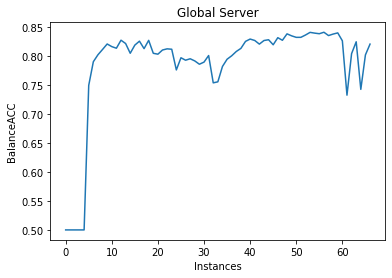

In [14]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
plt.plot(bal_acc_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

Balanced accuracy: 0.8372295418703359
Sensitivity: 0.9047766749379652
Specificity: 0.7696824088027068
Gmean: 0.8345002639872301
Stp score: 0.05693176197685085
Eqop score: -0.04277775617970481


Text(0, 0.5, 'BalanceACC')

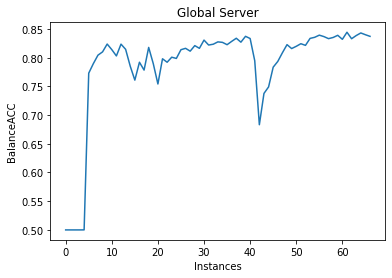

In [16]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))
plt.plot(bal_acc_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [16]:
print(stp_score_global)

[0.012768408626824074, -0.00014650599518203173, 0.09583193477528407, 0.0038917726848282097, 0.07327835522579784, 0.04961438657703032, 0.035493671216541095, -0.008340509242612398, 0.05592641419313926, 0.0654229991009363, 0.09292359080778251, 0.10356751182242682, 0.022880465091224822, 0.014081753290069166, 0.011672734933793616, -0.025959114434588593, -0.05491193659382396, 0.009997753373831186, 0.11397921028696478, 0.037995079189525605, -0.03215325420610704, -0.035534883672328155, -0.039024107960483556, -0.012977555298758853, 0.034557289966112265, 0.01586901449606004, 0.11355730057412783, 0.08685506536879661, 0.13035392573157184, 0.048646577358196386, 0.044495674616065656, 0.057965787978555894, 0.022223749707590806, -0.02215965308374948, -0.020261869542899158, 0.00819060213852088, 0.040354501628537154, 0.082817095167112, 0.047904656725998, 0.00587078755010223, 0.020408366501011382, -0.015853601875937956, 0.01607256440649807, 0.038523482000048015, 0.05077222737468701, 0.0775710294408169, 0

Text(0, 0.5, 'BalanceACC')

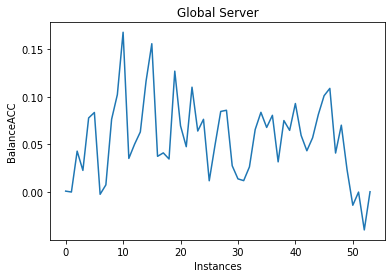

In [12]:
plt.plot(stp_score_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [16]:
print(len(x_test))
print(len(y_test))
x_test, y_test = shuffle(x_test, y_test, random_state=0)
bal_acc_global =[]
global_network.reset_eval_metrics()
for i in range(len(x_test)-1):
    prediction_1 = global_network.predict_1(np.asarray([x_test[i, :]]))
    global_network.update_eval_metrics(prediction_1,np.asarray([y_test[i]]))
    global_network.update_stp_score(prediction_1,np.asarray([x_test[i, :]]))
    global_network.update_eqop_score(prediction_1,np.asarray([x_test[i, :]]),np.asarray([y_test[i]]))
    bal_acc_global.append(global_network.bal_acc)

8001
8001


Balanced accuracy: 0.8375784753421447
Sensitivity: 0.8535091362126246
Specificity: 0.8216478144716648
Gmean: 0.8374269618305237
Stp score: 0.03807428144337341
Eqop score: -0.030423041772582815


Text(0, 0.5, 'BalanceACC')

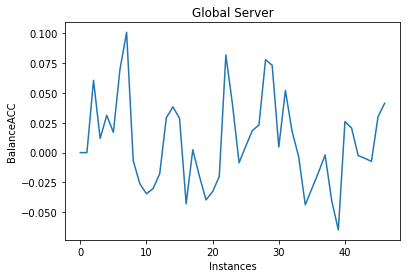

In [17]:
import math
import matplotlib.pyplot as plt
onn_network = global_network
print("Balanced accuracy: " + str(onn_network.bal_acc))
print("Sensitivity: " + str(onn_network.sen))
print("Specificity: " + str(onn_network.spec))
print("Gmean: " + str(math.sqrt(onn_network.sen*onn_network.spec)))
print("Stp score: " + str(onn_network.stp_score))
print("Eqop score: " + str(onn_network.eqop_score))

plt.plot(stp_score_global)
plt.title('Global Server')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [15]:
print(bal_acc_global)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Text(0, 0.5, 'BalanceACC')

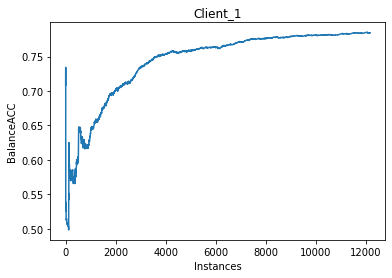

In [20]:
plt.plot(onn_network_1.bal_acc_list)
plt.title('Client_1')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

Text(0, 0.5, 'BalanceACC')

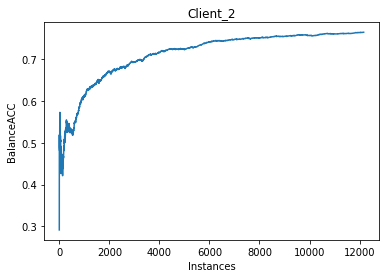

In [21]:
plt.plot(onn_network_2.bal_acc_list)
plt.title('Client_2')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

Text(0, 0.5, 'BalanceACC')

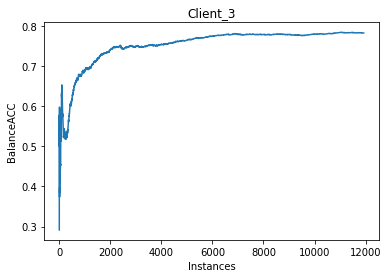

In [22]:
plt.plot(onn_network_3.bal_acc_list)
plt.title('Client_3')
plt.xlabel('Instances')
plt.ylabel('BalanceACC')

In [14]:
sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer = [],[],[],[]
sum_alpha = []
scaling_factor = 1/5
global_network2 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
for m in range(3):
    if m==0:
        onn_network=onn_network_1
    elif m==1:
        onn_network=onn_network_2
    else:
        onn_network=onn_network_3
    if sum_alpha==[]:
        sum_alpha = torch.mul(client_alpha, scaling_factor)
        sum_w_output_layer = client_w_output_layer
        sum_b_output_layer = client_b_output_layer
        sum_w_hidden_layer = client_w_hidden_layer
        sum_b_hidden_layer = client_b_hidden_layer
            
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.mul(client_w_output_layer[j], scaling_factor)
            sum_b_output_layer[j] = torch.mul(client_b_output_layer[j], scaling_factor)
            sum_w_hidden_layer[j] = torch.mul(client_w_hidden_layer[j], scaling_factor)
            sum_b_hidden_layer[j] = torch.mul(client_b_hidden_layer[j], scaling_factor)

    else:
        sum_alpha = torch.add(sum_alpha, torch.mul(client_alpha, scaling_factor))
        for j in range(onn_network.max_num_hidden_layers):
            sum_w_output_layer[j] = torch.add(sum_w_output_layer[j],torch.mul(client_w_output_layer[j], scaling_factor)) 
            sum_b_output_layer[j] = torch.add(sum_b_output_layer[j],torch.mul(client_b_output_layer[j], scaling_factor))
            sum_w_hidden_layer[j] = torch.add(sum_w_hidden_layer[j],torch.mul(client_w_hidden_layer[j], scaling_factor)) 
            sum_b_hidden_layer[j] = torch.add(sum_b_hidden_layer[j],torch.mul(client_b_hidden_layer[j], scaling_factor))
        
        
global_network2.set_weights(sum_alpha, sum_w_output_layer, sum_b_output_layer, sum_w_hidden_layer, sum_b_hidden_layer)


In [23]:
onn_network_4 = ONN(features_size=46, max_num_hidden_layers=5, qtd_neuron_per_hidden_layer=40, n_classes=2)
galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer = onn_network_3.get_weights('local')
onn_network_4.set_weights(galpha, gw_output_layer, gb_output_layer, gw_hidden_layer, gb_hidden_layer)